# QRT Data Challenge 2024

### Goal
The 2024 QRT Data Challenge aimed to predict football match outcomes. Participants were provided with real historical data at the team and player levels, and their task was to predict the winner or whether the match would end in a draw.

The data covers numerous football leagues worldwide, across various divisions. The challenge was to build a robust predictive model capable of making accurate predictions for any football league, regardless of competition level or geographical location.

# Data Description

The dataset includes information at both the team and player levels for dozens of football leagues.

The data is provided in two zip files, X_train.zip and X_test.zip, along with two CSV files, Y_train.csv and Y_train_supp.csv.

The zip files contain input data, divided into four CSV files. The data is categorized into HOME and AWAY, at the team and player levels. All metrics are based on real historical match data, aggregated from the beginning of the season as well as the last five matches prior to the match to be predicted.

The ID column represents a match ID and links the four tables in X_train to Y_train and Y_train_supp. The same structure applies to the test data.

For more information, please refer to the following link: https://challengedata.ens.fr/participants/challenges/143/.

# Import packages

In [ ]:
import pandas as pd

import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
import warnings
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV

set_config(transform_output='polars')
warnings.filterwarnings('ignore')

from joblib import Parallel, delayed


#Pour obtenir le nombre de cores, on ecrit dans le terminal PowerShell: $env:NUMBER_OF_PROCESSORS et on obtient 4.

# Read Train data

In [3]:

df_train_away_team =pd.read_csv(r"C:\Users\HP\Downloads\benchmark_and_extras\Train_Data\train_away_team_statistics_df.csv")
# df_train_away_team

df_train_home_team = pd.read_csv(r"C:\Users\HP\Downloads\benchmark_and_extras\Train_Data\train_home_team_statistics_df.csv")


df_train_away_player =pd.read_csv(r"C:\Users\HP\Downloads\benchmark_and_extras\Train_Data\train_away_player_statistics_df.csv")
# df_train_away_player

df_train_home_player = pd.read_csv(r"C:\Users\HP\Downloads\benchmark_and_extras\Train_Data\train_home_player_statistics_df.csv")

train_scores = pd.read_csv(r"C:\Users\HP\Downloads\benchmark_and_extras\Y_train_1rknArQ.csv", index_col=0) #??

df_train_away_player

,ID,LEAGUE,TEAM_NAME,POSITION,PLAYER_NAME,PLAYER_ACCURATE_CROSSES_season_sum,PLAYER_ACCURATE_PASSES_season_sum,PLAYER_AERIALS_WON_season_sum,PLAYER_ASSISTS_season_sum,PLAYER_BIG_CHANCES_CREATED_season_sum,...,PLAYER_STARTING_LINEUP_5_last_match_std,PLAYER_SUCCESSFUL_DRIBBLES_5_last_match_std,PLAYER_TACKLES_5_last_match_std,PLAYER_TOTAL_CROSSES_5_last_match_std,PLAYER_TOTAL_DUELS_5_last_match_std,PLAYER_YELLOWCARDS_5_last_match_std,PLAYER_PUNCHES_5_last_match_std,PLAYER_LONG_BALLS_5_last_match_std,PLAYER_LONG_BALLS_WON_5_last_match_std,PLAYER_SHOTS_OFF_TARGET_5_last_match_std
0,0,Ligue 1,Olympique Marseille,defender,Lucas Perrin,0.0,19.0,20.0,0.0,0.0,...,70.0,30.0,46.0,0.0,79.0,99.0,NaN,NaN,NaN,NaN
1,0,Ligue 1,Olympique Marseille,midfielder,Kevin Strootman,2.0,48.0,19.0,28.0,8.0,...,77.0,0.0,40.0,6.0,46.0,77.0,NaN,NaN,NaN,NaN
2,0,Ligue 1,Olympique Marseille,goalkeeper,Yohann Pelé,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,0,Ligue 1,Olympique Marseille,defender,Abdallah Ali Mohamed,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Ligue 1,Olympique Marseille,NaN,Nemanja Radonjic,8.0,11.0,4.0,0.0,0.0,...,77.0,69.0,21.0,13.0,66.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236127,12302,La Liga,FC Barcelona,goalkeeper,Marc-André ter Stegen,0.0,36.0,6.0,33.0,12.0,...,0.0,0.0,0.0,0.0,8.0,0.0,NaN,NaN,NaN,NaN
236128,12302,La Liga,FC Barcelona,midfielder,Alex Collado,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236129,12302,La Liga,FC Barcelona,attacker,Lionel Messi,25.0,53.0,4.0,100.0,100.0,...,0.0,76.0,29.0,30.0,36.0,0.0,NaN,NaN,NaN,NaN
236130,12302,La Liga,FC Barcelona,attacker,Antoine Griezmann,6.0,45.0,12.0,66.0,18.0,...,0.0,26.0,14.0,12.0,24.0,0.0,NaN,NaN,NaN,NaN


In [47]:
train_scores

,HOME_WINS,DRAW,AWAY_WINS
ID,,,
0,0,0,1
1,0,1,0
2,0,0,1
3,1,0,0
4,0,1,0
...,...,...,...
12298,0,0,1
12299,0,0,1
12300,0,0,1


# Exploratory Data Analysis (EDA)

In this section, we perform exploratory data analysis (EDA) to visualize and better understand the dataset.

### Calcul de correlation entre la position des joueurs et leurs features

In [280]:
df_test_home_player['POSITION'].unique().tolist()

# df_train_home_player['LEAGUE'].unique().tolist()

['goalkeeper', 'defender', 'midfielder', 'attacker', nan]

In [ ]:
list_col = [col.replace('_season_sum', '') for col in df_test_home_player.columns if col.endswith('_season_sum')]
list_col


In [190]:

# Suppose df is your dataframe with the 'position' categorical feature and numerical features
# Step 1: One-hot encode the 'position' feature

df_test_home_player_drop_ID = df_test_home_player.drop(columns='ID')
df_encoded = pd.get_dummies(df_test_home_player_drop_ID, columns=['POSITION'], prefix='POSITION') # Encodage des positions

# Step 2: Calculate correlations between encoded position columns and numerical features
correlations = (
    df_encoded
    .corr()
    .loc[:, df_encoded.columns.str.startswith('POSITION_')] # Calcul de la matrice de corrélation pour les colonnes de 'POSITION'
    .iloc[:-len(df_test_home_player['POSITION'].unique())] # Exclusion des colonnes d'encodage 'POSITION_' elles-mêmes pour ne garder que les corrélations avec les autres caractéristiques
) 

# Apply background gradient to the correlation matrix for better visualization
correlations_colors = correlations.style.background_gradient(cmap='RdBu', vmin=-1, vmax=1)

# Display the correlation matrix
correlations_colors


,POSITION_attacker,POSITION_defender,POSITION_goalkeeper,POSITION_midfielder
PLAYER_ACCURATE_CROSSES_season_sum,-0.061996,-0.012410,-0.176208,0.183077
PLAYER_ACCURATE_PASSES_season_sum,-0.226259,0.237448,-0.162688,0.071426
PLAYER_AERIALS_WON_season_sum,0.068353,0.241566,-0.219160,-0.151723
PLAYER_ASSISTS_season_sum,0.082880,-0.121854,-0.177752,0.156858
PLAYER_BIG_CHANCES_CREATED_season_sum,0.087366,-0.121959,-0.186786,0.163515
PLAYER_BIG_CHANCES_MISSED_season_sum,0.323714,-0.182239,-0.160465,-0.011883
PLAYER_BLOCKED_SHOTS_season_sum,-0.172307,0.407321,-0.193119,-0.113481
PLAYER_CAPTAIN_season_sum,-0.036972,-0.000180,0.058448,-0.010342
PLAYER_CLEARANCES_season_sum,-0.197038,0.520332,-0.123563,-0.237775
PLAYER_CLEARANCE_OFFLINE_season_sum,-0.059634,0.186141,-0.066777,-0.076266


In [191]:
# Comptage des corrélations absolues supérieures à 0.5
count_high_correlations = (correlations.abs() > 0.8).sum().sum()

print("Nombre de corrélations dont la valeur absolue est supérieure à 0.5 :", count_high_correlations)



Nombre de corrélations dont la valeur absolue est supérieure à 0.5 : 0


### Calcul du pourcentage de NaN par équipe et par features train_home_player_cleaned

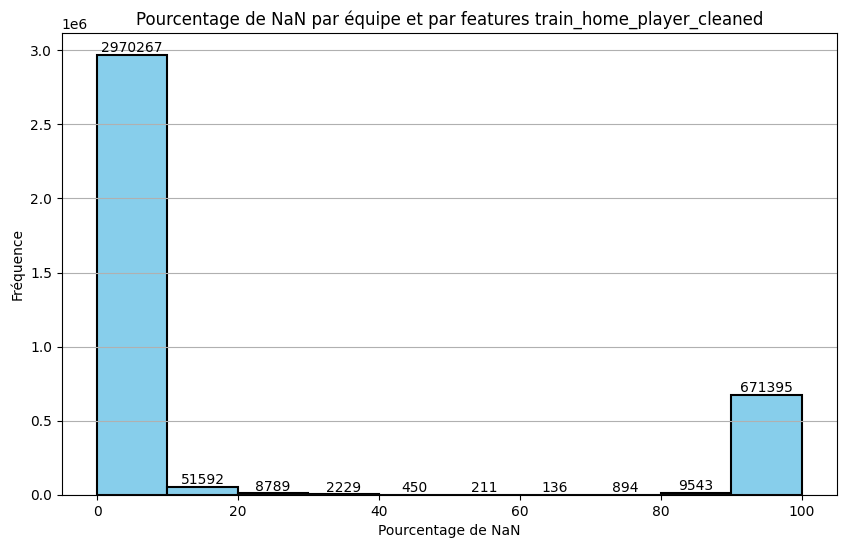

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Fonction pour calculer le pourcentage de NaN
def percentage_nan(group):
    return group.isna().mean() * 100  # Multiplier par 100 pour obtenir le pourcentage

# Appliquer la fonction sur les colonnes d'intérêt en excluant 'ID'
percentage_nan_df = train_home_player_cleaned.groupby('ID').apply(lambda group: percentage_nan(group.drop(columns=['ID'])))

# Réinitialiser l'index pour obtenir un DataFrame propre
percentage_nan_df = percentage_nan_df.reset_index()
percentage_nan_df.columns = ['ID'] + [f'{col}_NaN_percentage' for col in percentage_nan_df.columns[1:]]

percentage_nan_df


# Filtrer les colonnes sauf 'ID'
values = percentage_nan_df.drop(columns=['ID']).values.flatten()  # Aplatir les valeurs en une seule dimension

plt.figure(figsize=(10, 6))

# Tracer l'histogramme sans définir explicitement les `bins`
counts, bins, patches = plt.hist(values, bins=10, color='skyblue', edgecolor='black', linewidth=1.5, align='mid')

# Paramètres du graphique
plt.title('Pourcentage de NaN par équipe et par features train_home_player_cleaned')
plt.xlabel('Pourcentage de NaN')
plt.ylabel('Fréquence')
plt.grid(axis='y')

# Ajouter des annotations au-dessus de chaque barre
for count, bin_center in zip(counts, 0.5 * (bins[:-1] + bins[1:])):
    plt.text(bin_center, count, f'{int(count)}', 
             ha='center', va='bottom', fontsize=10, color='black')

plt.show()

# Feature Engineering and Selection 

In this section, we transform raw data into meaningful features to improve model performance.

### **Player-Level Aggregation: Handling ≤33% NaN with KNN Imputation for Team Features (recommended)**

This section includes functions designed to clean and aggregate player-level data into team-level features. These functions handle missing data, perform imputations, and calculate aggregated metrics such as sum, mean, and standard deviation for specified player statistics.

1. **`DeletePlayerEmpty`**:  
   - Removes rows where all player-related columns are completely empty (100% NaN).  
   - Ensures that only meaningful player data is retained for further processing.

2. **`SimpleImputer_and_player_to_team_sum`**:  
   - Calculates the sum of a specified column at the team level.  
   - Handles missing data based on the percentage of NaN values:  
     - 0% NaN: Direct summation.  
     - ≤33% NaN: Uses KNN imputation to fill missing values before summing.  
     - >33% NaN: Skips aggregation, marking the result as `NaN`.

3. **`SimpleImputer_and_player_to_team_mean`**:  
   - Computes the mean of a specified column at the team level.  
   - Similar logic for handling missing data as the summation function.

4. **`SimpleImputer_and_player_to_team_SD`**:  
   - Calculates the standard deviation of a specified column at the team level.  
   - Missing data is managed with the same thresholds as in the other functions.

These functions allow transforming granular player data into meaningful team-level metrics, essential for predictive modeling in sports analytics.


In [ ]:
from sklearn import set_config
set_config(transform_output='polars')

# supprimer les lignes ou on a 100% de NaN info sur les joueurs
def DeletePlayerEmpty(player_table):
    player_table_cleaned = player_table.dropna(how='all', subset=player_table.columns[1:])
    return player_table_cleaned

# train_away_player_cleaned = train_away_player_cleaned[train_away_player_cleaned['ID'].isin([0, 1, 2])]
# # Obtenir les IDs uniques

def SimpleImputer_and_player_to_team_sum(player_table_cleaned, col, table_type) :
    df_copy = player_table_cleaned.copy()
    # Créer un nouveau DataFrame pour stocker les résultats
    train_HOME_OR_AWAY_PLAYER_IN_TEAM = pd.DataFrame()
    unique_ids = df_copy['ID'].unique()
    # Dictionnaire pour stocker le pourcentage de NaN pour chaque ID
    nan_percentage = {}
    summed_values = {}

    for ID in unique_ids:
        # Calculer le pourcentage de NaN dans la colonne pour chaque ID
        nan_percentage[ID] = df_copy[df_copy['ID'] == ID][col].isna().mean() * 100
            
        if nan_percentage[ID] == 0:
            # Si 0% de NaN, faire la somme directement
            summed_values[ID] = df_copy[df_copy['ID'] == ID][col].sum()
        elif 0 < nan_percentage[ID] <= 33:
            # Si 0 < pourcentage de NaN <= 33%
            # Appliquer l'imputation KNN
            imputer = KNNImputer(n_neighbors=10)
                
            # Imputer les valeurs manquantes pour ce ID
            imputed_values = imputer.fit_transform(df_copy[df_copy['ID'] == ID][[col]])
                
            # Mettre à jour le DataFrame d'origine
            df_copy.loc[df_copy['ID'] == ID, col] = imputed_values
                
            # Faire la somme après imputation
            summed_values[ID] = df_copy[df_copy['ID'] == ID][col].sum()
        else:
            # Si plus de 33% de NaN, on ne fait rien pour cette colonne
            summed_values[ID] = 'NaN'  # Ou vous pouvez choisir de mettre 'NaN'
            
    # train_HOME_OR_AWAY_PLAYER_IN_TEAM['ID'] = unique_ids
    if "away" in table_type :
        new_col_name = col.replace("PLAYER", "AWAY_PLAYER_IN_TEAM")
    elif "home" in table_type :
        new_col_name = col.replace("PLAYER", "HOME_PLAYER_IN_TEAM")
    else:
        new_col_name = col
    train_HOME_OR_AWAY_PLAYER_IN_TEAM[new_col_name] = [summed_values.get(ID, 'NaN') for ID in unique_ids]
    # train_HOME_OR_AWAY_PLAYER_IN_TEAM.reset_index(drop=True, inplace=True)
    return train_HOME_OR_AWAY_PLAYER_IN_TEAM

def SimpleImputer_and_player_to_team_mean(player_table_cleaned, col, table_type) :
    df_copy = player_table_cleaned.copy()
    # Créer un nouveau DataFrame pour stocker les résultats
    train_HOME_OR_AWAY_PLAYER_IN_TEAM = pd.DataFrame()
    unique_ids = df_copy['ID'].unique()
    nan_percentage = {}
    averaged_values = {}

    for ID in unique_ids:
        # Calculer le pourcentage de NaN dans la colonne pour chaque ID
        nan_percentage[ID] = df_copy[df_copy['ID'] == ID][col].isna().mean() * 100
            
        if nan_percentage[ID] == 0:
            # Si 0% de NaN, faire la moyenne directement
            averaged_values[ID] = df_copy[df_copy['ID'] == ID][col].mean()
        elif 0 < nan_percentage[ID] <= 33:
            # Si 0 < pourcentage de NaN <= 33%
            # Appliquer l'imputation KNN
            imputer = KNNImputer(n_neighbors=10)
                
            # Imputer les valeurs manquantes pour ce ID
            imputed_values = imputer.fit_transform(df_copy[df_copy['ID'] == ID][[col]])
                
            # Mettre à jour le DataFrame d'origine
            df_copy.loc[df_copy['ID'] == ID, col] = imputed_values
                
            # Faire la moyenne après imputation
            averaged_values[ID] = df_copy[df_copy['ID'] == ID][col].mean()
        else:
            # Si plus de 33% de NaN, on ne fait rien pour cette colonne
            averaged_values[ID] = 'NaN'  # Ou vous pouvez choisir de mettre 'NaN'

    # train_HOME_OR_AWAY_PLAYER_IN_TEAM['ID'] = unique_ids
    if "away" in table_type :
        new_col_name = col.replace("PLAYER", "AWAY_PLAYER_IN_TEAM")
    elif "home" in table_type :
        new_col_name = col.replace("PLAYER", "HOME_PLAYER_IN_TEAM")
    else:
        new_col_name = col
    train_HOME_OR_AWAY_PLAYER_IN_TEAM[new_col_name] = [averaged_values.get(ID, 'NaN') for ID in unique_ids]
    # train_HOME_OR_AWAY_PLAYER_IN_TEAM.reset_index(drop=True, inplace=True)
    return train_HOME_OR_AWAY_PLAYER_IN_TEAM

def SimpleImputer_and_player_to_team_SD(player_table_cleaned, col, table_type) :
    df_copy = player_table_cleaned.copy()
    # Créer un nouveau DataFrame pour stocker les résultats
    train_HOME_OR_AWAY_PLAYER_IN_TEAM = pd.DataFrame()
    unique_ids = df_copy['ID'].unique()
    nan_percentage = {}
    standardized_values = {}

    for ID in unique_ids:
        # Calculer le pourcentage de NaN dans la colonne pour chaque ID
        nan_percentage[ID] = df_copy[df_copy['ID'] == ID][col].isna().mean() * 100
            
        if nan_percentage[ID] == 0:
            # Si 0% de NaN, faire la moyenne directement
            standardized_values[ID] = df_copy[df_copy['ID'] == ID][col].std()
        elif 0 < nan_percentage[ID] <= 33:
            # Si 0 < pourcentage de NaN <= 33%
            # Appliquer l'imputation KNN
            imputer = KNNImputer(n_neighbors=10)
                
            # Imputer les valeurs manquantes pour ce ID
            imputed_values = imputer.fit_transform(df_copy[df_copy['ID'] == ID][[col]])
                
            # Mettre à jour le DataFrame d'origine
            df_copy.loc[df_copy['ID'] == ID, col] = imputed_values
                
            # Faire la moyenne après imputation
            standardized_values[ID] = df_copy[df_copy['ID'] == ID][col].std()
        else:
            # Si plus de 33% de NaN, on ne fait rien pour cette colonne
            standardized_values[ID] = 'NaN'  # Ou vous pouvez choisir de mettre 'NaN'
            
    # train_HOME_OR_AWAY_PLAYER_IN_TEAM['ID'] = unique_ids
    if "away" in table_type :
        new_col_name = col.replace("PLAYER", "AWAY_PLAYER_IN_TEAM")
    elif "home" in table_type :
        new_col_name = col.replace("PLAYER", "HOME_PLAYER_IN_TEAM")
    else:
        new_col_name = col
    train_HOME_OR_AWAY_PLAYER_IN_TEAM[new_col_name] = [standardized_values.get(ID, 'NaN') for ID in unique_ids]
    # train_HOME_OR_AWAY_PLAYER_IN_TEAM.reset_index(drop=True, inplace=True)
    return train_HOME_OR_AWAY_PLAYER_IN_TEAM


# train_AWAY_PLAYER_IN_TEAM = SimpleImputer_and_player_to_team_sum(train_away_player_cleaned) 
# train_AWAY_PLAYER_IN_TEAM

**Parallel Processing**

This section focuses on processing transformation functions (sum, mean, standard deviation) in parallel for each column in the dataset for both home and away teams.  
Results are concatenated into a final DataFrame.

In [ ]:
# Transformer chaque colonne en parallèle
def process_columns_in_parallel(df, func, columns,  table_type):
    # Utiliser Joblib pour exécuter chaque fonction pour chaque colonne en parallèle
    results = Parallel(n_jobs=-1)(delayed(func)(df, col, table_type) for col in columns)
    # Combiner les résultats dans un DataFrame final
    final_result = pd.concat(results, axis=1)
    return final_result

#AWAY
df_train_away_player =pd.read_csv(r"C:\Users\HP\Downloads\benchmark_and_extras\Train_Data\train_away_player_statistics_df.csv")
train_away_player = df_train_away_player.iloc[:, [0] + list(range(5, df_train_away_player.shape[1]))]
train_away_player_cleaned = DeletePlayerEmpty(train_away_player)
train_away_player_cleaned = train_away_player_cleaned[train_away_player_cleaned['ID'].isin([0, 1, 2])]

columns_away_sum = [col for col in train_away_player_cleaned.columns if col.endswith('_sum') and col != 'ID']
columns_away_mean = [col for col in train_away_player_cleaned.columns if col.endswith('_average') and col != 'ID']
columns_away_std = [col for col in train_away_player_cleaned.columns if col.endswith('_std') and col != 'ID']

#### Appliquer la fonction sur chaque groupe de colonnes avec leurs transformateurs
table_type_away = "away"
result_away_sum = process_columns_in_parallel(train_away_player_cleaned, SimpleImputer_and_player_to_team_sum, columns_away_sum, table_type_away)
result_away_mean = process_columns_in_parallel(train_away_player_cleaned, SimpleImputer_and_player_to_team_mean, columns_away_mean, table_type_away)
result_away_std = process_columns_in_parallel(train_away_player_cleaned, SimpleImputer_and_player_to_team_SD, columns_away_std, table_type_away)

#HOME
df_train_home_player =pd.read_csv(r"C:\Users\HP\Downloads\benchmark_and_extras\Train_Data\train_home_player_statistics_df.csv")
train_home_player = df_train_home_player.iloc[:, [0] + list(range(5, df_train_home_player.shape[1]))]
train_home_player_cleaned = DeletePlayerEmpty(train_home_player)
train_home_player_cleaned = train_home_player_cleaned[train_home_player_cleaned['ID'].isin([0, 1, 2])]

columns_home_sum = [col for col in train_home_player_cleaned.columns if col.endswith('_sum') and col != 'ID']
columns_home_mean = [col for col in train_home_player_cleaned.columns if col.endswith('_average') and col != 'ID']
columns_home_std = [col for col in train_home_player_cleaned.columns if col.endswith('_std') and col != 'ID']

#### Appliquer la fonction sur chaque groupe de colonnes avec leurs transformateurs
table_type_home = "home"
result_home_sum = process_columns_in_parallel(train_home_player_cleaned, SimpleImputer_and_player_to_team_sum, columns_home_sum, table_type_home)
result_home_mean = process_columns_in_parallel(train_home_player_cleaned, SimpleImputer_and_player_to_team_mean, columns_home_mean, table_type_home)
result_home_std = process_columns_in_parallel(train_home_player_cleaned, SimpleImputer_and_player_to_team_SD, columns_home_std, table_type_home)

# Fusionner tous les résultats dans un seul DataFrame
final_transformed_data = pd.concat([result_away_sum, result_away_mean, result_away_std, result_home_sum, result_home_mean, result_home_std], axis=1)
# Transformer les index en colonne avec le nom "ID"
final_transformed_data = final_transformed_data.reset_index()
final_transformed_data.rename(columns={"index": "ID"}, inplace=True)

final_transformed_data

In [3]:
# Enregistrer le DataFrame dans un fichier CSV avec "ID" comme nom pour les index
output_path = r"C:\Users\HP\Downloads\benchmark_and_extras\train_PLAYER_IN_TEAM_KNN_per_ID.csv"
# final_transformed_data.to_csv(output_path, index=False) inutile

tableau_KNN_per_ID = pd.read_csv(output_path)
tableau_KNN_per_ID 

,ID,AWAY_PLAYER_IN_TEAM_ACCURATE_CROSSES_season_sum,AWAY_PLAYER_IN_TEAM_ACCURATE_PASSES_season_sum,AWAY_PLAYER_IN_TEAM_AERIALS_WON_season_sum,AWAY_PLAYER_IN_TEAM_ASSISTS_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_CREATED_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_MISSED_season_sum,AWAY_PLAYER_IN_TEAM_BLOCKED_SHOTS_season_sum,AWAY_PLAYER_IN_TEAM_CAPTAIN_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCES_season_sum,...,HOME_PLAYER_IN_TEAM_STARTING_LINEUP_5_last_match_std,HOME_PLAYER_IN_TEAM_SUCCESSFUL_DRIBBLES_5_last_match_std,HOME_PLAYER_IN_TEAM_TACKLES_5_last_match_std,HOME_PLAYER_IN_TEAM_TOTAL_CROSSES_5_last_match_std,HOME_PLAYER_IN_TEAM_TOTAL_DUELS_5_last_match_std,HOME_PLAYER_IN_TEAM_YELLOWCARDS_5_last_match_std,HOME_PLAYER_IN_TEAM_PUNCHES_5_last_match_std,HOME_PLAYER_IN_TEAM_LONG_BALLS_5_last_match_std,HOME_PLAYER_IN_TEAM_LONG_BALLS_WON_5_last_match_std,HOME_PLAYER_IN_TEAM_SHOTS_OFF_TARGET_5_last_match_std
0,0,129.0,479.0,244.0,140.0,72.0,73.0,141.0,NaN,203.0,...,34.919978,24.481615,20.679462,17.278905,24.360613,39.567559,NaN,NaN,NaN,NaN
1,1,85.0,492.0,236.0,80.0,98.0,148.0,155.0,NaN,249.0,...,14.849242,16.970563,12.788501,11.124959,15.501318,33.116994,NaN,NaN,NaN,NaN
2,2,214.0,529.0,405.0,151.0,278.0,195.0,246.0,NaN,278.0,...,41.096942,17.989896,24.960837,15.476455,22.548204,36.855565,NaN,NaN,NaN,NaN
3,3,73.0,274.0,243.0,108.0,110.0,52.0,113.0,NaN,255.0,...,33.116994,15.278782,16.370306,23.223903,12.654406,30.137376,NaN,NaN,NaN,NaN
4,4,156.0,533.0,197.0,239.0,246.0,233.0,152.0,NaN,339.0,...,30.134876,25.194606,24.437053,19.032662,18.259187,31.693493,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,12298,116.0,393.0,240.0,97.0,123.0,126.0,204.0,NaN,252.0,...,34.117253,10.611992,12.147379,13.931790,16.521822,34.710568,NaN,NaN,NaN,NaN
12299,12299,96.0,398.0,215.0,64.0,121.0,198.0,210.0,NaN,237.0,...,36.113431,14.803675,14.942798,15.588346,18.587677,33.618766,NaN,NaN,NaN,NaN
12300,12300,215.0,366.0,257.0,230.0,379.0,200.0,185.0,NaN,205.0,...,32.075534,18.009801,26.918723,11.157371,14.998039,30.478161,NaN,NaN,NaN,NaN
12301,12301,NaN,NaN,NaN,275.0,NaN,NaN,NaN,NaN,NaN,...,35.243921,NaN,NaN,NaN,NaN,35.972439,NaN,NaN,NaN,NaN


### **Player-Level Aggregation: Handling ≤33% NaN with Mean Imputation for Team Features**

In [ ]:
from sklearn import set_config
set_config(transform_output='polars')

# supprimer les lignes ou on a 100% de NaN info sur les joueurs
def DeletePlayerEmpty(player_table):
    player_table_cleaned = player_table.dropna(how='all', subset=player_table.columns[1:])
    return player_table_cleaned

# train_away_player_cleaned = train_away_player_cleaned[train_away_player_cleaned['ID'].isin([0, 1, 2])]
# # Obtenir les IDs uniques

def SimpleImputer_and_player_to_team_sum(player_table_cleaned, col, table_type) :
    df_copy = player_table_cleaned.copy()
    # Créer un nouveau DataFrame pour stocker les résultats
    train_HOME_OR_AWAY_PLAYER_IN_TEAM = pd.DataFrame()
    unique_ids = df_copy['ID'].unique()
    # Dictionnaire pour stocker le pourcentage de NaN pour chaque ID
    nan_percentage = {}
    summed_values = {}

    for ID in unique_ids:
        # Calculer le pourcentage de NaN dans la colonne pour chaque ID
        nan_percentage[ID] = df_copy[df_copy['ID'] == ID][col].isna().mean() * 100
            
        if nan_percentage[ID] == 0:
            # Si 0% de NaN, faire la somme directement
            summed_values[ID] = df_copy[df_copy['ID'] == ID][col].sum()
        elif 0 < nan_percentage[ID] <= 33:
            # Si 0 < pourcentage de NaN <= 33%
            # Appliquer l'imputation KNN
            imputer =SimpleImputer(missing_values=np.nan, strategy='mean')
                
            # Imputer les valeurs manquantes pour ce ID
            imputed_values = imputer.fit_transform(df_copy[df_copy['ID'] == ID][[col]])
                
            # Mettre à jour le DataFrame d'origine
            df_copy.loc[df_copy['ID'] == ID, col] = imputed_values
              
            # Faire la somme après imputation
            summed_values[ID] = df_copy[df_copy['ID'] == ID][col].sum()
        else:
            # Si plus de 33% de NaN, on ne fait rien pour cette colonne
            summed_values[ID] = 'NaN'  # Ou vous pouvez choisir de mettre 'NaN'
            
    # train_HOME_OR_AWAY_PLAYER_IN_TEAM['ID'] = unique_ids
    if "away" in table_type :
        new_col_name = col.replace("PLAYER", "AWAY_PLAYER_IN_TEAM")
    elif "home" in table_type :
        new_col_name = col.replace("PLAYER", "HOME_PLAYER_IN_TEAM")
    else:
        new_col_name = col
    train_HOME_OR_AWAY_PLAYER_IN_TEAM[new_col_name] = [summed_values.get(ID, 'NaN') for ID in unique_ids]
    # train_HOME_OR_AWAY_PLAYER_IN_TEAM.reset_index(drop=True, inplace=True)
    return train_HOME_OR_AWAY_PLAYER_IN_TEAM

def SimpleImputer_and_player_to_team_mean(player_table_cleaned, col, table_type) :
    df_copy = player_table_cleaned.copy()
    # Créer un nouveau DataFrame pour stocker les résultats
    train_HOME_OR_AWAY_PLAYER_IN_TEAM = pd.DataFrame()
    unique_ids = df_copy['ID'].unique()
    nan_percentage = {}
    averaged_values = {}

    for ID in unique_ids:
        # Calculer le pourcentage de NaN dans la colonne pour chaque ID
        nan_percentage[ID] = df_copy[df_copy['ID'] == ID][col].isna().mean() * 100
            
        if nan_percentage[ID] == 0:
            # Si 0% de NaN, faire la moyenne directement
            averaged_values[ID] = df_copy[df_copy['ID'] == ID][col].mean()
        elif 0 < nan_percentage[ID] <= 33:
            # Si 0 < pourcentage de NaN <= 33%
            # Appliquer l'imputation KNN
            imputer =SimpleImputer(missing_values=np.nan, strategy='mean')
                
            # Imputer les valeurs manquantes pour ce ID
            imputed_values = imputer.fit_transform(df_copy[df_copy['ID'] == ID][[col]])
                
            # Mettre à jour le DataFrame d'origine
            df_copy.loc[df_copy['ID'] == ID, col] = imputed_values
                
            # Faire la moyenne après imputation
            averaged_values[ID] = df_copy[df_copy['ID'] == ID][col].mean()
        else:
            # Si plus de 33% de NaN, on ne fait rien pour cette colonne
            averaged_values[ID] = 'NaN'  # Ou vous pouvez choisir de mettre 'NaN'

    # train_HOME_OR_AWAY_PLAYER_IN_TEAM['ID'] = unique_ids
    if "away" in table_type :
        new_col_name = col.replace("PLAYER", "AWAY_PLAYER_IN_TEAM")
    elif "home" in table_type :
        new_col_name = col.replace("PLAYER", "HOME_PLAYER_IN_TEAM")
    else:
        new_col_name = col
    train_HOME_OR_AWAY_PLAYER_IN_TEAM[new_col_name] = [averaged_values.get(ID, 'NaN') for ID in unique_ids]
    # train_HOME_OR_AWAY_PLAYER_IN_TEAM.reset_index(drop=True, inplace=True)
    return train_HOME_OR_AWAY_PLAYER_IN_TEAM

def SimpleImputer_and_player_to_team_SD(player_table_cleaned, col, table_type) :
    df_copy = player_table_cleaned.copy()
    # Créer un nouveau DataFrame pour stocker les résultats
    train_HOME_OR_AWAY_PLAYER_IN_TEAM = pd.DataFrame()
    unique_ids = df_copy['ID'].unique()
    nan_percentage = {}
    standardized_values = {}

    for ID in unique_ids:
        # Calculer le pourcentage de NaN dans la colonne pour chaque ID
        nan_percentage[ID] = df_copy[df_copy['ID'] == ID][col].isna().mean() * 100
            
        if nan_percentage[ID] == 0:
            # Si 0% de NaN, faire la moyenne directement
            standardized_values[ID] = df_copy[df_copy['ID'] == ID][col].std()
        elif 0 < nan_percentage[ID] <= 33:
            # Si 0 < pourcentage de NaN <= 33%
            # Appliquer l'imputation KNN
            imputer =SimpleImputer(missing_values=np.nan, strategy='mean')
                
            # Imputer les valeurs manquantes pour ce ID
            imputed_values = imputer.fit_transform(df_copy[df_copy['ID'] == ID][[col]])
              
            # Mettre à jour le DataFrame d'origine
            df_copy.loc[df_copy['ID'] == ID, col] = imputed_values
                
            # Faire la moyenne après imputation
            standardized_values[ID] = df_copy[df_copy['ID'] == ID][col].std()
        else:
            # Si plus de 33% de NaN, on ne fait rien pour cette colonne
            standardized_values[ID] = 'NaN'  # Ou vous pouvez choisir de mettre 'NaN'
        
    # train_HOME_OR_AWAY_PLAYER_IN_TEAM['ID'] = unique_ids
    if "away" in table_type :
        new_col_name = col.replace("PLAYER", "AWAY_PLAYER_IN_TEAM")
    elif "home" in table_type :
        new_col_name = col.replace("PLAYER", "HOME_PLAYER_IN_TEAM")
    else:
        new_col_name = col
    train_HOME_OR_AWAY_PLAYER_IN_TEAM[new_col_name] = [standardized_values.get(ID, 'NaN') for ID in unique_ids]
    # train_HOME_OR_AWAY_PLAYER_IN_TEAM.reset_index(drop=True, inplace=True)
  
    return train_HOME_OR_AWAY_PLAYER_IN_TEAM

# imputed_values
# train_AWAY_PLAYER_IN_TEAM = SimpleImputer_and_player_to_team_sum(train_away_player_cleaned) 
# train_AWAY_PLAYER_IN_TEAM

In [ ]:
# Transformer chaque colonne en parallèle
def process_columns_in_parallel(df, func, columns,  table_type):
    # Utiliser Joblib pour exécuter chaque fonction pour chaque colonne en parallèle
    results = Parallel(n_jobs=-1)(delayed(func)(df, col, table_type) for col in columns)
    # Combiner les résultats dans un DataFrame final
    final_result = pd.concat(results, axis=1)
    return final_result

#AWAY
df_train_away_player =pd.read_csv(r"C:\Users\HP\Downloads\benchmark_and_extras\Train_Data\train_away_player_statistics_df.csv")
train_away_player = df_train_away_player.iloc[:, [0] + list(range(5, df_train_away_player.shape[1]))]
train_away_player_cleaned = DeletePlayerEmpty(train_away_player)
#train_away_player_cleaned = train_away_player_cleaned[train_away_player_cleaned['ID'].isin([0, 1, 2])]

columns_away_sum = [col for col in train_away_player_cleaned.columns if col.endswith('_sum') and col != 'ID']
columns_away_mean = [col for col in train_away_player_cleaned.columns if col.endswith('_average') and col != 'ID']
columns_away_std = [col for col in train_away_player_cleaned.columns if col.endswith('_std') and col != 'ID']

#### Appliquer la fonction sur chaque groupe de colonnes avec leurs transformateurs
table_type_away = "away"
result_away_sum = process_columns_in_parallel(train_away_player_cleaned, SimpleImputer_and_player_to_team_sum, columns_away_sum, table_type_away)
result_away_mean = process_columns_in_parallel(train_away_player_cleaned, SimpleImputer_and_player_to_team_mean, columns_away_mean, table_type_away)
result_away_std = process_columns_in_parallel(train_away_player_cleaned, SimpleImputer_and_player_to_team_SD, columns_away_std, table_type_away)

#HOME
df_train_home_player =pd.read_csv(r"C:\Users\HP\Downloads\benchmark_and_extras\Train_Data\train_home_player_statistics_df.csv")
train_home_player = df_train_home_player.iloc[:, [0] + list(range(5, df_train_home_player.shape[1]))]
train_home_player_cleaned = DeletePlayerEmpty(train_home_player)
#train_home_player_cleaned = train_home_player_cleaned[train_home_player_cleaned['ID'].isin([0, 1, 2])]

columns_home_sum = [col for col in train_home_player_cleaned.columns if col.endswith('_sum') and col != 'ID']
columns_home_mean = [col for col in train_home_player_cleaned.columns if col.endswith('_average') and col != 'ID']
columns_home_std = [col for col in train_home_player_cleaned.columns if col.endswith('_std') and col != 'ID']

#### Appliquer la fonction sur chaque groupe de colonnes avec leurs transformateurs
table_type_home = "home"
result_home_sum = process_columns_in_parallel(train_home_player_cleaned, SimpleImputer_and_player_to_team_sum, columns_home_sum, table_type_home)
result_home_mean = process_columns_in_parallel(train_home_player_cleaned, SimpleImputer_and_player_to_team_mean, columns_home_mean, table_type_home)
result_home_std = process_columns_in_parallel(train_home_player_cleaned, SimpleImputer_and_player_to_team_SD, columns_home_std, table_type_home)

# Fusionner tous les résultats dans un seul DataFrame
final_transformed_data = pd.concat([result_away_sum, result_away_mean, result_away_std, result_home_sum, result_home_mean, result_home_std], axis=1)
# Transformer les index en colonne avec le nom "ID"
final_transformed_data = final_transformed_data.reset_index()
final_transformed_data.rename(columns={"index": "ID"}, inplace=True)

final_transformed_data

,ID,AWAY_PLAYER_IN_TEAM_ACCURATE_CROSSES_season_sum,AWAY_PLAYER_IN_TEAM_ACCURATE_PASSES_season_sum,AWAY_PLAYER_IN_TEAM_AERIALS_WON_season_sum,AWAY_PLAYER_IN_TEAM_ASSISTS_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_CREATED_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_MISSED_season_sum,AWAY_PLAYER_IN_TEAM_BLOCKED_SHOTS_season_sum,AWAY_PLAYER_IN_TEAM_CAPTAIN_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCES_season_sum,...,HOME_PLAYER_IN_TEAM_STARTING_LINEUP_5_last_match_std,HOME_PLAYER_IN_TEAM_SUCCESSFUL_DRIBBLES_5_last_match_std,HOME_PLAYER_IN_TEAM_TACKLES_5_last_match_std,HOME_PLAYER_IN_TEAM_TOTAL_CROSSES_5_last_match_std,HOME_PLAYER_IN_TEAM_TOTAL_DUELS_5_last_match_std,HOME_PLAYER_IN_TEAM_YELLOWCARDS_5_last_match_std,HOME_PLAYER_IN_TEAM_PUNCHES_5_last_match_std,HOME_PLAYER_IN_TEAM_LONG_BALLS_5_last_match_std,HOME_PLAYER_IN_TEAM_LONG_BALLS_WON_5_last_match_std,HOME_PLAYER_IN_TEAM_SHOTS_OFF_TARGET_5_last_match_std
0,0,129.0,479.0,244.0,140.0,72.0,73.0,141.0,NaN,203.0,...,34.919978,24.481615,20.679462,17.278905,24.360613,39.567559,NaN,NaN,NaN,NaN
1,1,85.0,492.0,236.0,80.0,98.0,148.0,155.0,NaN,249.0,...,14.849242,16.970563,12.788501,11.124959,15.501318,33.116994,NaN,NaN,NaN,NaN
2,2,214.0,529.0,405.0,151.0,278.0,195.0,246.0,NaN,278.0,...,41.096942,17.989896,24.960837,15.476455,22.548204,36.855565,NaN,NaN,NaN,NaN
3,3,73.0,274.0,243.0,108.0,110.0,52.0,113.0,NaN,255.0,...,33.116994,15.278782,16.370306,23.223903,12.654406,30.137376,NaN,NaN,NaN,NaN
4,4,156.0,533.0,197.0,239.0,246.0,233.0,152.0,NaN,339.0,...,30.134876,25.194606,24.437053,19.032662,18.259187,31.693493,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,12298,116.0,393.0,240.0,97.0,123.0,126.0,204.0,NaN,252.0,...,34.117253,10.611992,12.147379,13.93179,16.521822,34.710568,NaN,NaN,NaN,NaN
12299,12299,96.0,398.0,215.0,64.0,121.0,198.0,210.0,NaN,237.0,...,36.113431,14.803675,14.942798,15.588346,18.587677,33.618766,NaN,NaN,NaN,NaN
12300,12300,215.0,366.0,257.0,230.0,379.0,200.0,185.0,NaN,205.0,...,32.075534,18.009801,26.918723,11.157371,14.998039,30.478161,NaN,NaN,NaN,NaN
12301,12301,NaN,NaN,NaN,275.0,NaN,NaN,NaN,NaN,NaN,...,35.243921,NaN,NaN,NaN,NaN,35.972439,NaN,NaN,NaN,NaN


In [90]:
# Enregistrer le DataFrame dans un fichier CSV avec "ID" comme nom pour les index
output_path = r"C:\Users\HP\Downloads\benchmark_and_extras\train_PLAYER_IN_TEAM_Mean_per_ID.csv"
final_transformed_data.to_csv(output_path, index=False)
tableau_Mean_per_ID = pd.read_csv(output_path)

### **Player-Level Aggregation: Handling ≤44% NaN with Mean Imputation for Team Features**

In [ ]:
from sklearn import set_config
set_config(transform_output='polars')

# supprimer les lignes ou on a 100% de NaN info sur les joueurs
def DeletePlayerEmpty(player_table):
    player_table_cleaned = player_table.dropna(how='all', subset=player_table.columns[1:])
    return player_table_cleaned

# train_away_player_cleaned = train_away_player_cleaned[train_away_player_cleaned['ID'].isin([0, 1, 2])]
# # Obtenir les IDs uniques

def SimpleImputer_and_player_to_team_sum(player_table_cleaned, col, table_type) :
    df_copy = player_table_cleaned.copy()
    # Créer un nouveau DataFrame pour stocker les résultats
    train_HOME_OR_AWAY_PLAYER_IN_TEAM = pd.DataFrame()
    unique_ids = df_copy['ID'].unique()
    # Dictionnaire pour stocker le pourcentage de NaN pour chaque ID
    nan_percentage = {}
    summed_values = {}

    for ID in unique_ids:
        # Calculer le pourcentage de NaN dans la colonne pour chaque ID
        nan_percentage[ID] = df_copy[df_copy['ID'] == ID][col].isna().mean() * 100
            
        if nan_percentage[ID] == 0:
            # Si 0% de NaN, faire la somme directement
            summed_values[ID] = df_copy[df_copy['ID'] == ID][col].sum()
        elif 0 < nan_percentage[ID] <= 44:
            # Si 0 < pourcentage de NaN <= 44%
            # Appliquer l'imputation KNN
            imputer =SimpleImputer(missing_values=np.nan, strategy='mean')
                
            # Imputer les valeurs manquantes pour ce ID
            imputed_values = imputer.fit_transform(df_copy[df_copy['ID'] == ID][[col]])
                
            # Mettre à jour le DataFrame d'origine
            df_copy.loc[df_copy['ID'] == ID, col] = imputed_values
              
            # Faire la somme après imputation
            summed_values[ID] = df_copy[df_copy['ID'] == ID][col].sum()
        else:
            # Si plus de 44% de NaN, on ne fait rien pour cette colonne
            summed_values[ID] = 'NaN'  # Ou vous pouvez choisir de mettre 'NaN'
            
    # train_HOME_OR_AWAY_PLAYER_IN_TEAM['ID'] = unique_ids
    if "away" in table_type :
        new_col_name = col.replace("PLAYER", "AWAY_PLAYER_IN_TEAM")
    elif "home" in table_type :
        new_col_name = col.replace("PLAYER", "HOME_PLAYER_IN_TEAM")
    else:
        new_col_name = col
    train_HOME_OR_AWAY_PLAYER_IN_TEAM[new_col_name] = [summed_values.get(ID, 'NaN') for ID in unique_ids]
    # train_HOME_OR_AWAY_PLAYER_IN_TEAM.reset_index(drop=True, inplace=True)
    return train_HOME_OR_AWAY_PLAYER_IN_TEAM

def SimpleImputer_and_player_to_team_mean(player_table_cleaned, col, table_type) :
    df_copy = player_table_cleaned.copy()
    # Créer un nouveau DataFrame pour stocker les résultats
    train_HOME_OR_AWAY_PLAYER_IN_TEAM = pd.DataFrame()
    unique_ids = df_copy['ID'].unique()
    nan_percentage = {}
    averaged_values = {}

    for ID in unique_ids:
        # Calculer le pourcentage de NaN dans la colonne pour chaque ID
        nan_percentage[ID] = df_copy[df_copy['ID'] == ID][col].isna().mean() * 100
            
        if nan_percentage[ID] == 0:
            # Si 0% de NaN, faire la moyenne directement
            averaged_values[ID] = df_copy[df_copy['ID'] == ID][col].mean()
        elif 0 < nan_percentage[ID] <= 44:
            # Si 0 < pourcentage de NaN <= 44%
            # Appliquer l'imputation KNN
            imputer =SimpleImputer(missing_values=np.nan, strategy='mean')
                
            # Imputer les valeurs manquantes pour ce ID
            imputed_values = imputer.fit_transform(df_copy[df_copy['ID'] == ID][[col]])
                
            # Mettre à jour le DataFrame d'origine
            df_copy.loc[df_copy['ID'] == ID, col] = imputed_values
                
            # Faire la moyenne après imputation
            averaged_values[ID] = df_copy[df_copy['ID'] == ID][col].mean()
        else:
            # Si plus de 44% de NaN, on ne fait rien pour cette colonne
            averaged_values[ID] = 'NaN'  # Ou vous pouvez choisir de mettre 'NaN'

    # train_HOME_OR_AWAY_PLAYER_IN_TEAM['ID'] = unique_ids
    if "away" in table_type :
        new_col_name = col.replace("PLAYER", "AWAY_PLAYER_IN_TEAM")
    elif "home" in table_type :
        new_col_name = col.replace("PLAYER", "HOME_PLAYER_IN_TEAM")
    else:
        new_col_name = col
    train_HOME_OR_AWAY_PLAYER_IN_TEAM[new_col_name] = [averaged_values.get(ID, 'NaN') for ID in unique_ids]
    # train_HOME_OR_AWAY_PLAYER_IN_TEAM.reset_index(drop=True, inplace=True)
    return train_HOME_OR_AWAY_PLAYER_IN_TEAM

def SimpleImputer_and_player_to_team_SD(player_table_cleaned, col, table_type) :
    df_copy = player_table_cleaned.copy()
    # Créer un nouveau DataFrame pour stocker les résultats
    train_HOME_OR_AWAY_PLAYER_IN_TEAM = pd.DataFrame()
    unique_ids = df_copy['ID'].unique()
    nan_percentage = {}
    standardized_values = {}

    for ID in unique_ids:
        # Calculer le pourcentage de NaN dans la colonne pour chaque ID
        nan_percentage[ID] = df_copy[df_copy['ID'] == ID][col].isna().mean() * 100
            
        if nan_percentage[ID] == 0:
            # Si 0% de NaN, faire la moyenne directement
            standardized_values[ID] = df_copy[df_copy['ID'] == ID][col].std()
        elif 0 < nan_percentage[ID] <= 44:
            # Si 0 < pourcentage de NaN <= 44%
            # Appliquer l'imputation KNN
            imputer =SimpleImputer(missing_values=np.nan, strategy='mean')
                
            # Imputer les valeurs manquantes pour ce ID
            imputed_values = imputer.fit_transform(df_copy[df_copy['ID'] == ID][[col]])
              
            # Mettre à jour le DataFrame d'origine
            df_copy.loc[df_copy['ID'] == ID, col] = imputed_values
                
            # Faire la moyenne après imputation
            standardized_values[ID] = df_copy[df_copy['ID'] == ID][col].std()
        else:
            # Si plus de 44% de NaN, on ne fait rien pour cette colonne
            standardized_values[ID] = 'NaN'  # Ou vous pouvez choisir de mettre 'NaN'
        
    # train_HOME_OR_AWAY_PLAYER_IN_TEAM['ID'] = unique_ids
    if "away" in table_type :
        new_col_name = col.replace("PLAYER", "AWAY_PLAYER_IN_TEAM")
    elif "home" in table_type :
        new_col_name = col.replace("PLAYER", "HOME_PLAYER_IN_TEAM")
    else:
        new_col_name = col
    train_HOME_OR_AWAY_PLAYER_IN_TEAM[new_col_name] = [standardized_values.get(ID, 'NaN') for ID in unique_ids]
    # train_HOME_OR_AWAY_PLAYER_IN_TEAM.reset_index(drop=True, inplace=True)
  
    return train_HOME_OR_AWAY_PLAYER_IN_TEAM

# imputed_values
# train_AWAY_PLAYER_IN_TEAM = SimpleImputer_and_player_to_team_sum(train_away_player_cleaned) 
# train_AWAY_PLAYER_IN_TEAM

In [ ]:
# Transformer chaque colonne en parallèle
def process_columns_in_parallel(df, func, columns,  table_type):
    # Utiliser Joblib pour exécuter chaque fonction pour chaque colonne en parallèle
    results = Parallel(n_jobs=-1)(delayed(func)(df, col, table_type) for col in columns)
    # Combiner les résultats dans un DataFrame final
    final_result = pd.concat(results, axis=1)
    return final_result

#AWAY
df_train_away_player =pd.read_csv(r"C:\Users\HP\Downloads\benchmark_and_extras\Train_Data\train_away_player_statistics_df.csv")
train_away_player = df_train_away_player.iloc[:, [0] + list(range(5, df_train_away_player.shape[1]))]
train_away_player_cleaned = DeletePlayerEmpty(train_away_player)
#train_away_player_cleaned = train_away_player_cleaned[train_away_player_cleaned['ID'].isin([0, 1, 2])]

columns_away_sum = [col for col in train_away_player_cleaned.columns if col.endswith('_sum') and col != 'ID']
columns_away_mean = [col for col in train_away_player_cleaned.columns if col.endswith('_average') and col != 'ID']
columns_away_std = [col for col in train_away_player_cleaned.columns if col.endswith('_std') and col != 'ID']

#### Appliquer la fonction sur chaque groupe de colonnes avec leurs transformateurs
table_type_away = "away"
result_away_sum = process_columns_in_parallel(train_away_player_cleaned, SimpleImputer_and_player_to_team_sum, columns_away_sum, table_type_away)
result_away_mean = process_columns_in_parallel(train_away_player_cleaned, SimpleImputer_and_player_to_team_mean, columns_away_mean, table_type_away)
result_away_std = process_columns_in_parallel(train_away_player_cleaned, SimpleImputer_and_player_to_team_SD, columns_away_std, table_type_away)

#HOME
df_train_home_player =pd.read_csv(r"C:\Users\HP\Downloads\benchmark_and_extras\Train_Data\train_home_player_statistics_df.csv")
train_home_player = df_train_home_player.iloc[:, [0] + list(range(5, df_train_home_player.shape[1]))]
train_home_player_cleaned = DeletePlayerEmpty(train_home_player)
#train_home_player_cleaned = train_home_player_cleaned[train_home_player_cleaned['ID'].isin([0, 1, 2])]

columns_home_sum = [col for col in train_home_player_cleaned.columns if col.endswith('_sum') and col != 'ID']
columns_home_mean = [col for col in train_home_player_cleaned.columns if col.endswith('_average') and col != 'ID']
columns_home_std = [col for col in train_home_player_cleaned.columns if col.endswith('_std') and col != 'ID']

#### Appliquer la fonction sur chaque groupe de colonnes avec leurs transformateurs
table_type_home = "home"
result_home_sum = process_columns_in_parallel(train_home_player_cleaned, SimpleImputer_and_player_to_team_sum, columns_home_sum, table_type_home)
result_home_mean = process_columns_in_parallel(train_home_player_cleaned, SimpleImputer_and_player_to_team_mean, columns_home_mean, table_type_home)
result_home_std = process_columns_in_parallel(train_home_player_cleaned, SimpleImputer_and_player_to_team_SD, columns_home_std, table_type_home)

# Fusionner tous les résultats dans un seul DataFrame
final_transformed_data = pd.concat([result_away_sum, result_away_mean, result_away_std, result_home_sum, result_home_mean, result_home_std], axis=1)
# Transformer les index en colonne avec le nom "ID"
final_transformed_data = final_transformed_data.reset_index()
final_transformed_data.rename(columns={"index": "ID"}, inplace=True)

final_transformed_data

,ID,AWAY_PLAYER_IN_TEAM_ACCURATE_CROSSES_season_sum,AWAY_PLAYER_IN_TEAM_ACCURATE_PASSES_season_sum,AWAY_PLAYER_IN_TEAM_AERIALS_WON_season_sum,AWAY_PLAYER_IN_TEAM_ASSISTS_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_CREATED_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_MISSED_season_sum,AWAY_PLAYER_IN_TEAM_BLOCKED_SHOTS_season_sum,AWAY_PLAYER_IN_TEAM_CAPTAIN_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCES_season_sum,...,HOME_PLAYER_IN_TEAM_STARTING_LINEUP_5_last_match_std,HOME_PLAYER_IN_TEAM_SUCCESSFUL_DRIBBLES_5_last_match_std,HOME_PLAYER_IN_TEAM_TACKLES_5_last_match_std,HOME_PLAYER_IN_TEAM_TOTAL_CROSSES_5_last_match_std,HOME_PLAYER_IN_TEAM_TOTAL_DUELS_5_last_match_std,HOME_PLAYER_IN_TEAM_YELLOWCARDS_5_last_match_std,HOME_PLAYER_IN_TEAM_PUNCHES_5_last_match_std,HOME_PLAYER_IN_TEAM_LONG_BALLS_5_last_match_std,HOME_PLAYER_IN_TEAM_LONG_BALLS_WON_5_last_match_std,HOME_PLAYER_IN_TEAM_SHOTS_OFF_TARGET_5_last_match_std
0,0,129.0,479.0,244.0,140.0,72.0,73.0,141.0,NaN,203.0,...,34.919978,24.481615,20.679462,17.278905,24.360613,39.567559,NaN,NaN,NaN,NaN
1,1,85.0,492.0,236.0,80.0,98.0,148.0,155.0,NaN,249.0,...,14.849242,16.970563,12.788501,11.124959,15.501318,33.116994,NaN,NaN,NaN,NaN
2,2,214.0,529.0,405.0,151.0,278.0,195.0,246.0,NaN,278.0,...,41.096942,17.989896,24.960837,15.476455,22.548204,36.855565,NaN,NaN,NaN,NaN
3,3,73.0,274.0,243.0,108.0,110.0,52.0,113.0,NaN,255.0,...,33.116994,15.278782,16.370306,23.223903,12.654406,30.137376,NaN,NaN,NaN,NaN
4,4,156.0,533.0,197.0,239.0,246.0,233.0,152.0,NaN,339.0,...,30.134876,25.194606,24.437053,19.032662,18.259187,31.693493,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,12298,116.0,393.0,240.0,97.0,123.0,126.0,204.0,NaN,252.0,...,34.117253,10.611992,12.147379,13.93179,16.521822,34.710568,NaN,NaN,NaN,NaN
12299,12299,96.0,398.0,215.0,64.0,121.0,198.0,210.0,NaN,237.0,...,36.113431,14.803675,14.942798,15.588346,18.587677,33.618766,NaN,NaN,NaN,NaN
12300,12300,215.0,366.0,257.0,230.0,379.0,200.0,185.0,NaN,205.0,...,32.075534,18.009801,26.918723,11.157371,14.998039,30.478161,NaN,NaN,NaN,NaN
12301,12301,NaN,NaN,NaN,275.0,NaN,NaN,NaN,NaN,NaN,...,35.243921,NaN,NaN,NaN,NaN,35.972439,NaN,NaN,NaN,NaN


In [35]:
# Enregistrer le DataFrame dans un fichier CSV avec "ID" comme nom pour les index
output_path = r"C:\Users\HP\Downloads\benchmark_and_extras\train_PLAYER_IN_TEAM_44Mean_per_ID.csv"
final_transformed_data.to_csv(output_path, index=False)
tableau_44Mean_per_ID = pd.read_csv(output_path)

### **Player-Level Aggregation: Handling ≤33% NaN with KNN Imputation for Team Features using Global Dataset Context (Too time-consuming, process was interrupted)**

In this programme, missing values are imputed using the KNNImputer method. Unlike a localised approach that would restrict itself to the data of a single team, the KNN algorithm computes the nearest neighbours across the entire dataset. This means the imputation is influenced by the global characteristics of all teams, rather than being confined to the specific team under consideration.

This approach leverages global information to enrich the missing data, which can be beneficial if the teams share similar characteristics. However, the process was excessively time-consuming, prompting me to terminate it before completion.

In [ ]:
from sklearn import set_config
set_config(transform_output='polars')

# Supprimer les lignes où il y a 100% de NaN pour les informations sur les joueurs
def DeletePlayerEmpty(player_table):
    player_table_cleaned = player_table.dropna(how='all', subset=player_table.columns[1:])
    return player_table_cleaned

# Fonction pour imputer et calculer la somme en fonction du pourcentage de NaN par ID
def SimpleImputer_and_player_to_team_sum(player_table_cleaned, col, table_type):
    df_copy = player_table_cleaned.copy()
    unique_ids = df_copy['ID'].unique()
    nan_percentage = {}
    summed_values = {}

    # Fit KNNImputer sur toute la colonne spécifiée
    imputer = KNNImputer(n_neighbors=3)
    df_imputed = df_copy.copy()
    
    # Appliquer le KNNImputer pour la colonne sélectionnée et vérifier les longueurs
    try:
        df_imputed[[col]] = imputer.fit_transform(df_copy[[col]])
        if len(df_copy) != len(df_imputed):
            raise ValueError(f"Inconsistent lengths after imputation: df_copy({len(df_copy)}), df_imputed({len(df_imputed)})")
    except ValueError as e:
        print(f"Erreur lors de l'imputation sur la colonne {col}: {e}")
        return pd.DataFrame()  # Retourne un DataFrame vide en cas d'erreur

    # Boucle pour calculer les sommes en fonction du pourcentage de NaN
    for ID in unique_ids:
        nan_percentage[ID] = df_copy[df_copy['ID'] == ID][col].isna().mean() * 100
            
        if nan_percentage[ID] == 0:
            summed_values[ID] = df_copy[df_copy['ID'] == ID][col].sum()
        elif 0 < nan_percentage[ID] <= 33:
            df_copy.loc[df_copy['ID'] == ID, col] = df_imputed.loc[df_copy['ID'] == ID, col]
            summed_values[ID] = df_copy[df_copy['ID'] == ID][col].sum()
        else:
            summed_values[ID] = 'NaN'

    # Création de la colonne de résultat avec vérification de longueur
    if "away" in table_type:
        new_col_name = col.replace("PLAYER", "AWAY_PLAYER_IN_TEAM")
    elif "home" in table_type:
        new_col_name = col.replace("PLAYER", "HOME_PLAYER_IN_TEAM")
    else:
        new_col_name = col

    result_df = pd.DataFrame({
        'ID': unique_ids,
        new_col_name: [summed_values.get(ID, 'NaN') for ID in unique_ids]
    })

    result_df.reset_index(drop=True, inplace=True)
    return result_df

# Fonction pour imputer et calculer la moyenne en fonction du pourcentage de NaN par ID
def SimpleImputer_and_player_to_team_mean(player_table_cleaned, col, table_type):
    df_copy = player_table_cleaned.copy()
    unique_ids = df_copy['ID'].unique()
    nan_percentage = {}
    averaged_values = {}

    # Fit KNNImputer sur toute la colonne spécifiée
    imputer = KNNImputer(n_neighbors=3)
    df_imputed = df_copy.copy()
    
    try:
        df_imputed[[col]] = imputer.fit_transform(df_copy[[col]])
        if len(df_copy) != len(df_imputed):
            raise ValueError(f"Inconsistent lengths after imputation: df_copy({len(df_copy)}), df_imputed({len(df_imputed)})")
    except ValueError as e:
        print(f"Erreur lors de l'imputation sur la colonne {col}: {e}")
        return pd.DataFrame()

    for ID in unique_ids:
        nan_percentage[ID] = df_copy[df_copy['ID'] == ID][col].isna().mean() * 100
            
        if nan_percentage[ID] == 0:
            averaged_values[ID] = df_copy[df_copy['ID'] == ID][col].mean()
        elif 0 < nan_percentage[ID] <= 33:
            df_copy.loc[df_copy['ID'] == ID, col] = df_imputed.loc[df_copy['ID'] == ID, col]
            averaged_values[ID] = df_copy[df_copy['ID'] == ID][col].mean()
        else:
            averaged_values[ID] = 'NaN'

    if "away" in table_type:
        new_col_name = col.replace("PLAYER", "AWAY_PLAYER_IN_TEAM")
    elif "home" in table_type:
        new_col_name = col.replace("PLAYER", "HOME_PLAYER_IN_TEAM")
    else:
        new_col_name = col

    result_df = pd.DataFrame({
        'ID': unique_ids,
        new_col_name: [averaged_values.get(ID, 'NaN') for ID in unique_ids]
    })

    result_df.reset_index(drop=True, inplace=True)
    return result_df

# Fonction pour imputer et calculer l'écart type en fonction du pourcentage de NaN par ID
def SimpleImputer_and_player_to_team_SD(player_table_cleaned, col, table_type):
    df_copy = player_table_cleaned.copy()
    unique_ids = df_copy['ID'].unique()
    nan_percentage = {}
    standardized_values = {}

    imputer = KNNImputer(n_neighbors=3)
    df_imputed = df_copy.copy()
    
    try:
        df_imputed[[col]] = imputer.fit_transform(df_copy[[col]])
        if len(df_copy) != len(df_imputed):
            raise ValueError(f"Inconsistent lengths after imputation: df_copy({len(df_copy)}), df_imputed({len(df_imputed)})")
    except ValueError as e:
        print(f"Erreur lors de l'imputation sur la colonne {col}: {e}")
        return pd.DataFrame()

    for ID in unique_ids:
        nan_percentage[ID] = df_copy[df_copy['ID'] == ID][col].isna().mean() * 100
            
        if nan_percentage[ID] == 0:
            standardized_values[ID] = df_copy[df_copy['ID'] == ID][col].std()
        elif 0 < nan_percentage[ID] <= 33:
            df_copy.loc[df_copy['ID'] == ID, col] = df_imputed.loc[df_copy['ID'] == ID, col]
            standardized_values[ID] = df_copy[df_copy['ID'] == ID][col].std()
        else:
            standardized_values[ID] = 'NaN'

    if "away" in table_type:
        new_col_name = col.replace("PLAYER", "AWAY_PLAYER_IN_TEAM")
    elif "home" in table_type:
        new_col_name = col.replace("PLAYER", "HOME_PLAYER_IN_TEAM")
    else:
        new_col_name = col

    result_df = pd.DataFrame({
        'ID': unique_ids,
        new_col_name: [standardized_values.get(ID, 'NaN') for ID in unique_ids]
    })

    result_df.reset_index(drop=True, inplace=True)
    return result_df

In [ ]:
# Transformer chaque colonne en parallèle
def process_columns_in_parallel(df, func, columns, table_type):
    # Utiliser Joblib pour exécuter chaque fonction pour chaque colonne en parallèle
    results = Parallel(n_jobs=-1)(delayed(func)(df, col, table_type) for col in columns)
    # Combiner les résultats dans un DataFrame final
    final_result = pd.concat(results, axis=1)
    return final_result

# Charger les données et préparer les tables pour les joueurs à l'extérieur (AWAY)
df_train_away_player = pd.read_csv(r"C:\Users\HP\Downloads\benchmark_and_extras\Train_Data\train_away_player_statistics_df.csv")
train_away_player = df_train_away_player.iloc[:, [0] + list(range(5, df_train_away_player.shape[1]))]
train_away_player_cleaned = DeletePlayerEmpty(train_away_player)
#train_away_player_cleaned = train_away_player_cleaned[train_away_player_cleaned['ID'].isin([0, 1, 2])]

columns_away_sum = [col for col in train_away_player_cleaned.columns if col.endswith('_sum') and col != 'ID']
columns_away_mean = [col for col in train_away_player_cleaned.columns if col.endswith('_average') and col != 'ID']
columns_away_std = [col for col in train_away_player_cleaned.columns if col.endswith('_std') and col != 'ID']

# Appliquer la fonction sur chaque groupe de colonnes avec leurs transformateurs pour les joueurs AWAY
table_type_away = "away"
result_away_sum = process_columns_in_parallel(train_away_player_cleaned, SimpleImputer_and_player_to_team_sum, columns_away_sum, table_type_away)
result_away_mean = process_columns_in_parallel(train_away_player_cleaned, SimpleImputer_and_player_to_team_mean, columns_away_mean, table_type_away)
result_away_std = process_columns_in_parallel(train_away_player_cleaned, SimpleImputer_and_player_to_team_SD, columns_away_std, table_type_away)

# Charger les données et préparer les tables pour les joueurs à domicile (HOME)
df_train_home_player = pd.read_csv(r"C:\Users\HP\Downloads\benchmark_and_extras\Train_Data\train_home_player_statistics_df.csv")
train_home_player = df_train_home_player.iloc[:, [0] + list(range(5, df_train_home_player.shape[1]))]
train_home_player_cleaned = DeletePlayerEmpty(train_home_player)
#train_home_player_cleaned = train_home_player_cleaned[train_home_player_cleaned['ID'].isin([0, 1, 2])]

columns_home_sum = [col for col in train_home_player_cleaned.columns if col.endswith('_sum') and col != 'ID']
columns_home_mean = [col for col in train_home_player_cleaned.columns if col.endswith('_average') and col != 'ID']
columns_home_std = [col for col in train_home_player_cleaned.columns if col.endswith('_std') and col != 'ID']

# Appliquer la fonction sur chaque groupe de colonnes avec leurs transformateurs pour les joueurs HOME
table_type_home = "home"
result_home_sum = process_columns_in_parallel(train_home_player_cleaned, SimpleImputer_and_player_to_team_sum, columns_home_sum, table_type_home)
result_home_mean = process_columns_in_parallel(train_home_player_cleaned, SimpleImputer_and_player_to_team_mean, columns_home_mean, table_type_home)
result_home_std = process_columns_in_parallel(train_home_player_cleaned, SimpleImputer_and_player_to_team_SD, columns_home_std, table_type_home)

# Fusionner tous les résultats dans un seul DataFrame final
final_transformed_data = pd.concat([result_away_sum, result_away_mean, result_away_std, result_home_sum, result_home_mean, result_home_std], axis=1)

# Transformer les index en colonne avec le nom "ID"
final_transformed_data = final_transformed_data.reset_index(drop=True)
final_transformed_data = final_transformed_data.loc[:, ~final_transformed_data.columns.duplicated()]
total_nan_after = final_transformed_data.isnull().sum().sum()
print("Nombre total de NaN dans final_transformed_data après imputation :", total_nan_after)
# final_transformed_data.insert(0, "ID", train_away_player_cleaned['ID'].unique())
final_transformed_data 

In [ ]:
# Enregistrer le DataFrame dans un fichier CSV avec "ID" comme nom pour les index
output_path = r"C:\Users\HP\Downloads\benchmark_and_extras\train_PLAYER_IN_TEAM_KNN_all_data.csv"
final_transformed_data.to_csv(output_path, index=False) 

tableau_KNN_all_data = pd.read_csv(output_path)
tableau_KNN_all_data

,ID,AWAY_PLAYER_IN_TEAM_ACCURATE_CROSSES_season_sum,AWAY_PLAYER_IN_TEAM_ACCURATE_PASSES_season_sum,AWAY_PLAYER_IN_TEAM_AERIALS_WON_season_sum,AWAY_PLAYER_IN_TEAM_ASSISTS_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_CREATED_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_MISSED_season_sum,AWAY_PLAYER_IN_TEAM_BLOCKED_SHOTS_season_sum,AWAY_PLAYER_IN_TEAM_CAPTAIN_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCES_season_sum,...,HOME_PLAYER_IN_TEAM_SAVES_INSIDE_BOX_5_last_match_std,HOME_PLAYER_IN_TEAM_SHOTS_BLOCKED_5_last_match_std,HOME_PLAYER_IN_TEAM_SHOTS_ON_TARGET_5_last_match_std,HOME_PLAYER_IN_TEAM_SHOTS_TOTAL_5_last_match_std,HOME_PLAYER_IN_TEAM_STARTING_LINEUP_5_last_match_std,HOME_PLAYER_IN_TEAM_SUCCESSFUL_DRIBBLES_5_last_match_std,HOME_PLAYER_IN_TEAM_TACKLES_5_last_match_std,HOME_PLAYER_IN_TEAM_TOTAL_CROSSES_5_last_match_std,HOME_PLAYER_IN_TEAM_TOTAL_DUELS_5_last_match_std,HOME_PLAYER_IN_TEAM_YELLOWCARDS_5_last_match_std
0,0,129.0,479.0,244.0,140.0,72.0,73.0,141.0,NaN,203.0,...,8.946213,14.896900,12.997505,17.198048,34.932138,24.567502,20.703684,17.294971,24.415603,39.623410
1,1,85.0,492.0,236.0,80.0,98.0,148.0,155.0,NaN,249.0,...,22.156012,14.077749,19.192949,14.872882,14.849242,16.970563,12.788501,11.124959,15.501318,33.116994
2,2,214.0,529.0,405.0,151.0,278.0,195.0,246.0,NaN,278.0,...,14.164593,20.203717,19.388126,15.502488,41.327346,17.996573,24.967907,15.476466,22.556614,36.863853


### **Comparison of KNN and Mean Imputation Results: Commonality and NaN Analysis**

This section compares two datasets: one using KNN imputation (`train_PLAYER_IN_TEAM_KNN_per_ID`) and the other using mean imputation (`train_PLAYER_IN_TEAM_Mean_per_ID`). The analysis involves calculating:

1. The percentage of common values between the two datasets.
2. The percentage of NaN values in each dataset.

It helps to assess the similarity between the two imputation methods and evaluate the completeness of the datasets.


In [22]:
# Enregistrer le DataFrame dans un fichier CSV avec "ID" comme nom pour les index
output_path1 = r"C:\Users\HP\Downloads\benchmark_and_extras\train_PLAYER_IN_TEAM_KNN_per_ID.csv"
train_PLAYER_IN_TEAM_KNN_per_ID = pd.read_csv(output_path1)  #12303 rows × 605 columns


output_path2 = r"C:\Users\HP\Downloads\benchmark_and_extras\train_PLAYER_IN_TEAM_Mean_per_ID.csv"
train_PLAYER_IN_TEAM_Mean_per_ID = pd.read_csv(output_path2) #12303 rows × 605 columns

In [ ]:
# Calculer le nombre de valeurs identiques
common_values = (train_PLAYER_IN_TEAM_KNN_per_ID == train_PLAYER_IN_TEAM_Mean_per_ID).sum().sum()

# Calculer le nombre total de valeurs
total_values = train_PLAYER_IN_TEAM_KNN_per_ID.size

# Calculer le pourcentage de valeurs communes
common_percentage = (common_values / total_values) * 100

print(f"Le pourcentage de valeurs communes entre les deux DataFrames est de {common_percentage:.2f}%")

# Calculer le pourcentage de NaN pour chaque DataFrame
nan_percentage_knn = train_PLAYER_IN_TEAM_KNN_per_ID.isna().sum().sum() / train_PLAYER_IN_TEAM_KNN_per_ID.size * 100
nan_percentage_mean = train_PLAYER_IN_TEAM_Mean_per_ID.isna().sum().sum() / train_PLAYER_IN_TEAM_Mean_per_ID.size * 100

print(f"Le pourcentage de NaN dans train_PLAYER_IN_TEAM_KNN_per_ID est de {nan_percentage_knn:.2f}%")
print(f"Le pourcentage de NaN dans train_PLAYER_IN_TEAM_Mean_per_ID est de {nan_percentage_mean:.2f}%")

Le pourcentage de valeurs communes entre les deux DataFrames est de 81.62%
Le pourcentage de NaN dans train_PLAYER_IN_TEAM_KNN_per_ID est de 18.38%
Le pourcentage de NaN dans train_PLAYER_IN_TEAM_Mean_per_ID est de 18.38%


### **Renaming Columns and Removing Categorical Data for Home and Away Teams dataset**

In this section, the dataset for both home and away teams is processed by:

1. Selecting relevant columns (ignoring categorical data that is not needed for the analysis).
2. Renaming the columns to clearly differentiate between home and away team features (`HOME_` for home team data and `AWAY_` for away team data).

This step prepares the data for further feature engineering.

In [ ]:
# Supprimer des colonnes et garder ID pour une visualisation claire des tableaux, ID sera supprimer plus tard pour effectuer le preprocessing

train_home_team = df_train_home_team.iloc[:, [0] + list(range(3, df_train_away_team.shape[1]))]
train_away_team = df_train_away_team.iloc[:, [0] + list(range(3, df_train_away_team.shape[1]))]


train_home_team.columns = ['ID'] + ['HOME_' + col for col in train_home_team.columns[1:]]
train_away_team.columns = ['ID'] + ['AWAY_' + col for col in train_away_team.columns[1:]]

# train_away_team= train_away_team.drop(columns=['ID'], axis=1)
train_away_team

,ID,AWAY_TEAM_SHOTS_TOTAL_season_sum,AWAY_TEAM_SHOTS_INSIDEBOX_season_sum,AWAY_TEAM_SHOTS_OFF_TARGET_season_sum,AWAY_TEAM_SHOTS_ON_TARGET_season_sum,AWAY_TEAM_SHOTS_OUTSIDEBOX_season_sum,AWAY_TEAM_PASSES_season_sum,AWAY_TEAM_SUCCESSFUL_PASSES_season_sum,AWAY_TEAM_SAVES_season_sum,AWAY_TEAM_CORNERS_season_sum,...,AWAY_TEAM_YELLOWCARDS_5_last_match_std,AWAY_TEAM_REDCARDS_5_last_match_std,AWAY_TEAM_OFFSIDES_5_last_match_std,AWAY_TEAM_ATTACKS_5_last_match_std,AWAY_TEAM_PENALTIES_5_last_match_std,AWAY_TEAM_SUBSTITUTIONS_5_last_match_std,AWAY_TEAM_BALL_SAFE_5_last_match_std,AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std,AWAY_TEAM_INJURIES_5_last_match_std,AWAY_TEAM_GOALS_5_last_match_std
0,0,4.0,1.0,4.0,1.0,5.0,4.0,3.0,6.0,4.0,...,5.0,5.0,4.0,0.0,6.0,8.0,4.0,3.0,2.0,3.0
1,1,4.0,3.0,4.0,3.0,8.0,8.0,7.0,8.0,5.0,...,0.0,0.0,3.0,1.0,8.0,4.0,10.0,0.0,5.0,3.0
2,2,4.0,3.0,4.0,2.0,6.0,4.0,4.0,1.0,6.0,...,6.0,10.0,4.0,4.0,0.0,8.0,3.0,0.0,9.0,6.0
3,3,0.0,0.0,0.0,0.0,1.0,3.0,3.0,8.0,1.0,...,0.0,0.0,1.0,2.0,0.0,5.0,6.0,3.0,NaN,2.0
4,4,5.0,4.0,5.0,6.0,5.0,6.0,6.0,4.0,5.0,...,1.0,0.0,4.0,4.0,9.0,4.0,1.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,12298,6.0,6.0,5.0,7.0,7.0,4.0,3.0,4.0,8.0,...,5.0,5.0,0.0,1.0,6.0,10.0,1.0,1.0,NaN,2.0
12299,12299,3.0,2.0,6.0,1.0,3.0,4.0,4.0,7.0,0.0,...,7.0,5.0,2.0,2.0,0.0,0.0,1.0,6.0,9.0,1.0
12300,12300,7.0,7.0,6.0,7.0,3.0,3.0,2.0,4.0,4.0,...,8.0,0.0,3.0,2.0,0.0,0.0,6.0,3.0,4.0,4.0
12301,12301,1.0,NaN,6.0,7.0,NaN,NaN,NaN,NaN,6.0,...,2.0,0.0,NaN,0.0,8.0,3.0,1.0,2.0,NaN,6.0


In [ ]:
# Assembler les players home et away entre eux # supprimer les colonnes qui ne sont pas dans le fichier test

train_away_team = train_away_team.drop(columns=['ID'], axis=1)
train_home_team = train_home_team.drop(columns=['ID'], axis=1)
train_data_team =  pd.concat([train_home_team,train_away_team],join='inner',axis=1)
train_data_team = train_data_team.loc[train_scores.index]
train_data_team = train_data_team.reset_index()
#train_data_team = train_data_team.replace({np.inf:np.nan,-np.inf:np.nan})

# train_data_player = pd.concat([train_home_player,train_away_player],join='inner',axis=1)
# train_data_player = train_data_player.loc[train_scores.index]

#train_data_team = train_data_team.replace({np.inf:np.nan,-np.inf:np.nan})

## KNN imputation ou Imputation par régression pour les valeurs manquantes 
train_data_team

,ID,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,...,AWAY_TEAM_YELLOWCARDS_5_last_match_std,AWAY_TEAM_REDCARDS_5_last_match_std,AWAY_TEAM_OFFSIDES_5_last_match_std,AWAY_TEAM_ATTACKS_5_last_match_std,AWAY_TEAM_PENALTIES_5_last_match_std,AWAY_TEAM_SUBSTITUTIONS_5_last_match_std,AWAY_TEAM_BALL_SAFE_5_last_match_std,AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std,AWAY_TEAM_INJURIES_5_last_match_std,AWAY_TEAM_GOALS_5_last_match_std
0,0,3.0,2.0,5.0,2.0,1.0,2.0,2.0,5.0,3.0,...,5.0,5.0,4.0,0.0,6.0,8.0,4.0,3.0,2.0,3.0
1,1,6.0,8.0,3.0,6.0,5.0,8.0,7.0,10.0,6.0,...,0.0,0.0,3.0,1.0,8.0,4.0,10.0,0.0,5.0,3.0
2,2,4.0,2.0,5.0,2.0,8.0,1.0,1.0,2.0,2.0,...,6.0,10.0,4.0,4.0,0.0,8.0,3.0,0.0,9.0,6.0
3,3,7.0,5.0,5.0,6.0,6.0,9.0,9.0,2.0,2.0,...,0.0,0.0,1.0,2.0,0.0,5.0,6.0,3.0,NaN,2.0
4,4,3.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,4.0,...,1.0,0.0,4.0,4.0,9.0,4.0,1.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,12298,4.0,2.0,3.0,4.0,7.0,4.0,4.0,3.0,2.0,...,5.0,5.0,0.0,1.0,6.0,10.0,1.0,1.0,NaN,2.0
12299,12299,4.0,2.0,3.0,1.0,5.0,1.0,1.0,9.0,1.0,...,7.0,5.0,2.0,2.0,0.0,0.0,1.0,6.0,9.0,1.0
12300,12300,4.0,3.0,5.0,3.0,5.0,1.0,1.0,6.0,1.0,...,8.0,0.0,3.0,2.0,0.0,0.0,6.0,3.0,4.0,4.0
12301,12301,2.0,NaN,1.0,1.0,NaN,NaN,NaN,0.0,4.0,...,2.0,0.0,NaN,0.0,8.0,3.0,1.0,2.0,NaN,6.0


### **Dataset Merging: Concatenating KNN Imputed and Team Data**
This section of the code combines the KNN-imputed player data with the team-level data into a single unified dataset.

In [ ]:
output_path2 = r"C:\Users\HP\Downloads\benchmark_and_extras\train_PLAYER_IN_TEAM_KNN_per_ID.csv" #ensuite on commente
train_PLAYER_IN_TEAM_KNN_per_ID = pd.read_csv(output_path2) #12303 rows × 605 columns #ensuite on commente

# output_path2 = r"C:\Users\HP\Downloads\benchmark_and_extras\train_PLAYER_IN_TEAM_Mean_per_ID.csv" #ensuite on commente
# train_PLAYER_IN_TEAM_Mean_per_ID = pd.read_csv(output_path2) #12303 rows × 605 columns #ensuite on commente

train_PLAYER_IN_TEAM_KNN_per_ID = train_PLAYER_IN_TEAM_KNN_per_ID.drop(columns=['ID'], axis=1) #ensuite on commente
train_PLAYER_IN_TEAM_KNN_per_ID  = train_PLAYER_IN_TEAM_KNN_per_ID.loc[train_scores.index]
# train_data_team = train_data_team.drop(columns=['ID'], axis=1) #ensuite on commente

train_data =  pd.concat([train_PLAYER_IN_TEAM_KNN_per_ID,train_data_team],join='inner',axis=1)
train_data = train_data.loc[train_scores.index]
train_data

,AWAY_PLAYER_IN_TEAM_ACCURATE_CROSSES_season_sum,AWAY_PLAYER_IN_TEAM_ACCURATE_PASSES_season_sum,AWAY_PLAYER_IN_TEAM_AERIALS_WON_season_sum,AWAY_PLAYER_IN_TEAM_ASSISTS_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_CREATED_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_MISSED_season_sum,AWAY_PLAYER_IN_TEAM_BLOCKED_SHOTS_season_sum,AWAY_PLAYER_IN_TEAM_CAPTAIN_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCES_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCE_OFFLINE_season_sum,...,AWAY_TEAM_YELLOWCARDS_5_last_match_std,AWAY_TEAM_REDCARDS_5_last_match_std,AWAY_TEAM_OFFSIDES_5_last_match_std,AWAY_TEAM_ATTACKS_5_last_match_std,AWAY_TEAM_PENALTIES_5_last_match_std,AWAY_TEAM_SUBSTITUTIONS_5_last_match_std,AWAY_TEAM_BALL_SAFE_5_last_match_std,AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std,AWAY_TEAM_INJURIES_5_last_match_std,AWAY_TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
0,129.0,479.0,244.0,140.0,72.0,73.0,141.0,NaN,203.0,0.0,...,5.0,5.0,4.0,0.0,6.0,8.0,4.0,3.0,2.0,3.0
1,85.0,492.0,236.0,80.0,98.0,148.0,155.0,NaN,249.0,50.0,...,0.0,0.0,3.0,1.0,8.0,4.0,10.0,0.0,5.0,3.0
2,214.0,529.0,405.0,151.0,278.0,195.0,246.0,NaN,278.0,66.0,...,6.0,10.0,4.0,4.0,0.0,8.0,3.0,0.0,9.0,6.0
3,73.0,274.0,243.0,108.0,110.0,52.0,113.0,NaN,255.0,150.0,...,0.0,0.0,1.0,2.0,0.0,5.0,6.0,3.0,NaN,2.0
4,156.0,533.0,197.0,239.0,246.0,233.0,152.0,NaN,339.0,33.0,...,1.0,0.0,4.0,4.0,9.0,4.0,1.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,116.0,393.0,240.0,97.0,123.0,126.0,204.0,NaN,252.0,0.0,...,5.0,5.0,0.0,1.0,6.0,10.0,1.0,1.0,NaN,2.0
12299,96.0,398.0,215.0,64.0,121.0,198.0,210.0,NaN,237.0,100.0,...,7.0,5.0,2.0,2.0,0.0,0.0,1.0,6.0,9.0,1.0
12300,215.0,366.0,257.0,230.0,379.0,200.0,185.0,NaN,205.0,50.0,...,8.0,0.0,3.0,2.0,0.0,0.0,6.0,3.0,4.0,4.0


### **Dropping Columns with More than 30% Missing Values**
This section of the code focuses on eliminating columns that contain more than 30% missing values in the `train_data` dataset.
After running this section, train_data will contain only the columns with 30% or fewer missing values, ready for further feature engineering.

In [ ]:
# supprimer les colonnes ou on a plus de 30% de NaN

threshold = 0.3 * len(train_data) #longueur d'une colonne (nombre de lignes)
non_missing_counts = train_data.count() # print(non_missing_counts)
nb_valeurs_manquantes = len(train_data) - non_missing_counts 
# nb_valeurs_manquantes :  série pandas où :
# Les index de la série représentent les noms de colonnes de ton DataFrame original (tableau).
# Les valeurs de la série représentent le nombre de valeurs manquantes dans chaque colonne.


columns_to_drop_train = nb_valeurs_manquantes[nb_valeurs_manquantes > threshold].index
# nb_valeurs_manquantes[nb_valeurs_manquantes > threshold] : Ici, tu utilises le résultat de la comparaison comme un filtre. 
# En écrivant nb_valeurs_manquantes[nb_valeurs_manquantes > threshold], tu demandes à pandas de ne garder que les éléments de 
# nb_valeurs_manquantes où la condition est True.
# l'attribut .index permet de récupérer les noms des colonnes dans cette série filtrée, qui sont les colonnes à supprimer.

# print("Colonnes supprimées :")
# print(columns_to_drop)
print("len(columns_to_drop) :",len(columns_to_drop_train))
train_data.drop(columns=columns_to_drop_train, inplace=True)
train_data

len(columns_to_drop) : 62


,AWAY_PLAYER_IN_TEAM_ACCURATE_CROSSES_season_sum,AWAY_PLAYER_IN_TEAM_ACCURATE_PASSES_season_sum,AWAY_PLAYER_IN_TEAM_AERIALS_WON_season_sum,AWAY_PLAYER_IN_TEAM_ASSISTS_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_CREATED_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_MISSED_season_sum,AWAY_PLAYER_IN_TEAM_BLOCKED_SHOTS_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCES_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCE_OFFLINE_season_sum,AWAY_PLAYER_IN_TEAM_DISPOSSESSED_season_sum,...,AWAY_TEAM_YELLOWCARDS_5_last_match_std,AWAY_TEAM_REDCARDS_5_last_match_std,AWAY_TEAM_OFFSIDES_5_last_match_std,AWAY_TEAM_ATTACKS_5_last_match_std,AWAY_TEAM_PENALTIES_5_last_match_std,AWAY_TEAM_SUBSTITUTIONS_5_last_match_std,AWAY_TEAM_BALL_SAFE_5_last_match_std,AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std,AWAY_TEAM_INJURIES_5_last_match_std,AWAY_TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
0,129.0,479.0,244.0,140.0,72.0,73.0,141.0,203.0,0.0,305.0,...,5.0,5.0,4.0,0.0,6.0,8.0,4.0,3.0,2.0,3.0
1,85.0,492.0,236.0,80.0,98.0,148.0,155.0,249.0,50.0,355.0,...,0.0,0.0,3.0,1.0,8.0,4.0,10.0,0.0,5.0,3.0
2,214.0,529.0,405.0,151.0,278.0,195.0,246.0,278.0,66.0,306.0,...,6.0,10.0,4.0,4.0,0.0,8.0,3.0,0.0,9.0,6.0
3,73.0,274.0,243.0,108.0,110.0,52.0,113.0,255.0,150.0,130.0,...,0.0,0.0,1.0,2.0,0.0,5.0,6.0,3.0,NaN,2.0
4,156.0,533.0,197.0,239.0,246.0,233.0,152.0,339.0,33.0,190.0,...,1.0,0.0,4.0,4.0,9.0,4.0,1.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,116.0,393.0,240.0,97.0,123.0,126.0,204.0,252.0,0.0,313.0,...,5.0,5.0,0.0,1.0,6.0,10.0,1.0,1.0,NaN,2.0
12299,96.0,398.0,215.0,64.0,121.0,198.0,210.0,237.0,100.0,308.0,...,7.0,5.0,2.0,2.0,0.0,0.0,1.0,6.0,9.0,1.0
12300,215.0,366.0,257.0,230.0,379.0,200.0,185.0,205.0,50.0,399.0,...,8.0,0.0,3.0,2.0,0.0,0.0,6.0,3.0,4.0,4.0


In [101]:
# Enregistre ta liste dans ton fichier.txt
with open('columns_to_drop', 'w') as f:
    for item in columns_to_drop_train:
        f.write(f'{item}\n')
 

### **Missing Data Imputation: KNN Imputation for Train Data**
In this section, missing values in the `train_data` dataset are imputed using the KNNImputer with 10 neighbors. 
After running this section, `train_data2` will have no missing values

In [ ]:
train_data
train_data2 =train_data.copy()
imputer = KNNImputer(n_neighbors=10)
                
# Imputer les valeurs manquantes pour ce ID
imputed_values = imputer.fit_transform(train_data2)
                
# Mettre à jour le DataFrame d'origine
train_data2.loc[:] = imputed_values

train_data2

,AWAY_PLAYER_IN_TEAM_ACCURATE_CROSSES_season_sum,AWAY_PLAYER_IN_TEAM_ACCURATE_PASSES_season_sum,AWAY_PLAYER_IN_TEAM_AERIALS_WON_season_sum,AWAY_PLAYER_IN_TEAM_ASSISTS_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_CREATED_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_MISSED_season_sum,AWAY_PLAYER_IN_TEAM_BLOCKED_SHOTS_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCES_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCE_OFFLINE_season_sum,AWAY_PLAYER_IN_TEAM_DISPOSSESSED_season_sum,...,AWAY_TEAM_YELLOWCARDS_5_last_match_std,AWAY_TEAM_REDCARDS_5_last_match_std,AWAY_TEAM_OFFSIDES_5_last_match_std,AWAY_TEAM_ATTACKS_5_last_match_std,AWAY_TEAM_PENALTIES_5_last_match_std,AWAY_TEAM_SUBSTITUTIONS_5_last_match_std,AWAY_TEAM_BALL_SAFE_5_last_match_std,AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std,AWAY_TEAM_INJURIES_5_last_match_std,AWAY_TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
0,129.0,479.0,244.0,140.0,72.0,73.0,141.0,203.0,0.0,305.0,...,5.0,5.0,4.0,0.0,6.0,8.0,4.0,3.0,2.0,3.0
1,85.0,492.0,236.0,80.0,98.0,148.0,155.0,249.0,50.0,355.0,...,0.0,0.0,3.0,1.0,8.0,4.0,10.0,0.0,5.0,3.0
2,214.0,529.0,405.0,151.0,278.0,195.0,246.0,278.0,66.0,306.0,...,6.0,10.0,4.0,4.0,0.0,8.0,3.0,0.0,9.0,6.0
3,73.0,274.0,243.0,108.0,110.0,52.0,113.0,255.0,150.0,130.0,...,0.0,0.0,1.0,2.0,0.0,5.0,6.0,3.0,3.5,2.0
4,156.0,533.0,197.0,239.0,246.0,233.0,152.0,339.0,33.0,190.0,...,1.0,0.0,4.0,4.0,9.0,4.0,1.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,116.0,393.0,240.0,97.0,123.0,126.0,204.0,252.0,0.0,313.0,...,5.0,5.0,0.0,1.0,6.0,10.0,1.0,1.0,3.9,2.0
12299,96.0,398.0,215.0,64.0,121.0,198.0,210.0,237.0,100.0,308.0,...,7.0,5.0,2.0,2.0,0.0,0.0,1.0,6.0,9.0,1.0
12300,215.0,366.0,257.0,230.0,379.0,200.0,185.0,205.0,50.0,399.0,...,8.0,0.0,3.0,2.0,0.0,0.0,6.0,3.0,4.0,4.0


### **Missing Data Imputation: Median Imputation for Train Data**

In [ ]:
train_data
train_data4 =train_data.copy()
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
                
# Imputer les valeurs manquantes pour ce ID
imputed_values = imputer.fit_transform(train_data4)
                
# Mettre à jour le DataFrame d'origine
train_data4.loc[:] = imputed_values

# Vérifier le nombre de NaN après imputation
total_nan_after = train_data4.isnull().sum().sum()
print("Nombre total de NaN dans train_data4 après imputation :", total_nan_after)


Nombre total de NaN dans train_data4 après imputation : 0


### **Missing Data Imputation: Mean Imputation for Train Data (recommended)** 

In [ ]:
train_data4 =train_data.copy()
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
                
# Imputer les valeurs manquantes pour ce ID
imputed_values = imputer.fit_transform(train_data4)
                
# Mettre à jour le DataFrame d'origine
train_data4.loc[:] = imputed_values

# Vérifier le nombre de NaN après imputation
total_nan_after = train_data4.isnull().sum().sum()
print("Nombre total de NaN dans train_data4 après imputation :", total_nan_after)
train_data4

Nombre total de NaN dans train_data4 après imputation : 0


,AWAY_PLAYER_IN_TEAM_ACCURATE_CROSSES_season_sum,AWAY_PLAYER_IN_TEAM_ACCURATE_PASSES_season_sum,AWAY_PLAYER_IN_TEAM_AERIALS_WON_season_sum,AWAY_PLAYER_IN_TEAM_ASSISTS_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_CREATED_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_MISSED_season_sum,AWAY_PLAYER_IN_TEAM_BLOCKED_SHOTS_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCES_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCE_OFFLINE_season_sum,AWAY_PLAYER_IN_TEAM_DISPOSSESSED_season_sum,...,AWAY_TEAM_YELLOWCARDS_5_last_match_std,AWAY_TEAM_REDCARDS_5_last_match_std,AWAY_TEAM_OFFSIDES_5_last_match_std,AWAY_TEAM_ATTACKS_5_last_match_std,AWAY_TEAM_PENALTIES_5_last_match_std,AWAY_TEAM_SUBSTITUTIONS_5_last_match_std,AWAY_TEAM_BALL_SAFE_5_last_match_std,AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std,AWAY_TEAM_INJURIES_5_last_match_std,AWAY_TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
0,129.000000,479.000000,244.000000,140.0,72.000000,73.000000,141.000000,203.000000,0.000000,305.000000,...,5.0,5.0,4.000000,0.0,6.0,8.0,4.0,3.0,2.000000,3.0
1,85.000000,492.000000,236.000000,80.0,98.000000,148.000000,155.000000,249.000000,50.000000,355.000000,...,0.0,0.0,3.000000,1.0,8.0,4.0,10.0,0.0,5.000000,3.0
2,214.000000,529.000000,405.000000,151.0,278.000000,195.000000,246.000000,278.000000,66.000000,306.000000,...,6.0,10.0,4.000000,4.0,0.0,8.0,3.0,0.0,9.000000,6.0
3,73.000000,274.000000,243.000000,108.0,110.000000,52.000000,113.000000,255.000000,150.000000,130.000000,...,0.0,0.0,1.000000,2.0,0.0,5.0,6.0,3.0,3.886207,2.0
4,156.000000,533.000000,197.000000,239.0,246.000000,233.000000,152.000000,339.000000,33.000000,190.000000,...,1.0,0.0,4.000000,4.0,9.0,4.0,1.0,4.0,6.000000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,116.000000,393.000000,240.000000,97.0,123.000000,126.000000,204.000000,252.000000,0.000000,313.000000,...,5.0,5.0,0.000000,1.0,6.0,10.0,1.0,1.0,3.886207,2.0
12299,96.000000,398.000000,215.000000,64.0,121.000000,198.000000,210.000000,237.000000,100.000000,308.000000,...,7.0,5.0,2.000000,2.0,0.0,0.0,1.0,6.0,9.000000,1.0
12300,215.000000,366.000000,257.000000,230.0,379.000000,200.000000,185.000000,205.000000,50.000000,399.000000,...,8.0,0.0,3.000000,2.0,0.0,0.0,6.0,3.0,4.000000,4.0


### **Data Normalisation: Scaling Features to a [0, 10] Range**
This section focuses on normalising the newly generated data, specifically scaling it to a range between 0 and 10, similar to the team data.

In [25]:
print(train_data_team.min().min())
print(train_data_team.max().max())

0.0
10.0


In [ ]:
# Normalisation des nouvelles données de 0 à 10 comme les données team

# Fonction de normalisation pour chaque colonne
def normalize_column_to_range(df, target_min, target_max):
    # On copie le DataFrame pour ne pas modifier l'original
    df_normalized = df.copy()
    
    for col in df_normalized.columns:
        min_val = df_normalized[col].min(skipna=True)  # Minimum sans NaN
        max_val = df_normalized[col].max(skipna=True)  # Maximum sans NaN
        
        # Normalisation entre target_min et target_max uniquement si min != max
        if min_val != max_val:
            df_normalized[col] = ((df_normalized[col] - min_val) / (max_val - min_val)) * (target_max - target_min) + target_min

    return df_normalized

# Exemple d'application
tableau_normalized_train = normalize_column_to_range(train_data4, train_data_team.min().min(), train_data_team.max().max())

# print(tableau_renormalized_train.min().min())
# print(tableau_renormalized_train.max().max())

In [84]:
tableau_renormalized_train

,AWAY_PLAYER_IN_TEAM_ACCURATE_CROSSES_season_sum,AWAY_PLAYER_IN_TEAM_ACCURATE_PASSES_season_sum,AWAY_PLAYER_IN_TEAM_AERIALS_WON_season_sum,AWAY_PLAYER_IN_TEAM_ASSISTS_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_CREATED_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_MISSED_season_sum,AWAY_PLAYER_IN_TEAM_BLOCKED_SHOTS_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCES_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCE_OFFLINE_season_sum,AWAY_PLAYER_IN_TEAM_DISPOSSESSED_season_sum,...,diff_AWAY_HOME_PLAYER_IN_TEAMSAVES_INSIDE_BOX_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSHOTS_BLOCKED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSHOTS_ON_TARGET_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSHOTS_TOTAL_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSTARTING_LINEUP_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSUCCESSFUL_DRIBBLES_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMTACKLES_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMTOTAL_CROSSES_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMTOTAL_DUELS_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMYELLOWCARDS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
0,2.438563,5.375982,4.258290,2.121212,1.107692,1.393130,2.716763,3.918919,0.000000,4.127199,...,4.706840,6.254384,5.984990,5.498731,4.955586,4.879974,4.910128,5.596829,4.771934,5.854913
1,1.606805,5.521886,4.118674,1.212121,1.507692,2.824427,2.986513,4.806950,1.250000,4.803789,...,3.258011,5.136804,5.673391,5.230312,7.096134,4.152019,5.767017,5.665617,5.032813,5.530201
2,4.045369,5.937149,7.068063,2.287879,4.276923,3.721374,4.739884,5.366795,1.650000,4.140731,...,5.221967,5.145059,4.430459,4.999118,4.586758,5.476351,4.885913,4.436827,4.949640,5.143496
3,1.379962,3.075196,4.240838,1.636364,1.692308,0.992366,2.177264,4.922780,3.750000,1.759134,...,5.235968,7.201415,6.720319,7.555835,4.551932,8.308206,5.427629,3.152208,6.417210,5.512857
4,2.948960,5.982043,3.438045,3.621212,3.784615,4.446565,2.928709,6.544402,0.825000,2.571042,...,4.605830,5.343948,5.859453,4.852227,5.584573,1.537052,4.295639,4.192803,4.727075,5.975217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,2.192817,4.410774,4.188482,1.469697,1.892308,2.404580,3.930636,4.864865,0.000000,4.235453,...,2.890429,5.702059,5.522592,5.209451,4.204370,6.318208,5.548065,5.317210,4.666716,5.731764
12299,1.814745,4.466891,3.752182,0.969697,1.861538,3.778626,4.046243,4.575290,2.500000,4.167794,...,5.781255,5.067974,4.673036,4.527243,4.776668,4.754804,6.034431,5.184129,4.744594,5.479398
12300,4.064272,4.107744,4.485166,3.484848,5.830769,3.816794,3.564547,3.957529,1.250000,5.399188,...,5.135935,4.296548,4.389707,4.703082,5.077100,5.375091,5.405961,5.184134,5.311912,6.073386


In [5]:
# Supprimer des colonnes et garder ID pour une visualisation claire des tableaux, ID sera supprimer plus tard pour effectuer le preprocessing

train_home_team = df_train_home_team.iloc[:, [0] + list(range(3, df_train_away_team.shape[1]))]
train_away_team = df_train_away_team.iloc[:, [0] + list(range(3, df_train_away_team.shape[1]))]


train_home_team.columns = ['ID'] + ['HOME_' + col for col in train_home_team.columns[1:]]
train_away_team.columns = ['ID'] + ['AWAY_' + col for col in train_away_team.columns[1:]]

# train_away_team= train_away_team.drop(columns=['ID'], axis=1)
train_away_team

,ID,AWAY_TEAM_SHOTS_TOTAL_season_sum,AWAY_TEAM_SHOTS_INSIDEBOX_season_sum,AWAY_TEAM_SHOTS_OFF_TARGET_season_sum,AWAY_TEAM_SHOTS_ON_TARGET_season_sum,AWAY_TEAM_SHOTS_OUTSIDEBOX_season_sum,AWAY_TEAM_PASSES_season_sum,AWAY_TEAM_SUCCESSFUL_PASSES_season_sum,AWAY_TEAM_SAVES_season_sum,AWAY_TEAM_CORNERS_season_sum,...,AWAY_TEAM_YELLOWCARDS_5_last_match_std,AWAY_TEAM_REDCARDS_5_last_match_std,AWAY_TEAM_OFFSIDES_5_last_match_std,AWAY_TEAM_ATTACKS_5_last_match_std,AWAY_TEAM_PENALTIES_5_last_match_std,AWAY_TEAM_SUBSTITUTIONS_5_last_match_std,AWAY_TEAM_BALL_SAFE_5_last_match_std,AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std,AWAY_TEAM_INJURIES_5_last_match_std,AWAY_TEAM_GOALS_5_last_match_std
0,0,4.0,1.0,4.0,1.0,5.0,4.0,3.0,6.0,4.0,...,5.0,5.0,4.0,0.0,6.0,8.0,4.0,3.0,2.0,3.0
1,1,4.0,3.0,4.0,3.0,8.0,8.0,7.0,8.0,5.0,...,0.0,0.0,3.0,1.0,8.0,4.0,10.0,0.0,5.0,3.0
2,2,4.0,3.0,4.0,2.0,6.0,4.0,4.0,1.0,6.0,...,6.0,10.0,4.0,4.0,0.0,8.0,3.0,0.0,9.0,6.0
3,3,0.0,0.0,0.0,0.0,1.0,3.0,3.0,8.0,1.0,...,0.0,0.0,1.0,2.0,0.0,5.0,6.0,3.0,NaN,2.0
4,4,5.0,4.0,5.0,6.0,5.0,6.0,6.0,4.0,5.0,...,1.0,0.0,4.0,4.0,9.0,4.0,1.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,12298,6.0,6.0,5.0,7.0,7.0,4.0,3.0,4.0,8.0,...,5.0,5.0,0.0,1.0,6.0,10.0,1.0,1.0,NaN,2.0
12299,12299,3.0,2.0,6.0,1.0,3.0,4.0,4.0,7.0,0.0,...,7.0,5.0,2.0,2.0,0.0,0.0,1.0,6.0,9.0,1.0
12300,12300,7.0,7.0,6.0,7.0,3.0,3.0,2.0,4.0,4.0,...,8.0,0.0,3.0,2.0,0.0,0.0,6.0,3.0,4.0,4.0
12301,12301,1.0,NaN,6.0,7.0,NaN,NaN,NaN,NaN,6.0,...,2.0,0.0,NaN,0.0,8.0,3.0,1.0,2.0,NaN,6.0


In [6]:
# Assembler les players home et away entre eux # supprimer les colonnes qui ne sont pas dans le fichier test

train_away_team = train_away_team.drop(columns=['ID'], axis=1)
train_home_team = train_home_team.drop(columns=['ID'], axis=1)
train_data_team =  pd.concat([train_home_team,train_away_team],join='inner',axis=1)
train_data_team = train_data_team.loc[train_scores.index]
train_data_team = train_data_team.reset_index()
#train_data_team = train_data_team.replace({np.inf:np.nan,-np.inf:np.nan})

# train_data_player = pd.concat([train_home_player,train_away_player],join='inner',axis=1)
# train_data_player = train_data_player.loc[train_scores.index]

#train_data_team = train_data_team.replace({np.inf:np.nan,-np.inf:np.nan})

## KNN imputation ou Imputation par régression pour les valeurs manquantes 
train_data_team

,ID,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,...,AWAY_TEAM_YELLOWCARDS_5_last_match_std,AWAY_TEAM_REDCARDS_5_last_match_std,AWAY_TEAM_OFFSIDES_5_last_match_std,AWAY_TEAM_ATTACKS_5_last_match_std,AWAY_TEAM_PENALTIES_5_last_match_std,AWAY_TEAM_SUBSTITUTIONS_5_last_match_std,AWAY_TEAM_BALL_SAFE_5_last_match_std,AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std,AWAY_TEAM_INJURIES_5_last_match_std,AWAY_TEAM_GOALS_5_last_match_std
0,0,3.0,2.0,5.0,2.0,1.0,2.0,2.0,5.0,3.0,...,5.0,5.0,4.0,0.0,6.0,8.0,4.0,3.0,2.0,3.0
1,1,6.0,8.0,3.0,6.0,5.0,8.0,7.0,10.0,6.0,...,0.0,0.0,3.0,1.0,8.0,4.0,10.0,0.0,5.0,3.0
2,2,4.0,2.0,5.0,2.0,8.0,1.0,1.0,2.0,2.0,...,6.0,10.0,4.0,4.0,0.0,8.0,3.0,0.0,9.0,6.0
3,3,7.0,5.0,5.0,6.0,6.0,9.0,9.0,2.0,2.0,...,0.0,0.0,1.0,2.0,0.0,5.0,6.0,3.0,NaN,2.0
4,4,3.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,4.0,...,1.0,0.0,4.0,4.0,9.0,4.0,1.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,12298,4.0,2.0,3.0,4.0,7.0,4.0,4.0,3.0,2.0,...,5.0,5.0,0.0,1.0,6.0,10.0,1.0,1.0,NaN,2.0
12299,12299,4.0,2.0,3.0,1.0,5.0,1.0,1.0,9.0,1.0,...,7.0,5.0,2.0,2.0,0.0,0.0,1.0,6.0,9.0,1.0
12300,12300,4.0,3.0,5.0,3.0,5.0,1.0,1.0,6.0,1.0,...,8.0,0.0,3.0,2.0,0.0,0.0,6.0,3.0,4.0,4.0
12301,12301,2.0,NaN,1.0,1.0,NaN,NaN,NaN,0.0,4.0,...,2.0,0.0,NaN,0.0,8.0,3.0,1.0,2.0,NaN,6.0


### **Adding "Away vs. Home" Differences for Teams and Players**
In this section, we add new features to the dataset by calculating the difference between the "Away" and "Home" values for both teams and players. This difference can provide valuable insights into the performance variations between away and home games. 

For each column of the tableau_normalized_train dataset, the code checks if both the "AWAY_" and "HOME_" versions of the column exist. If so, it calculates the difference between the "AWAY_" and "HOME_" values and stores it in a new column (diff_AWAY_HOME_TEAM_). This column reflects how the team's performance differs when playing away compared to when playing at home.

By adding these difference features, we provide the model with additional information that can help it better capture these performance variations, potentially improving its ability to predict outcomes based on game location.

In [26]:
# caputer dans une liste 'col_name_team" les noms des colonnes du fichier df_train_home_team
team_table = df_train_away_team.iloc[:, list(range(3, df_train_away_team.shape[1]))]
col_name_team = team_table.columns.to_list()

missing_columns_team = []
away_home_team_diff = pd.DataFrame()

for col in col_name_team :  
    # take the colonne from train_data named "AWAY_" + col
    away_column_name = 'AWAY_' + col
    # take the colonne from train_data named "HOME_" + col
    home_column_name = 'HOME_' + col 

    if away_column_name and home_column_name in tableau_normalized_train.columns :
        away_column = tableau_normalized_train[away_column_name]
        home_column = tableau_normalized_train[home_column_name]
        # creer une colonne appelée "diff_AWAY_HOME_" + col et l'ajouter dans le tableau away_home_team_diff
        away_home_team_diff['diff_AWAY_HOME_TEAM_' + col] = away_column - home_column

    else :
        missing_columns_team.append((away_column_name,away_column_name))

#########################

# caputer dans une liste 'col_name_player" les noms des colonnes du fichier df_train_home_player et supprimer player 
player_table = df_train_away_player.iloc[:, list(range(5, df_train_away_player.shape[1]))]
# Retirer le préfixe "PLAYER_" de chaque nom de colonne dans player_table
col_name_player = player_table.columns.str.replace('PLAYER_', '', regex=False).to_list()

missing_columns_player_in_team = []
away_home_player_in_team_diff = pd.DataFrame()

for col in col_name_player :  
    # take the colonne from train_data named "AWAY_" + col
    away_column_name = 'AWAY_PLAYER_IN_TEAM_' + col
    # take the colonne from train_data named "HOME_" + col
    home_column_name = 'HOME_PLAYER_IN_TEAM_' + col

    if away_column_name and home_column_name in tableau_normalized_train.columns : 
        away_column = tableau_normalized_train[away_column_name]
        home_column = tableau_normalized_train[home_column_name]
        # creer une colonne appelée "diff_AWAY_HOME_" + col et l'ajouter dans le tableau away_home_team_diff
        away_home_player_in_team_diff['diff_AWAY_HOME_PLAYER_IN_TEAM' + col] = away_column - home_column

    else :
        missing_columns_player_in_team.append((away_column_name, away_column_name))

train_data_augmented = pd.concat([tableau_normalized_train,away_home_team_diff, away_home_player_in_team_diff], axis=1)

#Verifier le nombre de colonne donc la difference n'a pas pu etre effectuée car AWAY ou HOME avait plus de 30% de NaN donc a été supprimé
print(len(missing_columns_team))
print(len(missing_columns_player_in_team))
print(len(tableau_renormalized_train.columns))
print(len(away_home_team_diff.columns)) 
print(len(away_home_player_in_team_diff.columns))
train_data_augmented 

0
31
1233
140
271


,AWAY_PLAYER_IN_TEAM_ACCURATE_CROSSES_season_sum,AWAY_PLAYER_IN_TEAM_ACCURATE_PASSES_season_sum,AWAY_PLAYER_IN_TEAM_AERIALS_WON_season_sum,AWAY_PLAYER_IN_TEAM_ASSISTS_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_CREATED_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_MISSED_season_sum,AWAY_PLAYER_IN_TEAM_BLOCKED_SHOTS_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCES_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCE_OFFLINE_season_sum,AWAY_PLAYER_IN_TEAM_DISPOSSESSED_season_sum,...,diff_AWAY_HOME_PLAYER_IN_TEAMSAVES_INSIDE_BOX_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSHOTS_BLOCKED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSHOTS_ON_TARGET_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSHOTS_TOTAL_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSTARTING_LINEUP_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSUCCESSFUL_DRIBBLES_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMTACKLES_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMTOTAL_CROSSES_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMTOTAL_DUELS_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMYELLOWCARDS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
0,2.438563,5.375982,4.258290,2.121212,1.107692,1.393130,2.716763,3.918919,0.000000,4.127199,...,-0.552055,2.429081,1.028286,1.041766,-0.067060,-0.721350,-0.179743,1.193659,-0.492349,0.705668
1,1.606805,5.521886,4.118674,1.212121,1.507692,2.824427,2.986513,4.806950,1.250000,4.803789,...,-2.979088,0.208161,0.454114,0.527021,3.725314,-1.701090,1.534034,1.331234,0.027428,0.222936
2,4.045369,5.937149,7.068063,2.287879,4.276923,3.721374,4.739884,5.366795,1.650000,4.140731,...,0.310869,0.224566,-1.836183,0.083664,-0.720507,0.081302,-0.228173,-1.126346,-0.138286,-0.351957
3,1.379962,3.075196,4.240838,1.636364,1.692308,0.992366,2.177264,4.922780,3.750000,1.759134,...,0.334324,4.311077,2.383245,4.986648,-0.782208,3.892641,0.855259,-3.695584,2.785715,0.197152
4,2.948960,5.982043,3.438045,3.621212,3.784615,4.446565,2.928709,6.544402,0.825000,2.571042,...,-0.721264,0.619809,0.796963,-0.198027,1.047306,-5.220523,-1.408723,-1.614395,-0.581728,0.884517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,2.192817,4.410774,4.188482,1.469697,1.892308,2.404580,3.930636,4.864865,0.000000,4.235453,...,-3.594850,1.331468,0.176244,0.487017,-1.397977,1.214342,1.096131,0.634420,-0.701987,0.522589
12299,1.814745,4.466891,3.752182,0.969697,1.861538,3.778626,4.046243,4.575290,2.500000,4.167794,...,1.247773,0.071378,-1.389197,-0.821245,-0.384047,-0.889813,2.068863,0.368258,-0.546822,0.147410
12300,4.064272,4.107744,4.485166,3.484848,5.830769,3.816794,3.564547,3.957529,1.250000,5.399188,...,0.166751,-1.461647,-1.911275,-0.484041,0.148225,-0.054981,0.811922,0.368267,0.583509,1.030459


In [ ]:
tableau_renormalized_train = normalize_column_to_range(train_data_augmented, train_data_team.min().min(), train_data_team.max().max())

### **Adding Replacement Player Count the training set**

This section calculates the number of replacement players for each HOME and AWAY team and appends this information as a new feature `number_of_replacement_player` to the training dataset considering that the standard number of players on a team is 11

**This technique lowered my accuracy score**


In [ ]:
unique_ids = df_train_home_player['ID'].unique()

number_of_replacement_player = {}

train_data_augmented_again = tableau_normalized_filtered_train.copy()

for ID in unique_ids :
    number_of_player = len(df_train_home_player[df_train_home_player['ID']  == ID ])
    number_of_replacement_player[ID] = number_of_player - 11

train_data_augmented_again['number_of_replacement_player'] = [number_of_replacement_player.get(ID) for ID in unique_ids]

train_data_augmented_again

,AWAY_PLAYER_IN_TEAM_ACCURATE_CROSSES_season_sum,AWAY_PLAYER_IN_TEAM_ACCURATE_PASSES_season_sum,AWAY_PLAYER_IN_TEAM_AERIALS_WON_season_sum,AWAY_PLAYER_IN_TEAM_ASSISTS_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_CREATED_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_MISSED_season_sum,AWAY_PLAYER_IN_TEAM_BLOCKED_SHOTS_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCES_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCE_OFFLINE_season_sum,AWAY_PLAYER_IN_TEAM_DISPOSSESSED_season_sum,...,diff_AWAY_HOME_PLAYER_IN_TEAMDISPOSSESSED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMFOULS_DRAWN_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMGOALKEEPER_GOALS_CONCEDED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMGOALS_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMGOALS_CONCEDED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMMINUTES_PLAYED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSHOTS_BLOCKED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSTARTING_LINEUP_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMYELLOWCARDS_5_last_match_std,number_of_replacement_player
ID,,,,,,,,,,,,,,,,,,,,,
0,2.438563,5.375982,4.258290,2.121212,1.107692,1.393130,2.716763,3.918919,0.000000,4.127199,...,5.653817,4.996584,6.705993,5.327311,5.554833,5.206135,6.254384,4.955586,5.854913,7
1,1.606805,5.521886,4.118674,1.212121,1.507692,2.824427,2.986513,4.806950,1.250000,4.803789,...,5.243199,4.923734,7.138413,2.671034,6.645968,8.121939,5.136804,7.096134,5.530201,7
2,4.045369,5.937149,7.068063,2.287879,4.276923,3.721374,4.739884,5.366795,1.650000,4.140731,...,6.413544,5.224541,4.774559,4.685527,3.830646,3.845530,5.145059,4.586758,5.143496,12
3,1.379962,3.075196,4.240838,1.636364,1.692308,0.992366,2.177264,4.922780,3.750000,1.759134,...,5.458328,4.843968,7.145376,4.757220,8.459396,4.878547,7.201415,4.551932,5.512857,7
4,2.948960,5.982043,3.438045,3.621212,3.784615,4.446565,2.928709,6.544402,0.825000,2.571042,...,5.035017,5.753688,5.137025,5.028182,5.440175,6.005453,5.343948,5.584573,5.975217,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,2.192817,4.410774,4.188482,1.469697,1.892308,2.404580,3.930636,4.864865,0.000000,4.235453,...,6.293613,5.573078,3.460817,3.952541,4.433359,4.135512,5.702059,4.204370,5.731764,7
12299,1.814745,4.466891,3.752182,0.969697,1.861538,3.778626,4.046243,4.575290,2.500000,4.167794,...,5.115907,5.943627,5.062968,4.712270,4.743215,5.044201,5.067974,4.776668,5.479398,7
12300,4.064272,4.107744,4.485166,3.484848,5.830769,3.816794,3.564547,3.957529,1.250000,5.399188,...,4.855762,6.335223,3.779795,5.005969,3.573713,5.231999,4.296548,5.077100,6.073386,7


In [ ]:
train_data_augmented_again_normalized = normalize_column_to_range(train_data_augmented_again, train_data_team.min().min(), train_data_team.max().max())

train_data_augmented_again_normalized

,AWAY_PLAYER_IN_TEAM_ACCURATE_CROSSES_season_sum,AWAY_PLAYER_IN_TEAM_ACCURATE_PASSES_season_sum,AWAY_PLAYER_IN_TEAM_AERIALS_WON_season_sum,AWAY_PLAYER_IN_TEAM_ASSISTS_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_CREATED_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_MISSED_season_sum,AWAY_PLAYER_IN_TEAM_BLOCKED_SHOTS_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCES_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCE_OFFLINE_season_sum,AWAY_PLAYER_IN_TEAM_DISPOSSESSED_season_sum,...,diff_AWAY_HOME_PLAYER_IN_TEAMDISPOSSESSED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMFOULS_DRAWN_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMGOALKEEPER_GOALS_CONCEDED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMGOALS_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMGOALS_CONCEDED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMMINUTES_PLAYED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSHOTS_BLOCKED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSTARTING_LINEUP_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMYELLOWCARDS_5_last_match_std,number_of_replacement_player
ID,,,,,,,,,,,,,,,,,,,,,
0,2.438563,5.375982,4.258290,2.121212,1.107692,1.393130,2.716763,3.918919,0.000000,4.127199,...,5.653817,4.996584,6.705993,5.327311,5.554833,5.206135,6.254384,4.955586,5.854913,3.0
1,1.606805,5.521886,4.118674,1.212121,1.507692,2.824427,2.986513,4.806950,1.250000,4.803789,...,5.243199,4.923734,7.138413,2.671034,6.645968,8.121939,5.136804,7.096134,5.530201,3.0
2,4.045369,5.937149,7.068063,2.287879,4.276923,3.721374,4.739884,5.366795,1.650000,4.140731,...,6.413544,5.224541,4.774559,4.685527,3.830646,3.845530,5.145059,4.586758,5.143496,8.0
3,1.379962,3.075196,4.240838,1.636364,1.692308,0.992366,2.177264,4.922780,3.750000,1.759134,...,5.458328,4.843968,7.145376,4.757220,8.459396,4.878547,7.201415,4.551932,5.512857,3.0
4,2.948960,5.982043,3.438045,3.621212,3.784615,4.446565,2.928709,6.544402,0.825000,2.571042,...,5.035017,5.753688,5.137025,5.028182,5.440175,6.005453,5.343948,5.584573,5.975217,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,2.192817,4.410774,4.188482,1.469697,1.892308,2.404580,3.930636,4.864865,0.000000,4.235453,...,6.293613,5.573078,3.460817,3.952541,4.433359,4.135512,5.702059,4.204370,5.731764,3.0
12299,1.814745,4.466891,3.752182,0.969697,1.861538,3.778626,4.046243,4.575290,2.500000,4.167794,...,5.115907,5.943627,5.062968,4.712270,4.743215,5.044201,5.067974,4.776668,5.479398,3.0
12300,4.064272,4.107744,4.485166,3.484848,5.830769,3.816794,3.564547,3.957529,1.250000,5.399188,...,4.855762,6.335223,3.779795,5.005969,3.573713,5.231999,4.296548,5.077100,6.073386,3.0


### **Saving final training set**

In [ ]:
tableau_normalized_filtered_train

,AWAY_PLAYER_IN_TEAM_ACCURATE_CROSSES_season_sum,AWAY_PLAYER_IN_TEAM_ACCURATE_PASSES_season_sum,AWAY_PLAYER_IN_TEAM_AERIALS_WON_season_sum,AWAY_PLAYER_IN_TEAM_ASSISTS_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_CREATED_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_MISSED_season_sum,AWAY_PLAYER_IN_TEAM_BLOCKED_SHOTS_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCES_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCE_OFFLINE_season_sum,AWAY_PLAYER_IN_TEAM_DISPOSSESSED_season_sum,...,diff_AWAY_HOME_PLAYER_IN_TEAMCLEARANCES_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMDISPOSSESSED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMFOULS_DRAWN_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMGOALKEEPER_GOALS_CONCEDED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMGOALS_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMGOALS_CONCEDED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMMINUTES_PLAYED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSHOTS_BLOCKED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSTARTING_LINEUP_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMYELLOWCARDS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
0,2.438563,5.375982,4.258290,2.121212,1.107692,1.393130,2.716763,3.918919,0.000000,4.127199,...,4.870052,5.653817,4.996584,6.705993,5.327311,5.554833,5.206135,6.254384,4.955586,5.854913
1,1.606805,5.521886,4.118674,1.212121,1.507692,2.824427,2.986513,4.806950,1.250000,4.803789,...,5.512138,5.243199,4.923734,7.138413,2.671034,6.645968,8.121939,5.136804,7.096134,5.530201
2,4.045369,5.937149,7.068063,2.287879,4.276923,3.721374,4.739884,5.366795,1.650000,4.140731,...,4.056380,6.413544,5.224541,4.774559,4.685527,3.830646,3.845530,5.145059,4.586758,5.143496
3,1.379962,3.075196,4.240838,1.636364,1.692308,0.992366,2.177264,4.922780,3.750000,1.759134,...,3.924720,5.458328,4.843968,7.145376,4.757220,8.459396,4.878547,7.201415,4.551932,5.512857
4,2.948960,5.982043,3.438045,3.621212,3.784615,4.446565,2.928709,6.544402,0.825000,2.571042,...,4.016647,5.035017,5.753688,5.137025,5.028182,5.440175,6.005453,5.343948,5.584573,5.975217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,2.192817,4.410774,4.188482,1.469697,1.892308,2.404580,3.930636,4.864865,0.000000,4.235453,...,3.257313,6.293613,5.573078,3.460817,3.952541,4.433359,4.135512,5.702059,4.204370,5.731764
12299,1.814745,4.466891,3.752182,0.969697,1.861538,3.778626,4.046243,4.575290,2.500000,4.167794,...,4.321552,5.115907,5.943627,5.062968,4.712270,4.743215,5.044201,5.067974,4.776668,5.479398
12300,4.064272,4.107744,4.485166,3.484848,5.830769,3.816794,3.564547,3.957529,1.250000,5.399188,...,5.452289,4.855762,6.335223,3.779795,5.005969,3.573713,5.231999,4.296548,5.077100,6.073386


In [ ]:
# tableau_normalized_filtered_train enregistré en tableau
output_path = r"C:\Users\HP\Downloads\benchmark_and_extras\tableau_normalized_filtered_train.csv"
# tableau_normalized_filtered_train2.to_csv(output_path, index=True)

tableau_normalized_filtered_train2 = pd.read_csv(output_path, index_col=0)
tableau_normalized_filtered_train2

,AWAY_PLAYER_IN_TEAM_ACCURATE_CROSSES_season_sum,AWAY_PLAYER_IN_TEAM_ACCURATE_PASSES_season_sum,AWAY_PLAYER_IN_TEAM_AERIALS_WON_season_sum,AWAY_PLAYER_IN_TEAM_ASSISTS_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_CREATED_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_MISSED_season_sum,AWAY_PLAYER_IN_TEAM_BLOCKED_SHOTS_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCES_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCE_OFFLINE_season_sum,AWAY_PLAYER_IN_TEAM_DISPOSSESSED_season_sum,...,diff_AWAY_HOME_PLAYER_IN_TEAMCLEARANCES_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMDISPOSSESSED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMFOULS_DRAWN_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMGOALKEEPER_GOALS_CONCEDED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMGOALS_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMGOALS_CONCEDED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMMINUTES_PLAYED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSHOTS_BLOCKED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSTARTING_LINEUP_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMYELLOWCARDS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
0,2.438563,5.375982,4.258290,2.121212,1.107692,1.393130,2.716763,3.918919,0.000000,4.127199,...,4.870052,5.653817,4.996584,6.705993,5.327311,5.554833,5.206135,6.254384,4.955586,5.854913
1,1.606805,5.521886,4.118674,1.212121,1.507692,2.824427,2.986513,4.806950,1.250000,4.803789,...,5.512138,5.243199,4.923734,7.138413,2.671034,6.645968,8.121939,5.136804,7.096134,5.530201
2,4.045369,5.937149,7.068063,2.287879,4.276923,3.721374,4.739884,5.366795,1.650000,4.140731,...,4.056380,6.413544,5.224541,4.774559,4.685527,3.830646,3.845530,5.145059,4.586758,5.143496
3,1.379962,3.075196,4.240838,1.636364,1.692308,0.992366,2.177264,4.922780,3.750000,1.759134,...,3.924720,5.458328,4.843968,7.145376,4.757220,8.459396,4.878547,7.201415,4.551932,5.512857
4,2.948960,5.982043,3.438045,3.621212,3.784615,4.446565,2.928709,6.544402,0.825000,2.571042,...,4.016647,5.035017,5.753688,5.137025,5.028182,5.440175,6.005453,5.343948,5.584573,5.975217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,2.192817,4.410774,4.188482,1.469697,1.892308,2.404580,3.930636,4.864865,0.000000,4.235453,...,3.257313,6.293613,5.573078,3.460817,3.952541,4.433359,4.135512,5.702059,4.204370,5.731764
12299,1.814745,4.466891,3.752182,0.969697,1.861538,3.778626,4.046243,4.575290,2.500000,4.167794,...,4.321552,5.115907,5.943627,5.062968,4.712270,4.743215,5.044201,5.067974,4.776668,5.479398
12300,4.064272,4.107744,4.485166,3.484848,5.830769,3.816794,3.564547,3.957529,1.250000,5.399188,...,5.452289,4.855762,6.335223,3.779795,5.005969,3.573713,5.231999,4.296548,5.077100,6.073386


# XGBoost Model (recommended)

### **Model train and tuning**

In [15]:
train_y = train_scores

train_y = np.argmax(train_y.values, axis=1)

X_train, X_test, y_train, y_test = model_selection.train_test_split(tableau_normalized_filtered_train2, train_y, train_size=0.8, random_state=42)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)

train_y

array([2, 1, 2, ..., 2, 0, 0])

In [ ]:
params_19 = {
    'booster': 'gbtree',
    'tree_method': 'hist',
    'max_depth': 6,                 
    'learning_rate': 0.006,         
    'min_child_weight': 5,          
    # 'reg_lambda': 1.2,             
    # 'reg_alpha': 0.05,              
    'subsample': 0.75,         
    'colsample_bytree': 0.8,    
    'scale_pos_weight': 1.1,     
    'max_delta_step': 1,            
    'gamma': 0.4,              
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'mlogloss',      # score : 0,4923
}

d_train = xgb.DMatrix(X_train, y_train, enable_categorical=True)
d_valid = xgb.DMatrix(X_valid, y_valid, enable_categorical=True)

num_round = 10000
evallist = [(d_train, 'train'), (d_valid, 'eval')]

bst = xgb.train(params_19, d_train, num_round, evallist, early_stopping_rounds=10)


[0]	train-mlogloss:1.09732	eval-mlogloss:1.09785
[1]	train-mlogloss:1.09597	eval-mlogloss:1.09713
[2]	train-mlogloss:1.09460	eval-mlogloss:1.09647
[3]	train-mlogloss:1.09329	eval-mlogloss:1.09583
[4]	train-mlogloss:1.09197	eval-mlogloss:1.09513
[5]	train-mlogloss:1.09067	eval-mlogloss:1.09442
[6]	train-mlogloss:1.08938	eval-mlogloss:1.09374
[7]	train-mlogloss:1.08809	eval-mlogloss:1.09305
[8]	train-mlogloss:1.08690	eval-mlogloss:1.09235
[9]	train-mlogloss:1.08567	eval-mlogloss:1.09173
[10]	train-mlogloss:1.08438	eval-mlogloss:1.09101
[11]	train-mlogloss:1.08313	eval-mlogloss:1.09027
[12]	train-mlogloss:1.08194	eval-mlogloss:1.08957
[13]	train-mlogloss:1.08069	eval-mlogloss:1.08889
[14]	train-mlogloss:1.07946	eval-mlogloss:1.08824
[15]	train-mlogloss:1.07822	eval-mlogloss:1.08762
[16]	train-mlogloss:1.07700	eval-mlogloss:1.08703
[17]	train-mlogloss:1.07579	eval-mlogloss:1.08638
[18]	train-mlogloss:1.07460	eval-mlogloss:1.08576
[19]	train-mlogloss:1.07341	eval-mlogloss:1.08514
[20]	train

In [66]:
bst.best_iteration

703

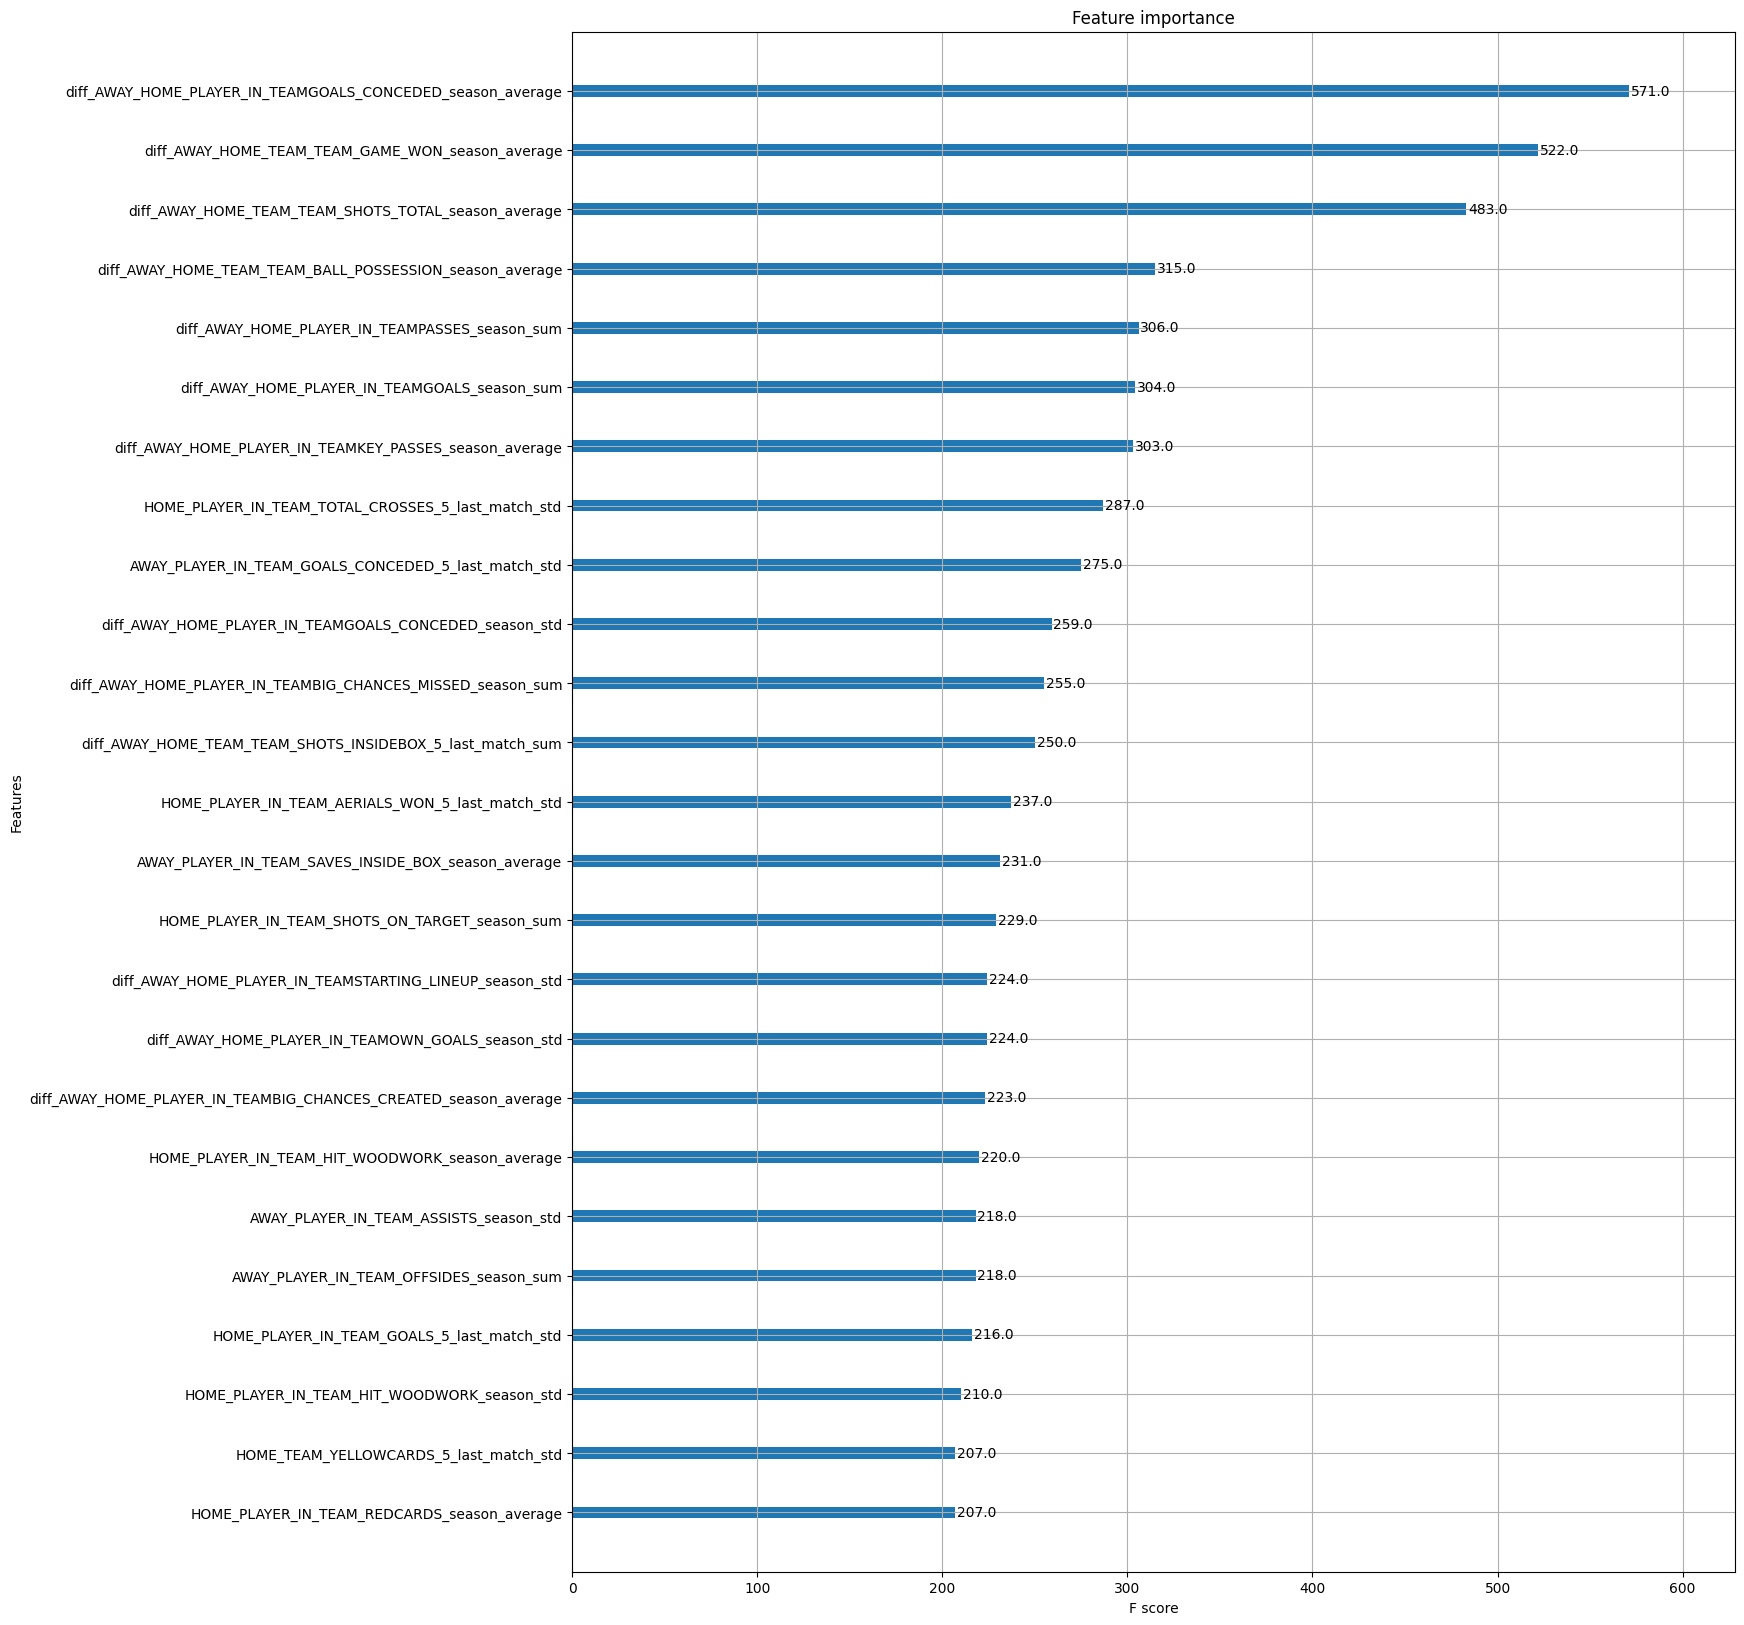

In [138]:
xgb.plot_importance(bst, max_num_features=25)
fig = plt.gcf()
fig.set_size_inches(15, 20) 

### **Model prediction and accuracy score**

In [ ]:
target = train_scores.loc[X_test.index].copy()

#Using our model

X_bench = xgb.DMatrix(X_test)

predictions = bst.predict(X_bench, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)


predictions = (predictions.rank(1,ascending=False)==1).astype(int).values

accuracy = np.round(accuracy_score(predictions,target),4)

print(accuracy)


0.5035


# Other models tested

### **LightGBM**

In [116]:
train_y = train_scores

train_y = np.argmax(train_y.values, axis=1)

X_train, X_test, y_train, y_test = model_selection.train_test_split(tableau_normalized_filtered_train2, train_y, train_size=0.8, random_state=42)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)

train_y

array([2, 1, 2, ..., 2, 0, 0])

In [ ]:
# Paramètres pour LightGBM
params_10_lgb = {
    'boosting_type': 'gbdt',          # Type de boosting, gbdt pour les arbres de décision
    'objective': 'multiclass',        # Objectif pour la classification multi-classe
    'num_class': 3,                   # Nombre de classes
    'metric': 'multi_logloss',        # Log loss pour la classification multi-classe
    'learning_rate': 0.006,           # Taux d'apprentissage plus bas pour éviter l'overfitting
    'max_depth': 5,                   # Limite de profondeur des arbres pour éviter l'overfitting
    'min_child_weight': 5,            # Réduction pour permettre des branches plus flexibles
    'lambda_l1': 0.05,                # Régularisation L1
    'lambda_l2': 1.2,                 # Régularisation L2
    'subsample': 0.75,                # Fraction d'échantillonnage pour améliorer la robustesse
    'colsample_bytree': 0.8,          # Fraction des caractéristiques utilisées pour chaque arbre
    'scale_pos_weight': 1.1,          # Ajustement léger pour équilibrer les classes
    'max_bin': 255,                   # Nombre maximum de bins utilisés dans les histogrammes
    'min_gain_to_split': 0.4,         # Gain minimal pour effectuer un split
    'verbosity': 0,                  # Désactiver les messages d'information
    'n_jobs': -1                      # Utiliser tous les cœurs disponibles
}

# Préparer les ensembles de données LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

# Entraînement avec LightGBM
num_round = 10000
model = lgb.train(
    params_10_lgb,                     # Paramètres
    train_data,                         # Jeu d'entraînement
    num_boost_round=num_round,          # Nombre d'itérations
    valid_sets=[train_data, valid_data], # Jeu d'entraînement et de validation
    valid_names=['train', 'valid'],     # Noms des jeux de données
)

In [126]:
target = train_scores.loc[X_test.index].copy()

#Using our model)

predictions = model.predict(X_test, num_iteration=model.best_iteration)

predictions = pd.DataFrame(predictions)


predictions = (predictions.rank(1,ascending=False)==1).astype(int).values

accuracy = np.round(accuracy_score(predictions,target),4)

print(accuracy)

0.4673


In [ ]:
# params_10_lgb = {
#     'boosting_type': 'gbdt',          # Type de boosting, gbdt pour les arbres de décision
#     'objective': 'multiclass',        # Objectif pour la classification multi-classe
#     'num_class': 3,                   # Nombre de classes
#     'metric': 'multi_logloss',        # Log loss pour la classification multi-classe
#     'learning_rate': 0.006,           # Taux d'apprentissage plus bas pour éviter l'overfitting
#     'max_depth': 6,                   # Limite de profondeur des arbres pour éviter l'overfitting
#     'min_child_weight': 5,            # Réduction pour permettre des branches plus flexibles
#     'lambda_l1': 0.05,                # Régularisation L1
#     'lambda_l2': 1.2,                 # Régularisation L2
#     'subsample': 0.75,                # Fraction d'échantillonnage pour améliorer la robustesse
#     'colsample_bytree': 0.8,          # Fraction des caractéristiques utilisées pour chaque arbre
#     'scale_pos_weight': 1.1,          # Ajustement léger pour équilibrer les classes
#     'max_bin': 255,                   # Nombre maximum de bins utilisés dans les histogrammes
#     'min_gain_to_split': 0.4,         # Gain minimal pour effectuer un split
#     'verbosity': 0,                  # Désactiver les messages d'information
#     'n_jobs': -1                      # Utiliser tous les cœurs disponibles  
# }
# # accuracy_score = 0.4742

# params_11_lgb = {
#     'boosting_type': 'gbdt',          # Type de boosting, gbdt pour les arbres de décision
#     'objective': 'multiclass',        # Objectif pour la classification multi-classe
#     'num_class': 3,                   # Nombre de classes
#     'metric': 'multi_logloss',        # Log loss pour la classification multi-classe
#     'learning_rate': 0.006,           # Taux d'apprentissage plus bas pour éviter l'overfitting
#     'max_depth': 5,                   # Limite de profondeur des arbres pour éviter l'overfitting
#     'min_child_weight': 5,            # Réduction pour permettre des branches plus flexibles
#     'lambda_l1': 0.05,                # Régularisation L1
#     'lambda_l2': 1.2,                 # Régularisation L2
#     'subsample': 0.75,                # Fraction d'échantillonnage pour améliorer la robustesse
#     'colsample_bytree': 0.8,          # Fraction des caractéristiques utilisées pour chaque arbre
#     'scale_pos_weight': 1.1,          # Ajustement léger pour équilibrer les classes
#     'max_bin': 255,                   # Nombre maximum de bins utilisés dans les histogrammes
#     'min_gain_to_split': 0.4,         # Gain minimal pour effectuer un split
#     'verbosity': 0,                  # Désactiver les messages d'information
#     'n_jobs': -1                      # Utiliser tous les cœurs disponibles  
# }
# # accuracy_score = 0.4803

# params_12_lgb = {
#     'boosting_type': 'gbdt',          # Type de boosting, gbdt pour les arbres de décision
#     'objective': 'multiclass',        # Objectif pour la classification multi-classe
#     'num_class': 3,                   # Nombre de classes
#     'metric': 'multi_logloss',        # Log loss pour la classification multi-classe
#     'learning_rate': 0.006,           # Taux d'apprentissage plus bas pour éviter l'overfitting
#     'max_depth': 4,                   # Limite de profondeur des arbres pour éviter l'overfitting
#     'min_child_weight': 5,            # Réduction pour permettre des branches plus flexibles
#     'lambda_l1': 0.05,                # Régularisation L1
#     'lambda_l2': 1.2,                 # Régularisation L2
#     'subsample': 0.75,                # Fraction d'échantillonnage pour améliorer la robustesse
#     'colsample_bytree': 0.8,          # Fraction des caractéristiques utilisées pour chaque arbre
#     'scale_pos_weight': 1.1,          # Ajustement léger pour équilibrer les classes
#     'max_bin': 255,                   # Nombre maximum de bins utilisés dans les histogrammes
#     'min_gain_to_split': 0.4,         # Gain minimal pour effectuer un split
#     'verbosity': 0,                  # Désactiver les messages d'information
#     'n_jobs': -1                      # Utiliser tous les cœurs disponibles  
# }
# # accuracy_score = 0.473

# params_13_lgb = {
#     'boosting_type': 'gbdt',          # Type de boosting, gbdt pour les arbres de décision
#     'objective': 'multiclass',        # Objectif pour la classification multi-classe
#     'num_class': 3,                   # Nombre de classes
#     'metric': 'multi_logloss',        # Log loss pour la classification multi-classe
#     'learning_rate': 0.006,           # Taux d'apprentissage plus bas pour éviter l'overfitting
#     'max_depth': 5,                   # Limite de profondeur des arbres pour éviter l'overfitting
#     # 'min_child_weight': 5,            # Réduction pour permettre des branches plus flexibles
#     # 'lambda_l1': 0.05,                # Régularisation L1
#     # 'lambda_l2': 1.2,                 # Régularisation L2
#     # 'subsample': 0.75,                # Fraction d'échantillonnage pour améliorer la robustesse
#     # 'colsample_bytree': 0.8,          # Fraction des caractéristiques utilisées pour chaque arbre
#     # 'scale_pos_weight': 1.1,          # Ajustement léger pour équilibrer les classes
#     # 'max_bin': 255,                   # Nombre maximum de bins utilisés dans les histogrammes
#     # 'min_gain_to_split': 0.4,         # Gain minimal pour effectuer un split
#     'verbosity': 0,                  # Désactiver les messages d'information
#     'n_jobs': -1                      # Utiliser tous les cœurs disponibles
# }
# # accuracy_score = 0.4673

### **XGB Model with y train supp**

This section focuses on training the model using `train_supp`, a dataset that represents the goal difference between home and away teams, instead of the traditional `train_scores` dataset with three categorical classes (2 for an away win, 1 for a draw, and 0 for a home win).

In [ ]:
# tableau_normalized_filtered_train enregistré en tableau
output_path = r"C:\Users\HP\Downloads\benchmark_and_extras\tableau_normalized_filtered_train.csv"
# tableau_normalized_filtered_train2.to_csv(output_path, index=True)

tableau_normalized_filtered_train2 = pd.read_csv(output_path, index_col=0)
tableau_normalized_filtered_train2

train_supp = pd.read_csv(r"C:\Users\HP\Downloads\benchmark_and_extras\Y_train_supp.csv", index_col=0)

train_y = train_supp['GOAL_DIFF_HOME_AWAY'].values
train_y 

array([-2.,  0., -1., ..., -1.,  3.,  2.])

In [42]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(tableau_normalized_filtered_train2, train_y, train_size=0.8, random_state=42)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)

train_y

array([-2.,  0., -1., ..., -1.,  3.,  2.])

In [ ]:
params_regression = {
    'booster': 'gbtree',
    'tree_method': 'hist',          # Utilisation de l'histogramme pour des performances rapides
    'max_depth': 6,                 # Réduction pour éviter l'overfitting
    'learning_rate': 0.01,          # Taux d'apprentissage plus bas pour une convergence plus stable
    'min_child_weight': 3,          # Réduction pour permettre plus de flexibilité sur les branches
    'reg_lambda': 2.0,              # Augmentation pour renforcer la régularisation L2
    'reg_alpha': 0.1,               # Légère augmentation de la régularisation L1
    'subsample': 0.85,              # Échantillonnage plus important pour une meilleure robustesse
    'colsample_bytree': 0.9,        # Échantillonnage des colonnes plus important
    'scale_pos_weight': 1.0,        # Neutralisation, car non pertinent pour la régression
    'max_delta_step': 0,            # Suppression, non utilisé pour la régression
    'gamma': 0.2,                   # Réduction pour favoriser plus de splits
    'objective': 'reg:squarederror',  # Objectif pour la régression
    'eval_metric': 'rmse',          # Toujours utiliser RMSE pour la régression
    'n_jobs': -1                    # Utilisation de tous les cœurs disponibles pour accélérer
}
d_train = xgb.DMatrix(X_train, y_train, enable_categorical=True)
d_valid = xgb.DMatrix(X_valid, y_valid, enable_categorical=True)

num_round = 10000
evallist = [(d_train, 'train'), (d_valid, 'eval')]

bst = xgb.train(params_regression, d_train, num_round, evallist, early_stopping_rounds=10)

In [57]:
target = train_scores.loc[X_test.index].copy()
#Using our model

X_bench = xgb.DMatrix(X_test)

predictions = bst.predict(X_bench, iteration_range=(0, bst.best_iteration))

# Convertir les prédictions en DataFrame avec les mêmes index que X_test
predictions = pd.DataFrame(predictions, index=X_test.index)

# Arrondir les prédictions et conserver les mêmes index
predictions_rounded = predictions.round()

# Création du DataFrame pour stocker les résultats
predicted_scores = pd.DataFrame()

# Calcul des colonnes HOME_WINS, DRAW et AWAY_WINS en fonction des prédictions arrondies
predicted_scores['HOME_WINS'] = (predictions_rounded[0] > 0).astype(int)
predicted_scores['DRAW'] = (predictions_rounded[0] == 0).astype(int)
predicted_scores['AWAY_WINS'] = (predictions_rounded[0] < 0).astype(int)

predicted_scores = (predicted_scores.rank(1,ascending=False)==1).astype(int).values

accuracy = np.round(accuracy_score(predicted_scores,target),4)

print(accuracy)

0.4055


### **XGB Model with y train supp normalised**

The `y_train_supp` values are normalised to ensure compatibility with XGBoost, as the model may not effectively handle negative values.

In [58]:
# tableau_normalized_filtered_train enregistré en tableau
output_path = r"C:\Users\HP\Downloads\benchmark_and_extras\tableau_normalized_filtered_train.csv"
# tableau_normalized_filtered_train2.to_csv(output_path, index=True)

tableau_normalized_filtered_train2 = pd.read_csv(output_path, index_col=0)
tableau_normalized_filtered_train2

train_supp = pd.read_csv(r"C:\Users\HP\Downloads\benchmark_and_extras\Y_train_supp.csv", index_col=0) #??

train_y = train_supp['GOAL_DIFF_HOME_AWAY'].values
train_y 

array([-2.,  0., -1., ..., -1.,  3.,  2.])

In [86]:
# Copier train_y pour préserver l'original
train_scaled_y = train_y.copy()
# Reshape en 2D car MinMaxScaler attend un tableau 2D
train_scaled_y = train_scaled_y.reshape(-1, 1)
# Initialiser le scaler
scaler = MinMaxScaler(feature_range=(0, 10))
# Ajuster le scaler sur les données
scaler.fit(train_scaled_y)
# Transformer les données
train_scaled_y = scaler.transform(train_scaled_y)
# Afficher les résultats
print("Train Y normalisé (2D):", train_scaled_y)
# Si nécessaire, revenir à 1D
train_scaled_y_scaled_1D = train_scaled_y.to_numpy().flatten()
print("Train Y normalisé (1D):", train_scaled_y_scaled_1D)

new_0 = 0
new_moins1 = 0
new_1 = 0

for i in range (len(train_y)) : 
    if train_y[i] == 0 :
        new_0 = train_scaled_y_scaled_1D[i]
        break
print(new_0)

for i in range (len(train_y)) : 
    if train_y[i] == -1 :
        new_moins1 = train_scaled_y_scaled_1D[i]
        break
print(new_moins1)

for i in range (len(train_y)) :     
    if train_y[i] == 1 :
        new_1 = train_scaled_y_scaled_1D[i]
        break
print(new_1)

boundary_win_draw = (new_moins1 + new_0)/2
print(boundary_win_draw)
boundary_draw_away = (new_0 + new_1 )/2
print(boundary_draw_away)

Train Y normalisé (2D): shape: (12_303, 1)
┌──────────┐
│ x0       │
│ ---      │
│ f64      │
╞══════════╡
│ 4.782609 │
│ 5.652174 │
│ 5.217391 │
│ 6.086957 │
│ 5.652174 │
│ …        │
│ 5.217391 │
│ 5.217391 │
│ 5.217391 │
│ 6.956522 │
│ 6.521739 │
└──────────┘
Train Y normalisé (1D): [4.7826087  5.65217391 5.2173913  ... 5.2173913  6.95652174 6.52173913]
5.6521739130434785
5.217391304347826
6.086956521739131
5.434782608695652
5.869565217391305


In [66]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(tableau_normalized_filtered_train2, train_scaled_y_scaled_1D, train_size=0.8, random_state=42)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)

train_scaled_y_scaled_1D

array([4.7826087 , 5.65217391, 5.2173913 , ..., 5.2173913 , 6.95652174,
       6.52173913])

In [ ]:
params_regression = {
    'booster': 'gbtree',
    'tree_method': 'hist',          # Utilisation de l'histogramme pour des performances rapides
    'max_depth': 7,                 # Réduction pour éviter l'overfitting
    'learning_rate': 0.01,          # Taux d'apprentissage plus bas pour une convergence plus stable
    'min_child_weight': 3,          # Réduction pour permettre plus de flexibilité sur les branches
    'reg_lambda': 2.0,              # Augmentation pour renforcer la régularisation L2
    'reg_alpha': 0.1,               # Légère augmentation de la régularisation L1
    'subsample': 0.85,              # Échantillonnage plus important pour une meilleure robustesse
    'colsample_bytree': 0.9,        # Échantillonnage des colonnes plus important
    'scale_pos_weight': 1.0,        # Neutralisation, car non pertinent pour la régression
    'max_delta_step': 0,            # Suppression, non utilisé pour la régression
    'gamma': 0.2,                   # Réduction pour favoriser plus de splits
    'objective': 'reg:squarederror',  # Objectif pour la régression
    'eval_metric': 'rmse',          # Toujours utiliser RMSE pour la régression
    'n_jobs': -1                    # Utilisation de tous les cœurs disponibles pour accélérer
}
d_train = xgb.DMatrix(X_train, y_train, enable_categorical=True)
d_valid = xgb.DMatrix(X_valid, y_valid, enable_categorical=True)

num_round = 10000
evallist = [(d_train, 'train'), (d_valid, 'eval')]

bst = xgb.train(params_regression, d_train, num_round, evallist, early_stopping_rounds=10)

In [95]:
target = train_scores.loc[X_test.index].copy()
#Using our model

X_bench = xgb.DMatrix(X_test)

predictions = bst.predict(X_bench, iteration_range=(0, bst.best_iteration))

# Convertir les prédictions en DataFrame avec les mêmes index que X_test
predictions = pd.DataFrame(predictions, index=X_test.index)

# Création du DataFrame pour stocker les résultats
predicted_scores = pd.DataFrame()

# Calcul des colonnes HOME_WINS, DRAW et AWAY_WINS en fonction des prédictions arrondies
predicted_scores['HOME_WINS'] = (predictions[0] >= boundary_draw_away ).astype(int)
predicted_scores['DRAW'] = ((predictions[0] > boundary_win_draw ) & (predictions[0] < boundary_draw_away )).astype(int)
predicted_scores['AWAY_WINS'] = (predictions[0] <= boundary_win_draw ).astype(int)


predicted_scores = (predicted_scores.rank(1,ascending=False)==1).astype(int).values

accuracy = np.round(accuracy_score(predicted_scores,target),4)

print(accuracy)

0.4149


### **Lightgbm with y train supp**
 


In [100]:
# tableau_normalized_filtered_train enregistré en tableau
output_path = r"C:\Users\HP\Downloads\benchmark_and_extras\tableau_normalized_filtered_train.csv"
# tableau_normalized_filtered_train2.to_csv(output_path, index=True)

tableau_normalized_filtered_train2 = pd.read_csv(output_path, index_col=0)
tableau_normalized_filtered_train2

train_supp = pd.read_csv(r"C:\Users\HP\Downloads\benchmark_and_extras\Y_train_supp.csv", index_col=0) #??

train_y = train_supp['GOAL_DIFF_HOME_AWAY'].values
train_y 

array([-2.,  0., -1., ..., -1.,  3.,  2.])

In [101]:
# Copier train_y pour préserver l'original
train_scaled_y = train_y.copy()
# Reshape en 2D car MinMaxScaler attend un tableau 2D
train_scaled_y = train_scaled_y.reshape(-1, 1)
# Initialiser le scaler
scaler = MinMaxScaler(feature_range=(0, 10))
# Ajuster le scaler sur les données
scaler.fit(train_scaled_y)
# Transformer les données
train_scaled_y = scaler.transform(train_scaled_y)
# Afficher les résultats
print("Train Y normalisé (2D):", train_scaled_y)
# Si nécessaire, revenir à 1D
train_scaled_y_scaled_1D = train_scaled_y.to_numpy().flatten()
print("Train Y normalisé (1D):", train_scaled_y_scaled_1D)

new_0 = 0
new_moins1 = 0
new_1 = 0

for i in range (len(train_y)) : 
    if train_y[i] == 0 :
        new_0 = train_scaled_y_scaled_1D[i]
        break
print(new_0)

for i in range (len(train_y)) : 
    if train_y[i] == -1 :
        new_moins1 = train_scaled_y_scaled_1D[i]
        break
print(new_moins1)

for i in range (len(train_y)) :     
    if train_y[i] == 1 :
        new_1 = train_scaled_y_scaled_1D[i]
        break
print(new_1)

boundary_win_draw = (new_moins1 + new_0)/2
print(boundary_win_draw)
boundary_draw_away = (new_0 + new_1 )/2
print(boundary_draw_away)

Train Y normalisé (2D): shape: (12_303, 1)
┌──────────┐
│ x0       │
│ ---      │
│ f64      │
╞══════════╡
│ 4.782609 │
│ 5.652174 │
│ 5.217391 │
│ 6.086957 │
│ 5.652174 │
│ …        │
│ 5.217391 │
│ 5.217391 │
│ 5.217391 │
│ 6.956522 │
│ 6.521739 │
└──────────┘
Train Y normalisé (1D): [4.7826087  5.65217391 5.2173913  ... 5.2173913  6.95652174 6.52173913]
5.6521739130434785
5.217391304347826
6.086956521739131
5.434782608695652
5.869565217391305


In [102]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(tableau_normalized_filtered_train2, train_scaled_y_scaled_1D, train_size=0.8, random_state=42)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)

train_scaled_y_scaled_1D

array([4.7826087 , 5.65217391, 5.2173913 , ..., 5.2173913 , 6.95652174,
       6.52173913])

In [ ]:
#  Paramètres pour LightGBM
params_regression_lgb = {
    'boosting_type': 'gbdt',        # Type de boosting pour LightGBM
    'objective': 'regression',       # Objectif pour la régression
    'metric': 'rmse',                # Toujours utiliser RMSE pour la régression
    'learning_rate': 0.01,           # Taux d'apprentissage
    'max_depth': 7,                  # Limite pour éviter l'overfitting
    'num_leaves': 31,                # Contrôle la complexité des arbres
    'min_data_in_leaf': 20,          # Nombre minimal de données dans une feuille
    'lambda_l1': 0.1,                # Régularisation L1
    'lambda_l2': 2.0,                # Régularisation L2
    'bagging_fraction': 0.85,        # Fraction d'échantillonnage
    'bagging_freq': 1,               # Fréquence d'échantillonnage
    'feature_fraction': 0.9,         # Fraction des colonnes échantillonnées
    'max_bin': 255,                  # Taille maximale des bins
    'min_gain_to_split': 0.2,        # Gain minimal pour permettre une séparation
    'verbosity': -1,                 # Désactiver les messages d'information
    'n_jobs': -1                     # Utilisation de tous les cœurs disponibles
}
# Préparer les ensembles de données LightGBM
d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_valid, label=y_valid, reference=d_train)

# Entraînement avec LightGBM
num_round = 10000

# Modifier la partie de l'entrainement pour spécifier early_stopping_rounds correctement
GBM = lgb.train(
    params_regression_lgb,
    d_train,
    num_boost_round=num_round,
    valid_sets=[d_train, d_valid],
    valid_names=['train', 'valid'],  # Arrêter après 10 itérations sans amélioration sur l'évaluation
)



In [114]:
target = train_scores.loc[X_test.index].copy()
#Using our model

X_bench = xgb.DMatrix(X_test)

# Pas besoin de DMatrix, LightGBM peut prédire directement sur un DataFrame ou un tableau NumPy
predictions = GBM.predict(X_test, num_iteration=GBM.best_iteration)

# Convertir les prédictions en DataFrame avec les mêmes index que X_test
predictions = pd.DataFrame(predictions, index=X_test.index)

# Création du DataFrame pour stocker les résultats
predicted_scores = pd.DataFrame()

# Calcul des colonnes HOME_WINS, DRAW et AWAY_WINS en fonction des prédictions arrondies
predicted_scores['HOME_WINS'] = (predictions[0] >= boundary_draw_away ).astype(int)
predicted_scores['DRAW'] = ((predictions[0] > boundary_win_draw ) & (predictions[0] < boundary_draw_away )).astype(int)
predicted_scores['AWAY_WINS'] = (predictions[0] <= boundary_win_draw ).astype(int)


predicted_scores = (predicted_scores.rank(1,ascending=False)==1).astype(int).values

accuracy = np.round(accuracy_score(predicted_scores,target),4)

print(accuracy)

0.4193


# Model Feature Optimisation and Diagnostics

This section focuses on evaluating the performance of the initial XGBoost model and optimising its features for improved performance. 

### **Principal Component Analysis (PCA) for dimensionality reduction**

A dimensionality reduction technique used to transform the feature space while retaining the most significant information. PCA is applied to identify patterns in the data and address multicollinearity, which can improve the robustness of the model.

**As part of my strategy, this tool lowered my accuracy score**

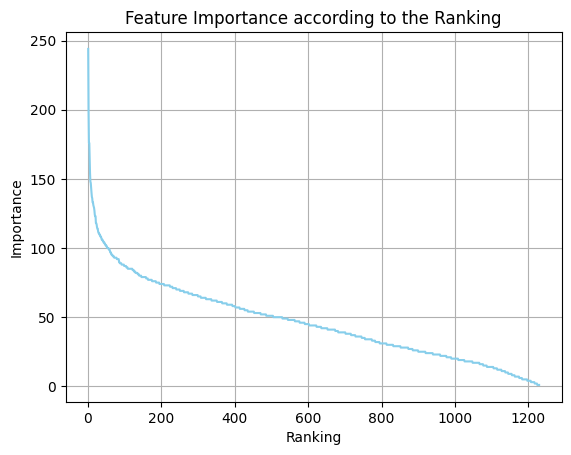

,Feature,Importance,Ranking
0,diff_AWAY_HOME_PLAYER_IN_TEAMGOALS_CONCEDED_se...,244.0,1
1,diff_AWAY_HOME_TEAM_TEAM_GAME_WON_season_average,199.0,2
2,diff_AWAY_HOME_TEAM_TEAM_SHOTS_TOTAL_season_av...,176.0,3
3,diff_AWAY_HOME_PLAYER_IN_TEAMGOALS_CONCEDED_se...,176.0,4
4,diff_AWAY_HOME_PLAYER_IN_TEAMKEY_PASSES_season...,165.0,5
...,...,...,...
215,AWAY_PLAYER_IN_TEAM_ASSISTS_5_last_match_average,73.0,216
216,HOME_TEAM_SHOTS_ON_TARGET_5_last_match_std,73.0,217
217,diff_AWAY_HOME_PLAYER_IN_TEAMERROR_LEAD_TO_GOA...,73.0,218
218,HOME_PLAYER_IN_TEAM_TACKLES_season_average,73.0,219


In [ ]:
# Récupérer les importances des features du modèle XGBoost (bst est le modèle entraîné)
feature_importance = bst.get_score(importance_type='weight')
# print("len de feature_importance:", len(feature_importance))
# Convertir en DataFrame pour une manipulation plus facile
importance_df = pd.DataFrame(list(feature_importance.items()), columns=['Feature', 'Importance'])

# Trier par ordre décroissant d'importance pour obtenir le ranking
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# # Ajouter une colonne 'Ranking' basée sur l'ordre d'importance
importance_df['Ranking'] = importance_df.index + 1  # +1 car l'index commence à 0

# Assuming importance_df_diff is already defined with columns 'Ranking' and 'Importance'
plt.plot(importance_df['Ranking'], importance_df['Importance'], color='skyblue')
plt.xlabel('Ranking')
plt.ylabel('Importance')
plt.title('Feature Importance according to the Ranking')
plt.grid(True)
plt.show()
importance_df.head(220)  #apres 218, les features ont une importance inferieure a 100

#donc faire un PCA avec 218 features

In [10]:
# Exemple d'entraînement avec un modèle (exemple XGBoost)

# Instancier PCA pour réduire à 10 composants principaux
pca = PCA(n_components=70)

# Ajuster PCA sur les données d'entraînement et les transformer
X_train_pca = pca.fit_transform(X_train)

# Appliquer la même transformation sur les données de test
X_test_pca = pca.transform(X_test)

# Si vous avez aussi un ensemble de validation, vous pouvez aussi le transformer
X_valid_pca = pca.transform(X_valid)

# Vérifiez les nouvelles formes des données réduites
print("Shape of X_train_pca:", X_train_pca.shape)
print("Shape of X_test_pca:", X_test_pca.shape)
print("Shape of X_valid_pca:", X_valid_pca.shape)

# Instancier le modèle (par exemple, un classificateur XGBoost)
params_1 = {
    'booster': 'gbtree',
    'tree_method': 'hist',
    'max_depth': 6,                # Réduit pour éviter le sur-apprentissage
    'learning_rate': 0.008,        # Légèrement réduit pour plus de précision
    'min_child_weight': 7,         # Réduit pour capturer un peu plus de détails
    'reg_lambda': 1.5,             
    'reg_alpha': 0.1,              
    'subsample': 0.85,              # Ajusté pour un compromis entre diversité et précision
    'colsample_bytree': 0.95,       # Plus de colonnes à chaque arbre
    'scale_pos_weight': 1.2,       
    'max_delta_step': 1,           
    'gamma': 0.2,                  # Nouvelle régularisation sur les splits
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'mlogloss',
}


d_train = xgb.DMatrix(X_train_pca, label=y_train)
d_valid = xgb.DMatrix(X_valid_pca, label=y_valid)

# Entraînement du modèle avec early stopping
num_round = 10000
evallist = [(d_train, 'train'), (d_valid, 'eval')]

bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=50)

# Evaluation sur le test
d_test = xgb.DMatrix(X_test_pca)
predictions = bst.predict(d_test)


In [179]:
bst.best_iteration

526

In [180]:
target = train_scores.loc[X_test.index].copy()

#Using our model

X_test_xgb = xgb.DMatrix(X_test_pca)

predictions = bst.predict(X_test_xgb, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)


predictions = (predictions.rank(1,ascending=False)==1).astype(int).values

accuracy = np.round(accuracy_score(predictions,target),4)

print(accuracy)

0.4974


### **Recursive Feature Elimination (RFE) for feature selection**

A feature selection technique that recursively removes the least important features to identify the optimal subset. This step ensures the model uses only the most relevant features, enhancing its efficiency and interpretability.

**Too time-consuming, process was interrupted**

In [ ]:
# Utiliser le modèle XGBoost comme estimateur pour RFE
model_for_rfe = XGBClassifier(**params_1)  # Adaptation des paramètres de params_1 pour XGBClassifier
rfe = RFE(estimator=model_for_rfe, n_features_to_select=20)  # Choisissez un nombre de caractéristiques souhaité

# Ajuster RFE sur l'ensemble d'entraînement
rfe.fit(X_train, y_train)

# Filtrer les colonnes sélectionnées
X_train_selected = X_train.loc[:, rfe.support_]
X_valid_selected = X_valid.loc[:, rfe.support_]
X_test_selected = X_test.loc[:, rfe.support_]

# Créer les DMatrix pour XGBoost avec les nouvelles caractéristiques sélectionnées
d_train_selected = xgb.DMatrix(X_train_selected, y_train, enable_categorical=True)
d_valid_selected = xgb.DMatrix(X_valid_selected, y_valid, enable_categorical=True)
d_test_selected = xgb.DMatrix(X_test_selected)

# Entraîner à nouveau le modèle avec les caractéristiques sélectionnées
bst_selected = xgb.train(params_1, d_train_selected, num_round, evallist, early_stopping_rounds=50)

# Prédictions sur le jeu de test
predictions_selected = bst_selected.predict(d_test_selected, iteration_range=(0, bst_selected.best_iteration))
predictions_selected = pd.DataFrame(predictions_selected)

# Calcul de l'accuracy après l'étape de RFE
predictions_selected = (predictions_selected.rank(1, ascending=False) == 1).astype(int).values
accuracy_selected = np.round(accuracy_score(predictions_selected, target), 4)
print("Accuracy with RFE:", accuracy_selected)

### **Recursive feature `diff_AWAY_HOME_` elimination after mutiple trainings of the XGBoost model**

In [ ]:
# Récupérer les importances des features du modèle XGBoost (bst est le modèle entraîné)
feature_importance = bst.get_score(importance_type='weight')
# print("len de feature_importance:", len(feature_importance))
# Convertir en DataFrame pour une manipulation plus facile
importance_df = pd.DataFrame(list(feature_importance.items()), columns=['Feature', 'Importance'])

# Trier par ordre décroissant d'importance pour obtenir le ranking
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# # Ajouter une colonne 'Ranking' basée sur l'ordre d'importance
importance_df['Ranking'] = importance_df.index + 1  # +1 car l'index commence à 0

importance_df_diff = importance_df[importance_df['Feature'].str.startswith("diff_")]

importance_df_diff.head(40)

,Feature,Importance,Ranking
8,diff_AWAY_HOME_PLAYER_IN_TEAMGOALS_CONCEDED_se...,183.0,9
10,diff_AWAY_HOME_PLAYER_IN_TEAMYELLOWCARDS_seaso...,173.0,11
13,diff_AWAY_HOME_PLAYER_IN_TEAMGOALS_CONCEDED_se...,165.0,14
16,diff_AWAY_HOME_PLAYER_IN_TEAMGOALS_CONCEDED_5_...,159.0,17
22,diff_AWAY_HOME_PLAYER_IN_TEAMMINUTES_PLAYED_se...,153.0,23
30,diff_AWAY_HOME_PLAYER_IN_TEAMSTARTING_LINEUP_s...,147.0,31
48,diff_AWAY_HOME_TEAM_TEAM_GAME_WON_season_average,128.0,49
53,diff_AWAY_HOME_PLAYER_IN_TEAMFOULS_DRAWN_5_las...,127.0,54
55,diff_AWAY_HOME_PLAYER_IN_TEAMGOALKEEPER_GOALS_...,126.0,56
56,diff_AWAY_HOME_PLAYER_IN_TEAMOWN_GOALS_season_std,126.0,57


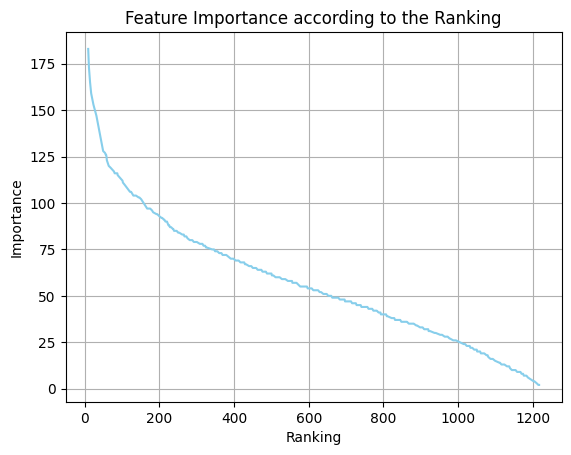

In [ ]:
# Assuming importance_df_diff is already defined with columns 'Ranking' and 'Importance'
plt.plot(importance_df_diff['Ranking'], importance_df_diff['Importance'], color='skyblue')
plt.xlabel('Ranking')
plt.ylabel('Importance')
plt.title('Feature Importance according to the Ranking')
plt.grid(True)
plt.show()

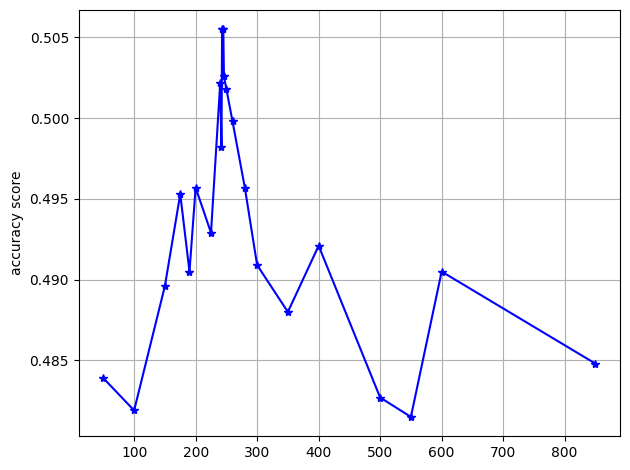

In [ ]:
X = [50,100,150,175,190,200,225,240,242,243,245,246,250,260,280,300,350,400,500, 550, 600, 850]
Y1 = [0.4839, 0.4819, 0.4896, 0.4953, 0.4905, 0.4957, 0.4929,0.5022, 0.4982, 0.5055, 0.5055, 0.5026, 0.5018, 0.4998, 0.4957, 0.4909, 0.488, 0.4921, 0.4827, 0.4815, 0.4905, 0.4848]


plt.plot(X,Y1,marker='*',color="blue")
plt.xlabel('')
plt.ylabel('accuracy score')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# On commence par identifier les colonnes "diff_" avec un classement entre 1 et 100
top_243_diff_features = importance_df_diff[
    (importance_df_diff['Feature'].str.startswith("diff_")) & 
    (importance_df_diff['Ranking'] <= 243)
]['Feature'].values

# On crée ensuite une liste de toutes les colonnes de tableau_normalized à garder
columns_to_keep = [col for col in tableau_renormalized_train.columns 
                   if not (col.startswith("diff_") and col not in top_243_diff_features)]

# On crée un nouveau DataFrame avec uniquement les colonnes à conserver
tableau_normalized_filtered_train = tableau_renormalized_train[columns_to_keep]

tableau_normalized_filtered_train

,AWAY_PLAYER_IN_TEAM_ACCURATE_CROSSES_season_sum,AWAY_PLAYER_IN_TEAM_ACCURATE_PASSES_season_sum,AWAY_PLAYER_IN_TEAM_AERIALS_WON_season_sum,AWAY_PLAYER_IN_TEAM_ASSISTS_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_CREATED_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_MISSED_season_sum,AWAY_PLAYER_IN_TEAM_BLOCKED_SHOTS_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCES_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCE_OFFLINE_season_sum,AWAY_PLAYER_IN_TEAM_DISPOSSESSED_season_sum,...,diff_AWAY_HOME_PLAYER_IN_TEAMGOALKEEPER_GOALS_CONCEDED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMGOALS_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMGOALS_CONCEDED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMMINUTES_PLAYED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMOFFSIDES_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSHOTS_BLOCKED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSHOTS_ON_TARGET_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSTARTING_LINEUP_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMTACKLES_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMYELLOWCARDS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
0,2.438563,5.375982,4.258290,2.121212,1.107692,1.393130,2.716763,3.918919,0.000000,4.127199,...,6.705993,5.327311,5.554833,5.206135,5.246551,6.254384,5.984990,4.955586,4.910128,5.854913
1,1.606805,5.521886,4.118674,1.212121,1.507692,2.824427,2.986513,4.806950,1.250000,4.803789,...,7.138413,2.671034,6.645968,8.121939,4.976789,5.136804,5.673391,7.096134,5.767017,5.530201
2,4.045369,5.937149,7.068063,2.287879,4.276923,3.721374,4.739884,5.366795,1.650000,4.140731,...,4.774559,4.685527,3.830646,3.845530,4.891534,5.145059,4.430459,4.586758,4.885913,5.143496
3,1.379962,3.075196,4.240838,1.636364,1.692308,0.992366,2.177264,4.922780,3.750000,1.759134,...,7.145376,4.757220,8.459396,4.878547,5.861577,7.201415,6.720319,4.551932,5.427629,5.512857
4,2.948960,5.982043,3.438045,3.621212,3.784615,4.446565,2.928709,6.544402,0.825000,2.571042,...,5.137025,5.028182,5.440175,6.005453,5.995562,5.343948,5.859453,5.584573,4.295639,5.975217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,2.192817,4.410774,4.188482,1.469697,1.892308,2.404580,3.930636,4.864865,0.000000,4.235453,...,3.460817,3.952541,4.433359,4.135512,5.118755,5.702059,5.522592,4.204370,5.548065,5.731764
12299,1.814745,4.466891,3.752182,0.969697,1.861538,3.778626,4.046243,4.575290,2.500000,4.167794,...,5.062968,4.712270,4.743215,5.044201,4.684868,5.067974,4.673036,4.776668,6.034431,5.479398
12300,4.064272,4.107744,4.485166,3.484848,5.830769,3.816794,3.564547,3.957529,1.250000,5.399188,...,3.779795,5.005969,3.573713,5.231999,4.654550,4.296548,4.389707,5.077100,5.405961,6.073386


In [ ]:
# Enregistre ta liste dans ton fichier.txt
with open('top_245_diff_features.txt', 'w') as f:
    for item in columns_to_keep:
        f.write(f'{item}\n')
 

In [5]:
# Récupère ta liste
with open('top_245_diff_features.txt', 'r') as f:
    columns_to_keep = f.read().splitlines()

print("columns_to_keep :", columns_to_keep)

tableau_normalized_filtered_train = tableau_renormalized_train[columns_to_keep]

In [4]:
# Récupère ta liste
with open('top_245_diff_features_vieux.txt', 'r') as f:
    columns_to_keep = f.read().splitlines()

print("columns_to_keep :", columns_to_keep)
tableau_normalized_filtered_train = tableau_renormalized_train[columns_to_keep]

In [ ]:
print(len(top_240_diff_features))  # 54
print(len(top_242_diff_features))  # 55
print(len(top_243_diff_features))  # 56
print(len(top_244_diff_features))  # 57
print(len(top_245_diff_features))  # 57
print(len(top_246_diff_features))  # 58
print(len(top_250_diff_features))  # 59
print(len(top_260_diff_features))  # 65
print(len(top_280_diff_features))  # 71
print(len(top_350_diff_features))  # 93
print(len(top_550_diff_features))  # 174
print(len(top_600_diff_features))  # 198
print(len(top_850_diff_features))  # 315

54
55
56
57
57
58
59
65
71
93
174
198
315


### **Residual plot for diagnostics**

A diagnostic tool to assess how well the model's predictions align with the actual values. The residual plot helps identify patterns or biases in the model's predictions that might require adjustment.

In [ ]:
# plot with Polars
(y_test
 .with_columns(predicted_price=cat_pipe.predict(X_test),
   residual=y_test.to_series().to_numpy() - cat_pipe.predict(X_test))
 .plot.scatter('predicted_price', 'residual', alpha=0.1, yformatter='$%.0f',
               xformatter='$%.0f')
 )

def residuals_plot(model, X_train, y_train, X_test, y_test):
    return (y_test
      .with_columns(prediction=model.predict(X_test),
        residual=y_test.to_series().to_numpy() - model.predict(X_test),
        type=pl.lit('test'))
      .vstack(y_train
        .with_columns(prediction=model.predict(X_train),
          residual=y_train.to_series().to_numpy() - model.predict(X_train),
          type=pl.lit('train'))
              )
      .reverse()
      .plot.scatter('prediction', 'residual', alpha=0.1, yformatter='$%.0f',
                    xformatter='$%.0f', by='type')
 )

residuals_plot(cat_pipe, X_train, y_train, X_test, y_test)

### **Grid Search for hyperparameter tuning**

A systematic method to fine-tune the model's hyperparameters, ensuring that the XGBoost model is optimized for maximum performance. This process searches across a predefined hyperparameter grid to identify the best combination.

In [ ]:
# Définir le modèle avec les paramètres de base
xgb_model = XGBClassifier(
    booster='gbtree',
    tree_method='hist',
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False
)

# Définir les plages de valeurs pour 'max_depth' et 'learning_rate' pour la recherche en grille
param_grid = {
    'max_depth': [6, 8, 10, 12],         # Essayez quelques valeurs de profondeur
    'learning_rate': [0.01, 0.025, 0.05, 0.1]  # Quelques valeurs de taux d'apprentissage
}

# Créer la recherche en grille avec validation croisée
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,                       # Nombre de divisions pour validation croisée
    scoring='neg_log_loss',     # Utiliser le log loss comme métrique
    verbose=1,
    n_jobs=1                   # Utiliser 1 coeur
)

# Lancer la recherche en grille sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres et le meilleur score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Meilleurs paramètres :", best_params)
print("Meilleur score (log loss) :", -best_score)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Meilleurs paramètres : {'learning_rate': 0.025, 'max_depth': 6}
Meilleur score (log loss) : 1.0263032624474635


# XGBoost Model Test for submission
We repeat the previous steps on the test data.

### **Read test data**

In [ ]:
df_test_away_team =pd.read_csv(r"C:\Users\HP\Downloads\benchmark_and_extras\Test_Data\test_away_team_statistics_df.csv", index_col=0)
df_test_home_team = pd.read_csv(r"C:\Users\HP\Downloads\benchmark_and_extras\Test_Data\test_home_team_statistics_df.csv", index_col=0)

df_test_away_player =pd.read_csv(r"C:\Users\HP\Downloads\benchmark_and_extras\Test_Data\test_away_player_statistics_df.csv")
df_test_home_player = pd.read_csv(r"C:\Users\HP\Downloads\benchmark_and_extras\Test_Data\test_home_player_statistics_df.csv")

df_test_away_team

,TEAM_SHOTS_TOTAL_season_sum,TEAM_SHOTS_INSIDEBOX_season_sum,TEAM_SHOTS_OFF_TARGET_season_sum,TEAM_SHOTS_ON_TARGET_season_sum,TEAM_SHOTS_OUTSIDEBOX_season_sum,TEAM_PASSES_season_sum,TEAM_SUCCESSFUL_PASSES_season_sum,TEAM_SAVES_season_sum,TEAM_CORNERS_season_sum,TEAM_FOULS_season_sum,...,TEAM_YELLOWCARDS_5_last_match_std,TEAM_REDCARDS_5_last_match_std,TEAM_OFFSIDES_5_last_match_std,TEAM_ATTACKS_5_last_match_std,TEAM_PENALTIES_5_last_match_std,TEAM_SUBSTITUTIONS_5_last_match_std,TEAM_BALL_SAFE_5_last_match_std,TEAM_DANGEROUS_ATTACKS_5_last_match_std,TEAM_INJURIES_5_last_match_std,TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
12303,6.0,6.0,5.0,7.0,7.0,4.0,3.0,6.0,3.0,7.0,...,6.0,0.0,1.0,4.0,0.0,8.0,7.0,2.0,7.0,0.0
12304,4.0,4.0,4.0,4.0,3.0,8.0,8.0,4.0,7.0,3.0,...,0.0,0.0,3.0,6.0,8.0,5.0,1.0,1.0,7.0,9.0
12305,1.0,1.0,2.0,2.0,2.0,6.0,5.0,4.0,2.0,2.0,...,10.0,0.0,0.0,2.0,0.0,4.0,2.0,3.0,NaN,9.0
12306,6.0,9.0,6.0,9.0,4.0,4.0,4.0,1.0,10.0,6.0,...,1.0,5.0,4.0,5.0,10.0,9.0,6.0,9.0,7.0,3.0
12307,5.0,5.0,2.0,4.0,4.0,1.0,2.0,3.0,8.0,2.0,...,3.0,0.0,6.0,5.0,0.0,4.0,3.0,10.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37666,8.0,8.0,6.0,10.0,7.0,8.0,8.0,10.0,3.0,5.0,...,5.0,0.0,5.0,4.0,5.0,0.0,3.0,10.0,5.0,10.0
37667,7.0,4.0,4.0,9.0,8.0,7.0,6.0,3.0,9.0,3.0,...,5.0,5.0,6.0,6.0,8.0,0.0,3.0,5.0,1.0,0.0
37668,3.0,4.0,2.0,3.0,1.0,1.0,1.0,3.0,4.0,5.0,...,4.0,0.0,0.0,5.0,0.0,3.0,NaN,3.0,NaN,1.0


In [ ]:
df_test_away_player

,ID,POSITION,PLAYER_ACCURATE_CROSSES_season_sum,PLAYER_ACCURATE_PASSES_season_sum,PLAYER_AERIALS_WON_season_sum,PLAYER_ASSISTS_season_sum,PLAYER_BIG_CHANCES_CREATED_season_sum,PLAYER_BIG_CHANCES_MISSED_season_sum,PLAYER_BLOCKED_SHOTS_season_sum,PLAYER_CAPTAIN_season_sum,...,PLAYER_STARTING_LINEUP_5_last_match_std,PLAYER_SUCCESSFUL_DRIBBLES_5_last_match_std,PLAYER_TACKLES_5_last_match_std,PLAYER_TOTAL_CROSSES_5_last_match_std,PLAYER_TOTAL_DUELS_5_last_match_std,PLAYER_YELLOWCARDS_5_last_match_std,PLAYER_PUNCHES_5_last_match_std,PLAYER_LONG_BALLS_5_last_match_std,PLAYER_LONG_BALLS_WON_5_last_match_std,PLAYER_SHOTS_OFF_TARGET_5_last_match_std
0,12303,defender,0.0,4.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,12303,midfielder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12303,midfielder,75.0,32.0,5.0,40.0,14.0,0.0,11.0,NaN,...,0.0,31.0,37.0,50.0,17.0,61.0,0.0,NaN,NaN,NaN
3,12303,defender,0.0,38.0,40.0,0.0,0.0,0.0,58.0,NaN,...,77.0,0.0,46.0,0.0,47.0,50.0,0.0,NaN,NaN,NaN
4,12303,goalkeeper,0.0,20.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,50.0,25.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504621,37670,NaN,6.0,13.0,0.0,0.0,5.0,10.0,0.0,NaN,...,77.0,18.0,22.0,42.0,24.0,0.0,NaN,NaN,NaN,NaN
504622,37670,NaN,1.0,4.0,4.0,7.0,11.0,5.0,0.0,NaN,...,0.0,14.0,11.0,0.0,15.0,0.0,NaN,NaN,NaN,NaN
504623,37670,midfielder,37.0,22.0,12.0,42.0,22.0,15.0,2.0,NaN,...,0.0,32.0,20.0,36.0,29.0,77.0,NaN,NaN,NaN,NaN
504624,37670,midfielder,4.0,46.0,3.0,7.0,16.0,5.0,15.0,NaN,...,0.0,55.0,33.0,0.0,13.0,94.0,NaN,NaN,NaN,NaN


### **Renaming Columns for Home and Away Teams table and Concatenating them**

In [17]:
test_home_team = df_test_home_team.copy()
test_away_team = df_test_away_team.copy()

test_home_team.columns = 'HOME_' + test_home_team.columns
test_away_team.columns = 'AWAY_' + test_away_team.columns


test_data_team =  pd.concat([test_away_team,test_home_team],join='inner',axis=1)
test_data_team

,AWAY_TEAM_SHOTS_TOTAL_season_sum,AWAY_TEAM_SHOTS_INSIDEBOX_season_sum,AWAY_TEAM_SHOTS_OFF_TARGET_season_sum,AWAY_TEAM_SHOTS_ON_TARGET_season_sum,AWAY_TEAM_SHOTS_OUTSIDEBOX_season_sum,AWAY_TEAM_PASSES_season_sum,AWAY_TEAM_SUCCESSFUL_PASSES_season_sum,AWAY_TEAM_SAVES_season_sum,AWAY_TEAM_CORNERS_season_sum,AWAY_TEAM_FOULS_season_sum,...,HOME_TEAM_YELLOWCARDS_5_last_match_std,HOME_TEAM_REDCARDS_5_last_match_std,HOME_TEAM_OFFSIDES_5_last_match_std,HOME_TEAM_ATTACKS_5_last_match_std,HOME_TEAM_PENALTIES_5_last_match_std,HOME_TEAM_SUBSTITUTIONS_5_last_match_std,HOME_TEAM_BALL_SAFE_5_last_match_std,HOME_TEAM_DANGEROUS_ATTACKS_5_last_match_std,HOME_TEAM_INJURIES_5_last_match_std,HOME_TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
12303,6.0,6.0,5.0,7.0,7.0,4.0,3.0,6.0,3.0,7.0,...,2.0,9.0,0.0,10.0,0.0,4.0,4.0,6.0,2.0,3.0
12304,4.0,4.0,4.0,4.0,3.0,8.0,8.0,4.0,7.0,3.0,...,9.0,10.0,3.0,1.0,8.0,3.0,8.0,1.0,0.0,2.0
12305,1.0,1.0,2.0,2.0,2.0,6.0,5.0,4.0,2.0,2.0,...,6.0,8.0,2.0,9.0,0.0,6.0,0.0,9.0,NaN,0.0
12306,6.0,9.0,6.0,9.0,4.0,4.0,4.0,1.0,10.0,6.0,...,4.0,5.0,2.0,3.0,8.0,0.0,2.0,2.0,2.0,3.0
12307,5.0,5.0,2.0,4.0,4.0,1.0,2.0,3.0,8.0,2.0,...,5.0,0.0,0.0,7.0,5.0,0.0,1.0,6.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37666,8.0,8.0,6.0,10.0,7.0,8.0,8.0,10.0,3.0,5.0,...,2.0,6.0,2.0,1.0,5.0,6.0,6.0,5.0,2.0,0.0
37667,7.0,4.0,4.0,9.0,8.0,7.0,6.0,3.0,9.0,3.0,...,3.0,0.0,2.0,8.0,0.0,0.0,4.0,8.0,10.0,10.0
37668,3.0,4.0,2.0,3.0,1.0,1.0,1.0,3.0,4.0,5.0,...,7.0,0.0,8.0,4.0,0.0,7.0,NaN,2.0,NaN,3.0


### **Player-Level Aggregation: Handling ≤33% NaN with KNN Imputation for Team Features**

In [ ]:
from sklearn import set_config
set_config(transform_output='polars')

# supprimer les lignes ou on a 100% de NaN info sur les joueurs
def DeletePlayerEmpty(player_table):
    player_table_cleaned = player_table.dropna(how='all', subset=player_table.columns[1:])
    return player_table_cleaned

# train_away_player_cleaned = train_away_player_cleaned[train_away_player_cleaned['ID'].isin([0, 1, 2])]
# # Obtenir les IDs uniques

def SimpleImputer_and_player_to_team_sum(player_table_cleaned, col, table_type) :
    df_copy = player_table_cleaned.copy()
    # Créer un nouveau DataFrame pour stocker les résultats
    train_HOME_OR_AWAY_PLAYER_IN_TEAM = pd.DataFrame()
    unique_ids = df_copy['ID'].unique()
    # Dictionnaire pour stocker le pourcentage de NaN pour chaque ID
    nan_percentage = {}
    summed_values = {}

    for ID in unique_ids:
        # Calculer le pourcentage de NaN dans la colonne pour chaque ID
        nan_percentage[ID] = df_copy[df_copy['ID'] == ID][col].isna().mean() * 100
            
        if nan_percentage[ID] == 0:
            # Si 0% de NaN, faire la somme directement
            summed_values[ID] = df_copy[df_copy['ID'] == ID][col].sum()
        elif 0 < nan_percentage[ID] <= 33:
            # Si 0 < pourcentage de NaN <= 33%
            # Appliquer l'imputation KNN
            imputer = KNNImputer(n_neighbors=10)
                
            # Imputer les valeurs manquantes pour ce ID
            imputed_values = imputer.fit_transform(df_copy[df_copy['ID'] == ID][[col]])
                
            # Mettre à jour le DataFrame d'origine
            df_copy.loc[df_copy['ID'] == ID, col] = imputed_values
                
            # Faire la somme après imputation
            summed_values[ID] = df_copy[df_copy['ID'] == ID][col].sum()
        else:
            # Si plus de 33% de NaN, on ne fait rien pour cette colonne
            summed_values[ID] = 'NaN'  # Ou vous pouvez choisir de mettre 'NaN'
            
    # train_HOME_OR_AWAY_PLAYER_IN_TEAM['ID'] = unique_ids
    if "away" in table_type :
        new_col_name = col.replace("PLAYER", "AWAY_PLAYER_IN_TEAM")
    elif "home" in table_type :
        new_col_name = col.replace("PLAYER", "HOME_PLAYER_IN_TEAM")
    else:
        new_col_name = col
    train_HOME_OR_AWAY_PLAYER_IN_TEAM[new_col_name] = [summed_values.get(ID, 'NaN') for ID in unique_ids]
    # train_HOME_OR_AWAY_PLAYER_IN_TEAM.reset_index(drop=True, inplace=True)
    return train_HOME_OR_AWAY_PLAYER_IN_TEAM

def SimpleImputer_and_player_to_team_mean(player_table_cleaned, col, table_type) :
    df_copy = player_table_cleaned.copy()
    # Créer un nouveau DataFrame pour stocker les résultats
    train_HOME_OR_AWAY_PLAYER_IN_TEAM = pd.DataFrame()
    unique_ids = df_copy['ID'].unique()
    nan_percentage = {}
    averaged_values = {}

    for ID in unique_ids:
        # Calculer le pourcentage de NaN dans la colonne pour chaque ID
        nan_percentage[ID] = df_copy[df_copy['ID'] == ID][col].isna().mean() * 100
            
        if nan_percentage[ID] == 0:
            # Si 0% de NaN, faire la moyenne directement
            averaged_values[ID] = df_copy[df_copy['ID'] == ID][col].mean()
        elif 0 < nan_percentage[ID] <= 33:
            # Si 0 < pourcentage de NaN <= 33%
            # Appliquer l'imputation KNN
            imputer = KNNImputer(n_neighbors=10)
                
            # Imputer les valeurs manquantes pour ce ID
            imputed_values = imputer.fit_transform(df_copy[df_copy['ID'] == ID][[col]])
                
            # Mettre à jour le DataFrame d'origine
            df_copy.loc[df_copy['ID'] == ID, col] = imputed_values
                
            # Faire la moyenne après imputation
            averaged_values[ID] = df_copy[df_copy['ID'] == ID][col].mean()
        else:
            # Si plus de 33% de NaN, on ne fait rien pour cette colonne
            averaged_values[ID] = 'NaN'  # Ou vous pouvez choisir de mettre 'NaN'

    # train_HOME_OR_AWAY_PLAYER_IN_TEAM['ID'] = unique_ids
    if "away" in table_type :
        new_col_name = col.replace("PLAYER", "AWAY_PLAYER_IN_TEAM")
    elif "home" in table_type :
        new_col_name = col.replace("PLAYER", "HOME_PLAYER_IN_TEAM")
    else:
        new_col_name = col
    train_HOME_OR_AWAY_PLAYER_IN_TEAM[new_col_name] = [averaged_values.get(ID, 'NaN') for ID in unique_ids]
    # train_HOME_OR_AWAY_PLAYER_IN_TEAM.reset_index(drop=True, inplace=True)
    return train_HOME_OR_AWAY_PLAYER_IN_TEAM

def SimpleImputer_and_player_to_team_SD(player_table_cleaned, col, table_type) :
    df_copy = player_table_cleaned.copy()
    # Créer un nouveau DataFrame pour stocker les résultats
    train_HOME_OR_AWAY_PLAYER_IN_TEAM = pd.DataFrame()
    unique_ids = df_copy['ID'].unique()
    nan_percentage = {}
    standardized_values = {}

    for ID in unique_ids:
        # Calculer le pourcentage de NaN dans la colonne pour chaque ID
        nan_percentage[ID] = df_copy[df_copy['ID'] == ID][col].isna().mean() * 100
            
        if nan_percentage[ID] == 0:
            # Si 0% de NaN, faire la moyenne directement
            standardized_values[ID] = df_copy[df_copy['ID'] == ID][col].std()
        elif 0 < nan_percentage[ID] <= 33:
            # Si 0 < pourcentage de NaN <= 33%
            # Appliquer l'imputation KNN
            imputer = KNNImputer(n_neighbors=10)
                
            # Imputer les valeurs manquantes pour ce ID
            imputed_values = imputer.fit_transform(df_copy[df_copy['ID'] == ID][[col]])
                
            # Mettre à jour le DataFrame d'origine
            df_copy.loc[df_copy['ID'] == ID, col] = imputed_values
                
            # Faire la moyenne après imputation
            standardized_values[ID] = df_copy[df_copy['ID'] == ID][col].std()
        else:
            # Si plus de 33% de NaN, on ne fait rien pour cette colonne
            standardized_values[ID] = 'NaN'  # Ou vous pouvez choisir de mettre 'NaN'
            
    # train_HOME_OR_AWAY_PLAYER_IN_TEAM['ID'] = unique_ids
    if "away" in table_type :
        new_col_name = col.replace("PLAYER", "AWAY_PLAYER_IN_TEAM")
    elif "home" in table_type :
        new_col_name = col.replace("PLAYER", "HOME_PLAYER_IN_TEAM")
    else:
        new_col_name = col
    train_HOME_OR_AWAY_PLAYER_IN_TEAM[new_col_name] = [standardized_values.get(ID, 'NaN') for ID in unique_ids]
    # train_HOME_OR_AWAY_PLAYER_IN_TEAM.reset_index(drop=True, inplace=True)
    return train_HOME_OR_AWAY_PLAYER_IN_TEAM


# train_AWAY_PLAYER_IN_TEAM = SimpleImputer_and_player_to_team_sum(train_away_player_cleaned) 
# train_AWAY_PLAYER_IN_TEAM

In [ ]:
# Transformer chaque colonne en parallèle
def process_columns_in_parallel(df, func, columns,  table_type):
    # Utiliser Joblib pour exécuter chaque fonction pour chaque colonne en parallèle
    results = Parallel(n_jobs=-1)(delayed(func)(df, col, table_type) for col in columns)
    # Combiner les résultats dans un DataFrame final
    final_result = pd.concat(results, axis=1)
    return final_result

#AWAY
test_away_player = df_test_away_player.iloc[:, [0] + list(range(2, df_test_away_player.shape[1]))] #suppr colonne position 
test_away_player_cleaned = DeletePlayerEmpty(test_away_player)
#test_away_player_cleaned = test_away_player_cleaned[test_away_player_cleaned['ID'].isin([12303, 12304, 12305])]


columns_away_sum = [col for col in test_away_player_cleaned.columns if col.endswith('_sum') and col != 'ID']
columns_away_mean = [col for col in test_away_player_cleaned.columns if col.endswith('_average') and col != 'ID']
columns_away_std = [col for col in test_away_player_cleaned.columns if col.endswith('_std') and col != 'ID']

#### Appliquer la fonction sur chaque groupe de colonnes avec leurs transformateurs
table_type_away = "away"
result_away_sum = process_columns_in_parallel(test_away_player_cleaned, SimpleImputer_and_player_to_team_sum, columns_away_sum, table_type_away)
result_away_mean = process_columns_in_parallel(test_away_player_cleaned, SimpleImputer_and_player_to_team_mean, columns_away_mean, table_type_away)
result_away_std = process_columns_in_parallel(test_away_player_cleaned, SimpleImputer_and_player_to_team_SD, columns_away_std, table_type_away)

#HOME
test_home_player = df_test_home_player.iloc[:, [0] + list(range(2, df_test_home_player.shape[1]))] #suppr colonne position 
test_home_player_cleaned = DeletePlayerEmpty(test_home_player)
#test_home_player_cleaned = test_home_player_cleaned[test_home_player_cleaned['ID'].isin([12303, 12304, 12305])]

columns_home_sum = [col for col in test_home_player_cleaned.columns if col.endswith('_sum') and col != 'ID']
columns_home_mean = [col for col in test_home_player_cleaned.columns if col.endswith('_average') and col != 'ID']
columns_home_std = [col for col in test_home_player_cleaned.columns if col.endswith('_std') and col != 'ID']

#### Appliquer la fonction sur chaque groupe de colonnes avec leurs transformateurs
table_type_home = "home"
result_home_sum = process_columns_in_parallel(test_home_player_cleaned, SimpleImputer_and_player_to_team_sum, columns_home_sum, table_type_home)
result_home_mean = process_columns_in_parallel(test_home_player_cleaned, SimpleImputer_and_player_to_team_mean, columns_home_mean, table_type_home)
result_home_std = process_columns_in_parallel(test_home_player_cleaned, SimpleImputer_and_player_to_team_SD, columns_home_std, table_type_home)

# Fusionner tous les résultats dans un seul DataFrame
# Garder uniquement les valeurs uniques de la colonne 0 et conserver le résultat comme un DataFrame
colonneID = df_test_away_player[[df_test_away_player.columns[0]]].drop_duplicates().reset_index(drop=True)
#colonneID = colonneID[colonneID['ID'].isin([12303.0, 12304.0, 12305.0])]
final_transformed_data = pd.concat([colonneID, result_away_sum, result_away_mean, result_away_std, result_home_sum, result_home_mean, result_home_std], axis=1)
final_transformed_data

,ID,AWAY_PLAYER_IN_TEAM_ACCURATE_CROSSES_season_sum,AWAY_PLAYER_IN_TEAM_ACCURATE_PASSES_season_sum,AWAY_PLAYER_IN_TEAM_AERIALS_WON_season_sum,AWAY_PLAYER_IN_TEAM_ASSISTS_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_CREATED_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_MISSED_season_sum,AWAY_PLAYER_IN_TEAM_BLOCKED_SHOTS_season_sum,AWAY_PLAYER_IN_TEAM_CAPTAIN_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCES_season_sum,...,HOME_PLAYER_IN_TEAM_STARTING_LINEUP_5_last_match_std,HOME_PLAYER_IN_TEAM_SUCCESSFUL_DRIBBLES_5_last_match_std,HOME_PLAYER_IN_TEAM_TACKLES_5_last_match_std,HOME_PLAYER_IN_TEAM_TOTAL_CROSSES_5_last_match_std,HOME_PLAYER_IN_TEAM_TOTAL_DUELS_5_last_match_std,HOME_PLAYER_IN_TEAM_YELLOWCARDS_5_last_match_std,HOME_PLAYER_IN_TEAM_PUNCHES_5_last_match_std,HOME_PLAYER_IN_TEAM_LONG_BALLS_5_last_match_std,HOME_PLAYER_IN_TEAM_LONG_BALLS_WON_5_last_match_std,HOME_PLAYER_IN_TEAM_SHOTS_OFF_TARGET_5_last_match_std
0,12303,135.0,352.0,223.0,80.0,56.0,44.0,196.0,NaN,159.0,...,33.406586,15.278073,21.650701,20.69879,17.660569,25.784648,6.649638,NaN,NaN,NaN
1,12304,87.0,491.0,151.0,159.0,203.0,73.0,103.0,NaN,140.0,...,14.823529,10.002768,15.146345,10.460339,19.012289,30.226137,14.352941,0.0,0.0,0.0
2,12305,98.0,474.0,166.0,158.0,119.0,76.0,116.0,NaN,226.0,...,29.233844,10.085663,15.535775,25.781605,17.414497,29.393377,7.518604,0.0,0.0,0.0
3,12306,181.0,479.0,420.0,226.0,202.0,76.0,209.0,NaN,318.0,...,30.957751,21.032887,21.024496,16.518261,16.398729,27.525686,NaN,NaN,NaN,NaN
4,12307,173.0,409.0,304.0,86.0,211.0,161.0,281.0,NaN,303.0,...,31.568553,26.574811,13.252636,12.657101,21.226284,33.431009,17.14289,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25363,37666,198.0,596.0,155.0,225.0,181.0,240.0,243.0,NaN,282.0,...,36.921021,10.883744,14.438001,14.851718,22.237935,32.09768,NaN,NaN,NaN,NaN
25364,37667,132.0,431.0,314.0,280.0,140.0,200.0,185.0,NaN,222.0,...,38.357512,NaN,19.894745,18.167153,14.954838,32.945317,NaN,NaN,NaN,NaN
25365,37668,139.0,339.0,270.0,210.0,143.0,120.0,178.0,NaN,351.0,...,34.896907,16.788671,17.05786,13.686619,14.883425,14.093061,23.570226,23.692267,19.046297,22.97377
25366,37669,103.0,351.0,227.0,248.0,190.0,128.0,162.0,NaN,239.0,...,34.747086,4.489989,18.952103,9.636505,25.703956,29.698485,0.0,NaN,NaN,NaN


In [13]:
# Enregistrer le DataFrame dans un fichier CSV avec "ID" comme nom pour les index
output_path = r"C:\Users\HP\Downloads\benchmark_and_extras\test_PLAYER_IN_TEAM_33KNN_per_ID.csv"
# final_transformed_data.to_csv(output_path, index=False)
tableau_33KNN_per_ID = pd.read_csv(output_path, index_col=0)

In [14]:
tableau_33KNN_per_ID

,AWAY_PLAYER_IN_TEAM_ACCURATE_CROSSES_season_sum,AWAY_PLAYER_IN_TEAM_ACCURATE_PASSES_season_sum,AWAY_PLAYER_IN_TEAM_AERIALS_WON_season_sum,AWAY_PLAYER_IN_TEAM_ASSISTS_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_CREATED_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_MISSED_season_sum,AWAY_PLAYER_IN_TEAM_BLOCKED_SHOTS_season_sum,AWAY_PLAYER_IN_TEAM_CAPTAIN_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCES_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCE_OFFLINE_season_sum,...,HOME_PLAYER_IN_TEAM_STARTING_LINEUP_5_last_match_std,HOME_PLAYER_IN_TEAM_SUCCESSFUL_DRIBBLES_5_last_match_std,HOME_PLAYER_IN_TEAM_TACKLES_5_last_match_std,HOME_PLAYER_IN_TEAM_TOTAL_CROSSES_5_last_match_std,HOME_PLAYER_IN_TEAM_TOTAL_DUELS_5_last_match_std,HOME_PLAYER_IN_TEAM_YELLOWCARDS_5_last_match_std,HOME_PLAYER_IN_TEAM_PUNCHES_5_last_match_std,HOME_PLAYER_IN_TEAM_LONG_BALLS_5_last_match_std,HOME_PLAYER_IN_TEAM_LONG_BALLS_WON_5_last_match_std,HOME_PLAYER_IN_TEAM_SHOTS_OFF_TARGET_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
12303,135.0,352.0,223.0,80.0,56.0,44.0,196.0,NaN,159.0,0.0,...,33.406586,15.278073,21.650701,20.698790,17.660569,25.784648,6.649638,NaN,NaN,NaN
12304,87.0,491.0,151.0,159.0,203.0,73.0,103.0,NaN,140.0,0.0,...,14.823529,10.002768,15.146345,10.460339,19.012289,30.226137,14.352941,0.000000,0.000000,0.00000
12305,98.0,474.0,166.0,158.0,119.0,76.0,116.0,NaN,226.0,25.0,...,29.233844,10.085663,15.535775,25.781605,17.414497,29.393377,7.518604,0.000000,0.000000,0.00000
12306,181.0,479.0,420.0,226.0,202.0,76.0,209.0,NaN,318.0,33.0,...,30.957751,21.032887,21.024496,16.518261,16.398729,27.525686,NaN,NaN,NaN,NaN
12307,173.0,409.0,304.0,86.0,211.0,161.0,281.0,NaN,303.0,100.0,...,31.568553,26.574811,13.252636,12.657101,21.226284,33.431009,17.142890,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37666,198.0,596.0,155.0,225.0,181.0,240.0,243.0,NaN,282.0,0.0,...,36.921021,10.883744,14.438001,14.851718,22.237935,32.097680,NaN,NaN,NaN,NaN
37667,132.0,431.0,314.0,280.0,140.0,200.0,185.0,NaN,222.0,0.0,...,38.357512,NaN,19.894745,18.167153,14.954838,32.945317,NaN,NaN,NaN,NaN
37668,139.0,339.0,270.0,210.0,143.0,120.0,178.0,NaN,351.0,99.0,...,34.896907,16.788671,17.057860,13.686619,14.883425,14.093061,23.570226,23.692267,19.046297,22.97377


### **Dataset Merging: Concatenating KNN Imputed and Team Data**

In [19]:
test_data =  pd.concat([tableau_33KNN_per_ID,test_data_team],join='inner',axis=1)
test_data

,AWAY_PLAYER_IN_TEAM_ACCURATE_CROSSES_season_sum,AWAY_PLAYER_IN_TEAM_ACCURATE_PASSES_season_sum,AWAY_PLAYER_IN_TEAM_AERIALS_WON_season_sum,AWAY_PLAYER_IN_TEAM_ASSISTS_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_CREATED_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_MISSED_season_sum,AWAY_PLAYER_IN_TEAM_BLOCKED_SHOTS_season_sum,AWAY_PLAYER_IN_TEAM_CAPTAIN_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCES_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCE_OFFLINE_season_sum,...,HOME_TEAM_YELLOWCARDS_5_last_match_std,HOME_TEAM_REDCARDS_5_last_match_std,HOME_TEAM_OFFSIDES_5_last_match_std,HOME_TEAM_ATTACKS_5_last_match_std,HOME_TEAM_PENALTIES_5_last_match_std,HOME_TEAM_SUBSTITUTIONS_5_last_match_std,HOME_TEAM_BALL_SAFE_5_last_match_std,HOME_TEAM_DANGEROUS_ATTACKS_5_last_match_std,HOME_TEAM_INJURIES_5_last_match_std,HOME_TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
12303,135.0,352.0,223.0,80.0,56.0,44.0,196.0,NaN,159.0,0.0,...,2.0,9.0,0.0,10.0,0.0,4.0,4.0,6.0,2.0,3.0
12304,87.0,491.0,151.0,159.0,203.0,73.0,103.0,NaN,140.0,0.0,...,9.0,10.0,3.0,1.0,8.0,3.0,8.0,1.0,0.0,2.0
12305,98.0,474.0,166.0,158.0,119.0,76.0,116.0,NaN,226.0,25.0,...,6.0,8.0,2.0,9.0,0.0,6.0,0.0,9.0,NaN,0.0
12306,181.0,479.0,420.0,226.0,202.0,76.0,209.0,NaN,318.0,33.0,...,4.0,5.0,2.0,3.0,8.0,0.0,2.0,2.0,2.0,3.0
12307,173.0,409.0,304.0,86.0,211.0,161.0,281.0,NaN,303.0,100.0,...,5.0,0.0,0.0,7.0,5.0,0.0,1.0,6.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37666,198.0,596.0,155.0,225.0,181.0,240.0,243.0,NaN,282.0,0.0,...,2.0,6.0,2.0,1.0,5.0,6.0,6.0,5.0,2.0,0.0
37667,132.0,431.0,314.0,280.0,140.0,200.0,185.0,NaN,222.0,0.0,...,3.0,0.0,2.0,8.0,0.0,0.0,4.0,8.0,10.0,10.0
37668,139.0,339.0,270.0,210.0,143.0,120.0,178.0,NaN,351.0,99.0,...,7.0,0.0,8.0,4.0,0.0,7.0,NaN,2.0,NaN,3.0


### **Dropping Columns with More than 30% Missing Values**

In [ ]:
# Récupère ta liste
with open(r"C:\Users\HP\Downloads\benchmark_and_extras\columns_to_drop", 'r') as f:
    columns_to_drop_test = f.read().splitlines()

print("columns_to_drop_test :", columns_to_drop_test)

In [21]:
# threshold = 0.3 * len(test_data) #longueur d'une colonne (nombre de lignes)
# non_missing_counts = test_data.count() # print(non_missing_counts)
# nb_valeurs_manquantes = len(test_data) - non_missing_counts 

# columns_to_drop_test2 = nb_valeurs_manquantes[nb_valeurs_manquantes > threshold].index

# print("len(columns_to_drop_test2) :",len(columns_to_drop_test2))
test_data.drop(columns=columns_to_drop_test, inplace=True)
print("len(columns_to_drop_test) :",len(columns_to_drop_test))
test_data

len(columns_to_drop_test) : 62


,AWAY_PLAYER_IN_TEAM_ACCURATE_CROSSES_season_sum,AWAY_PLAYER_IN_TEAM_ACCURATE_PASSES_season_sum,AWAY_PLAYER_IN_TEAM_AERIALS_WON_season_sum,AWAY_PLAYER_IN_TEAM_ASSISTS_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_CREATED_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_MISSED_season_sum,AWAY_PLAYER_IN_TEAM_BLOCKED_SHOTS_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCES_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCE_OFFLINE_season_sum,AWAY_PLAYER_IN_TEAM_DISPOSSESSED_season_sum,...,HOME_TEAM_YELLOWCARDS_5_last_match_std,HOME_TEAM_REDCARDS_5_last_match_std,HOME_TEAM_OFFSIDES_5_last_match_std,HOME_TEAM_ATTACKS_5_last_match_std,HOME_TEAM_PENALTIES_5_last_match_std,HOME_TEAM_SUBSTITUTIONS_5_last_match_std,HOME_TEAM_BALL_SAFE_5_last_match_std,HOME_TEAM_DANGEROUS_ATTACKS_5_last_match_std,HOME_TEAM_INJURIES_5_last_match_std,HOME_TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
12303,135.0,352.0,223.0,80.0,56.0,44.0,196.0,159.0,0.0,311.0,...,2.0,9.0,0.0,10.0,0.0,4.0,4.0,6.0,2.0,3.0
12304,87.0,491.0,151.0,159.0,203.0,73.0,103.0,140.0,0.0,358.0,...,9.0,10.0,3.0,1.0,8.0,3.0,8.0,1.0,0.0,2.0
12305,98.0,474.0,166.0,158.0,119.0,76.0,116.0,226.0,25.0,213.0,...,6.0,8.0,2.0,9.0,0.0,6.0,0.0,9.0,NaN,0.0
12306,181.0,479.0,420.0,226.0,202.0,76.0,209.0,318.0,33.0,290.0,...,4.0,5.0,2.0,3.0,8.0,0.0,2.0,2.0,2.0,3.0
12307,173.0,409.0,304.0,86.0,211.0,161.0,281.0,303.0,100.0,273.0,...,5.0,0.0,0.0,7.0,5.0,0.0,1.0,6.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37666,198.0,596.0,155.0,225.0,181.0,240.0,243.0,282.0,0.0,272.0,...,2.0,6.0,2.0,1.0,5.0,6.0,6.0,5.0,2.0,0.0
37667,132.0,431.0,314.0,280.0,140.0,200.0,185.0,222.0,0.0,276.0,...,3.0,0.0,2.0,8.0,0.0,0.0,4.0,8.0,10.0,10.0
37668,139.0,339.0,270.0,210.0,143.0,120.0,178.0,351.0,99.0,198.0,...,7.0,0.0,8.0,4.0,0.0,7.0,NaN,2.0,NaN,3.0


In [ ]:
# Filtrer les colonnes de `cols_in_common` qui sont bien présentes dans `test_data`
cols_in_common_in_test_data = [col for col in cols_in_common if col in test_data.columns]

# Calculer le pourcentage de NaN pour chaque colonne de `cols_in_common_in_test_data`
nan_percentages = test_data[cols_in_common_in_test_data].isna().mean() * 100

# Afficher le résultat
print("Pourcentage de NaN dans les colonnes de 'cols_in_common' présentes dans 'test_data' :")
print(nan_percentages)

### **Missing Data Imputation: Mean Imputation for Train Data**

In [ ]:
from sklearn import set_config
set_config(transform_output='polars')

test_data_imputed =test_data.copy()
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
                
# Imputer les valeurs manquantes pour ce ID
imputed_values = imputer.fit_transform(test_data_imputed)
                
# Mettre à jour le DataFrame d'origine
test_data_imputed.loc[:] = imputed_values

# Vérifier le nombre de NaN après imputation
total_nan_after = test_data_imputed.isnull().sum().sum()
print("Nombre total de NaN dans train_data_imputed :", total_nan_after)
test_data_imputed

Nombre total de NaN dans train_data_imputed : 0


,AWAY_PLAYER_IN_TEAM_ACCURATE_CROSSES_season_sum,AWAY_PLAYER_IN_TEAM_ACCURATE_PASSES_season_sum,AWAY_PLAYER_IN_TEAM_AERIALS_WON_season_sum,AWAY_PLAYER_IN_TEAM_ASSISTS_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_CREATED_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_MISSED_season_sum,AWAY_PLAYER_IN_TEAM_BLOCKED_SHOTS_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCES_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCE_OFFLINE_season_sum,AWAY_PLAYER_IN_TEAM_DISPOSSESSED_season_sum,...,HOME_TEAM_YELLOWCARDS_5_last_match_std,HOME_TEAM_REDCARDS_5_last_match_std,HOME_TEAM_OFFSIDES_5_last_match_std,HOME_TEAM_ATTACKS_5_last_match_std,HOME_TEAM_PENALTIES_5_last_match_std,HOME_TEAM_SUBSTITUTIONS_5_last_match_std,HOME_TEAM_BALL_SAFE_5_last_match_std,HOME_TEAM_DANGEROUS_ATTACKS_5_last_match_std,HOME_TEAM_INJURIES_5_last_match_std,HOME_TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
12303,135.0,352.0,223.0,80.0,56.0,44.0,196.0,159.0,0.0,311.0,...,2.0,9.0,0.0,10.0,0.0,4.0,4.000000,6.0,2.000000,3.0
12304,87.0,491.0,151.0,159.0,203.0,73.0,103.0,140.0,0.0,358.0,...,9.0,10.0,3.0,1.0,8.0,3.0,8.000000,1.0,0.000000,2.0
12305,98.0,474.0,166.0,158.0,119.0,76.0,116.0,226.0,25.0,213.0,...,6.0,8.0,2.0,9.0,0.0,6.0,0.000000,9.0,3.777261,0.0
12306,181.0,479.0,420.0,226.0,202.0,76.0,209.0,318.0,33.0,290.0,...,4.0,5.0,2.0,3.0,8.0,0.0,2.000000,2.0,2.000000,3.0
12307,173.0,409.0,304.0,86.0,211.0,161.0,281.0,303.0,100.0,273.0,...,5.0,0.0,0.0,7.0,5.0,0.0,1.000000,6.0,7.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37666,198.0,596.0,155.0,225.0,181.0,240.0,243.0,282.0,0.0,272.0,...,2.0,6.0,2.0,1.0,5.0,6.0,6.000000,5.0,2.000000,0.0
37667,132.0,431.0,314.0,280.0,140.0,200.0,185.0,222.0,0.0,276.0,...,3.0,0.0,2.0,8.0,0.0,0.0,4.000000,8.0,10.000000,10.0
37668,139.0,339.0,270.0,210.0,143.0,120.0,178.0,351.0,99.0,198.0,...,7.0,0.0,8.0,4.0,0.0,7.0,3.642403,2.0,3.777261,3.0


### **Data Normalisation: Scaling Features to a [0, 10] Range**

In [111]:
print(test_data_team.min().min())
print(test_data_team.max().max())

0.0
10.0


In [24]:
# Normalisation des nouvelles données de 0 à 10 comme les données team

# Fonction de normalisation pour chaque colonne
def normalize_column_to_range(df, target_min, target_max):
    # On copie le DataFrame pour ne pas modifier l'original
    df_normalized = df.copy()
    
    for col in df_normalized.columns:
        min_val = df_normalized[col].min(skipna=True)  # Minimum sans NaN
        max_val = df_normalized[col].max(skipna=True)  # Maximum sans NaN
        
        # Normalisation entre target_min et target_max uniquement si min != max
        if min_val != max_val:
            df_normalized[col] = ((df_normalized[col] - min_val) / (max_val - min_val)) * (target_max - target_min) + target_min

    return df_normalized


tableau_normalized_test = normalize_column_to_range(test_data_imputed, test_data_team.min().min(), test_data_team.max().max())

print(tableau_normalized_test.min().min())
print(tableau_normalized_test.max().max())

0.0
10.0


In [26]:
tableau_normalized_test

,AWAY_PLAYER_IN_TEAM_ACCURATE_CROSSES_season_sum,AWAY_PLAYER_IN_TEAM_ACCURATE_PASSES_season_sum,AWAY_PLAYER_IN_TEAM_AERIALS_WON_season_sum,AWAY_PLAYER_IN_TEAM_ASSISTS_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_CREATED_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_MISSED_season_sum,AWAY_PLAYER_IN_TEAM_BLOCKED_SHOTS_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCES_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCE_OFFLINE_season_sum,AWAY_PLAYER_IN_TEAM_DISPOSSESSED_season_sum,...,HOME_TEAM_YELLOWCARDS_5_last_match_std,HOME_TEAM_REDCARDS_5_last_match_std,HOME_TEAM_OFFSIDES_5_last_match_std,HOME_TEAM_ATTACKS_5_last_match_std,HOME_TEAM_PENALTIES_5_last_match_std,HOME_TEAM_SUBSTITUTIONS_5_last_match_std,HOME_TEAM_BALL_SAFE_5_last_match_std,HOME_TEAM_DANGEROUS_ATTACKS_5_last_match_std,HOME_TEAM_INJURIES_5_last_match_std,HOME_TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
12303,2.842105,3.655244,3.333333,1.123596,0.933333,0.926316,3.798450,3.057692,0.000000,3.769697,...,2.0,9.0,0.0,10.0,0.0,4.0,4.000000,6.0,2.000000,3.0
12304,1.831579,5.098650,2.257100,2.233146,3.383333,1.536842,1.996124,2.692308,0.000000,4.339394,...,9.0,10.0,3.0,1.0,8.0,3.0,8.000000,1.0,0.000000,2.0
12305,2.063158,4.922118,2.481315,2.219101,1.983333,1.600000,2.248062,4.346154,0.555556,2.581818,...,6.0,8.0,2.0,9.0,0.0,6.0,0.000000,9.0,3.777261,0.0
12306,3.810526,4.974039,6.278027,3.174157,3.366667,1.600000,4.050388,6.115385,0.733333,3.515152,...,4.0,5.0,2.0,3.0,8.0,0.0,2.000000,2.0,2.000000,3.0
12307,3.642105,4.247144,4.544096,1.207865,3.516667,3.389474,5.445736,5.826923,2.222222,3.309091,...,5.0,0.0,0.0,7.0,5.0,0.0,1.000000,6.0,7.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37666,4.168421,6.188993,2.316891,3.160112,3.016667,5.052632,4.709302,5.423077,0.000000,3.296970,...,2.0,6.0,2.0,1.0,5.0,6.0,6.000000,5.0,2.000000,0.0
37667,2.778947,4.475597,4.693572,3.932584,2.333333,4.210526,3.585271,4.269231,0.000000,3.345455,...,3.0,0.0,2.0,8.0,0.0,0.0,4.000000,8.0,10.000000,10.0
37668,2.926316,3.520249,4.035874,2.949438,2.383333,2.526316,3.449612,6.750000,2.200000,2.400000,...,7.0,0.0,8.0,4.0,0.0,7.0,3.642403,2.0,3.777261,3.0


### **Adding "Away vs. Home" Differences for Teams and Players**

In [28]:
# caputer dans une liste 'col_name_team" les noms des colonnes du fichier df_train_home_team
team_table = df_test_away_team.copy()
col_name_team = team_table.columns.to_list()

missing_columns_team = []
away_home_team_diff = pd.DataFrame()

for col in col_name_team :  
    # take the colonne from train_data named "AWAY_" + col
    away_column_name = 'AWAY_' + col
    # take the colonne from train_data named "HOME_" + col
    home_column_name = 'HOME_' + col

    if away_column_name and home_column_name in tableau_normalized_test.columns :
        away_column = tableau_normalized_test[away_column_name]
        home_column = tableau_normalized_test[home_column_name]
        # creer une colonne appelée "diff_AWAY_HOME_" + col et l'ajouter dans le tableau away_home_team_diff
        away_home_team_diff['diff_AWAY_HOME_TEAM_' + col] = away_column - home_column

    else :
        missing_columns_team.append((away_column_name,away_column_name))

#########################

# caputer dans une liste 'col_name_player" les noms des colonnes du fichier df_train_home_player et supprimer player 
player_table = df_test_away_player.iloc[:, list(range(2, df_test_away_player.shape[1]))]
# Retirer le préfixe "PLAYER_" de chaque nom de colonne dans player_table
col_name_player = player_table.columns.str.replace('PLAYER_', '', regex=False).to_list()

missing_columns_player_in_team = []
away_home_player_in_team_diff = pd.DataFrame()

for col in col_name_player :  
    # take the colonne from train_data named "AWAY_" + col
    away_column_name = 'AWAY_PLAYER_IN_TEAM_' + col
    # take the colonne from train_data named "HOME_" + col
    home_column_name = 'HOME_PLAYER_IN_TEAM_' + col

    if away_column_name and home_column_name in tableau_normalized_test.columns : 
        away_column = tableau_normalized_test[away_column_name]
        home_column = tableau_normalized_test[home_column_name]
        # creer une colonne appelée "diff_AWAY_HOME_" + col et l'ajouter dans le tableau away_home_team_diff
        away_home_player_in_team_diff['diff_AWAY_HOME_PLAYER_IN_TEAM' + col] = away_column - home_column

    else :
        missing_columns_player_in_team.append((away_column_name, away_column_name))

test_data_augmented = pd.concat([tableau_normalized_test,away_home_team_diff, away_home_player_in_team_diff], axis=1)

#Verifier le nombre de colonne donc la difference n'a pas pu etre effectuée car AWAY ou HOME avait plus de 30% de NaN donc a été supprimé
print(len(missing_columns_team))
print(len(missing_columns_player_in_team))
print(len(tableau_normalized_test.columns))
print(len(away_home_team_diff.columns))
print(len(away_home_player_in_team_diff.columns))
test_data_augmented 

0
31
822
140
271


,AWAY_PLAYER_IN_TEAM_ACCURATE_CROSSES_season_sum,AWAY_PLAYER_IN_TEAM_ACCURATE_PASSES_season_sum,AWAY_PLAYER_IN_TEAM_AERIALS_WON_season_sum,AWAY_PLAYER_IN_TEAM_ASSISTS_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_CREATED_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_MISSED_season_sum,AWAY_PLAYER_IN_TEAM_BLOCKED_SHOTS_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCES_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCE_OFFLINE_season_sum,AWAY_PLAYER_IN_TEAM_DISPOSSESSED_season_sum,...,diff_AWAY_HOME_PLAYER_IN_TEAMSAVES_INSIDE_BOX_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSHOTS_BLOCKED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSHOTS_ON_TARGET_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSHOTS_TOTAL_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSTARTING_LINEUP_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSUCCESSFUL_DRIBBLES_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMTACKLES_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMTOTAL_CROSSES_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMTOTAL_DUELS_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMYELLOWCARDS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
12303,2.842105,3.655244,3.333333,1.123596,0.933333,0.926316,3.798450,3.057692,0.000000,3.769697,...,-0.256577,-0.146983,-0.001156,2.600576,1.007315,0.879280,-0.040325,-0.921386,1.245884,0.565807
12304,1.831579,5.098650,2.257100,2.233146,3.383333,1.536842,1.996124,2.692308,0.000000,4.339394,...,-0.524956,0.241799,1.491947,1.317085,4.273107,0.850437,1.946854,1.350545,0.165814,-0.905410
12305,2.063158,4.922118,2.481315,2.219101,1.983333,1.600000,2.248062,4.346154,0.555556,2.581818,...,2.584930,-0.599952,-1.804977,-1.596414,1.692605,0.054496,0.017342,-1.640885,0.087148,-0.734639
12306,3.810526,4.974039,6.278027,3.174157,3.366667,1.600000,4.050388,6.115385,0.733333,3.515152,...,-3.329587,1.012552,-0.835247,0.903721,1.346956,-1.901522,-2.355909,0.023460,-0.393027,-0.213987
12307,3.642105,4.247144,4.544096,1.207865,3.516667,3.389474,5.445736,5.826923,2.222222,3.309091,...,0.484307,2.664701,1.745713,1.197607,0.820958,-1.238953,1.289501,2.283263,1.084880,-0.180171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37666,4.168421,6.188993,2.316891,3.160112,3.016667,5.052632,4.709302,5.423077,0.000000,3.296970,...,-0.561442,1.177101,0.224473,0.183806,-0.739254,-2.314891,1.520632,2.944181,0.601109,-0.191263
37667,2.778947,4.475597,4.693572,3.932584,2.333333,4.210526,3.585271,4.269231,0.000000,3.345455,...,1.172630,0.161200,1.056378,1.237782,0.122234,-0.055667,-1.566041,-0.500246,-0.110140,0.282197
37668,2.926316,3.520249,4.035874,2.949438,2.383333,2.526316,3.449612,6.750000,2.200000,2.400000,...,1.437934,-0.195093,2.641181,-0.940956,-0.084801,0.710462,-0.433001,0.820139,-1.235172,0.348285


In [29]:
print(test_data_team.min().min())
print(test_data_team.max().max())

tableau_renormalized_test = normalize_column_to_range(test_data_augmented, test_data_team.min().min(), test_data_team.max().max())

print(tableau_renormalized_test.min().min())
print(tableau_renormalized_test.max().max())

0.0
10.0
0.0
10.0


In [115]:
tableau_renormalized_test

,AWAY_PLAYER_IN_TEAM_ACCURATE_CROSSES_season_sum,AWAY_PLAYER_IN_TEAM_ACCURATE_PASSES_season_sum,AWAY_PLAYER_IN_TEAM_AERIALS_WON_season_sum,AWAY_PLAYER_IN_TEAM_ASSISTS_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_CREATED_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_MISSED_season_sum,AWAY_PLAYER_IN_TEAM_BLOCKED_SHOTS_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCES_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCE_OFFLINE_season_sum,AWAY_PLAYER_IN_TEAM_DISPOSSESSED_season_sum,...,diff_AWAY_HOME_PLAYER_IN_TEAMSAVES_INSIDE_BOX_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSHOTS_BLOCKED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSHOTS_ON_TARGET_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSHOTS_TOTAL_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSTARTING_LINEUP_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSUCCESSFUL_DRIBBLES_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMTACKLES_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMTOTAL_CROSSES_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMTOTAL_DUELS_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMYELLOWCARDS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
12303,2.842105,3.655244,3.333333,1.123596,0.933333,0.926316,3.798450,3.057692,0.000000,3.769697,...,4.658472,4.741620,5.019018,6.190624,5.322821,5.439640,4.912335,4.534147,5.330786,5.189976
12304,1.831579,5.098650,2.257100,2.233146,3.383333,1.536842,1.996124,2.692308,0.000000,4.339394,...,4.505399,4.953260,5.887967,5.419995,7.079935,5.425219,5.949062,5.981581,4.737950,4.381945
12305,2.063158,4.922118,2.481315,2.219101,1.983333,1.600000,2.248062,4.346154,0.555556,2.581818,...,6.279162,4.495039,3.969239,3.670686,5.691531,5.027248,4.942420,4.075759,4.694771,4.475737
12306,3.810526,4.974039,6.278027,3.174157,3.366667,1.600000,4.050388,6.115385,0.733333,3.515152,...,2.905743,5.372832,4.533598,5.171805,5.505560,4.049239,3.704276,5.136103,4.431210,4.761693
12307,3.642105,4.247144,4.544096,1.207865,3.516667,3.389474,5.445736,5.826923,2.222222,3.309091,...,5.081045,6.272205,6.035652,5.348259,5.222554,4.380524,5.606116,6.575809,5.242413,4.780265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37666,4.168421,6.188993,2.316891,3.160112,3.016667,5.052632,4.709302,5.423077,0.000000,3.296970,...,4.484589,5.462406,5.150328,4.739558,4.383103,3.842555,5.726699,6.996876,4.976877,4.774174
37667,2.778947,4.475597,4.693572,3.932584,2.333333,4.210526,3.585271,4.269231,0.000000,3.345455,...,5.473638,4.909385,5.634476,5.372381,4.846615,4.972167,4.116356,4.802453,4.586483,5.034210
37668,2.926316,3.520249,4.035874,2.949438,2.383333,2.526316,3.449612,6.750000,2.200000,2.400000,...,5.624958,4.715431,6.556792,4.064233,4.735223,5.355231,4.707472,5.643662,3.968967,5.070508


### **Excluding `diff_AWAY_HOME_` features in Test Set**

This section applies the feature selection process from the training phase by loading the list of features retained after recursive feature elimination. The columns in the test set corresponding to these retained features are then selected, ensuring consistency between the training and testing data for model evaluation.

In [7]:
# Récupère ta liste
with open('top_245_diff_features_vieux.txt', 'r') as f:
    columns_to_keep = f.read().splitlines()

print("columns_to_keep :", columns_to_keep)


In [31]:
print("len(columns_to_keep) :", len(columns_to_keep))

len(columns_to_keep) : 879


In [32]:
# On crée un nouveau DataFrame avec uniquement les colonnes à conserver
tableau_normalized_filtered_test = tableau_renormalized_test[columns_to_keep]
tableau_normalized_filtered_test

,AWAY_PLAYER_IN_TEAM_ACCURATE_CROSSES_season_sum,AWAY_PLAYER_IN_TEAM_ACCURATE_PASSES_season_sum,AWAY_PLAYER_IN_TEAM_AERIALS_WON_season_sum,AWAY_PLAYER_IN_TEAM_ASSISTS_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_CREATED_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_MISSED_season_sum,AWAY_PLAYER_IN_TEAM_BLOCKED_SHOTS_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCES_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCE_OFFLINE_season_sum,AWAY_PLAYER_IN_TEAM_DISPOSSESSED_season_sum,...,diff_AWAY_HOME_PLAYER_IN_TEAMCLEARANCES_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMDISPOSSESSED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMFOULS_DRAWN_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMGOALKEEPER_GOALS_CONCEDED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMGOALS_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMGOALS_CONCEDED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMMINUTES_PLAYED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSHOTS_BLOCKED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSTARTING_LINEUP_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMYELLOWCARDS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
12303,2.842105,3.655244,3.333333,1.123596,0.933333,0.926316,3.798450,3.057692,0.000000,3.769697,...,4.749587,5.211818,6.415021,3.709304,5.001771,5.006624,5.005322,4.741620,5.322821,5.189976
12304,1.831579,5.098650,2.257100,2.233146,3.383333,1.536842,1.996124,2.692308,0.000000,4.339394,...,5.247009,5.100913,5.394056,6.164379,5.892922,6.719288,7.344002,4.953260,7.079935,4.381945
12305,2.063158,4.922118,2.481315,2.219101,1.983333,1.600000,2.248062,4.346154,0.555556,2.581818,...,4.789815,5.000599,5.084034,5.704057,4.778486,6.824817,5.432201,4.495039,5.691531,4.475737
12306,3.810526,4.974039,6.278027,3.174157,3.366667,1.600000,4.050388,6.115385,0.733333,3.515152,...,5.114186,4.181866,3.966332,7.640632,5.503541,5.224015,5.104215,5.372832,5.505560,4.761693
12307,3.642105,4.247144,4.544096,1.207865,3.516667,3.389474,5.445736,5.826923,2.222222,3.309091,...,5.210830,5.508270,3.950777,5.259837,4.595181,4.646194,5.462345,6.272205,5.222554,4.780265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37666,4.168421,6.188993,2.316891,3.160112,3.016667,5.052632,4.709302,5.423077,0.000000,3.296970,...,5.468086,5.150611,3.896734,4.323850,5.971581,6.729042,4.776142,5.462406,4.383103,4.774174
37667,2.778947,4.475597,4.693572,3.932584,2.333333,4.210526,3.585271,4.269231,0.000000,3.345455,...,4.758858,4.798513,4.213588,4.211996,4.231517,7.682860,5.075303,4.909385,4.846615,5.034210
37668,2.926316,3.520249,4.035874,2.949438,2.383333,2.526316,3.449612,6.750000,2.200000,2.400000,...,6.639631,4.704986,4.515599,6.327785,4.517812,5.697752,4.784092,4.715431,4.735223,5.070508


### **Saving final test set**

In [19]:
output_path = r"C:\Users\HP\Downloads\benchmark_and_extras\tableau_normalized_filtered_test.csv"
# tableau_normalized_filtered_test.to_csv(output_path, index=True)

tableau_normalized_filtered_test3 = pd.read_csv(output_path, index_col=0)
tableau_normalized_filtered_test3

,AWAY_PLAYER_IN_TEAM_ACCURATE_CROSSES_season_sum,AWAY_PLAYER_IN_TEAM_ACCURATE_PASSES_season_sum,AWAY_PLAYER_IN_TEAM_AERIALS_WON_season_sum,AWAY_PLAYER_IN_TEAM_ASSISTS_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_CREATED_season_sum,AWAY_PLAYER_IN_TEAM_BIG_CHANCES_MISSED_season_sum,AWAY_PLAYER_IN_TEAM_BLOCKED_SHOTS_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCES_season_sum,AWAY_PLAYER_IN_TEAM_CLEARANCE_OFFLINE_season_sum,AWAY_PLAYER_IN_TEAM_DISPOSSESSED_season_sum,...,diff_AWAY_HOME_PLAYER_IN_TEAMCLEARANCES_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMDISPOSSESSED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMFOULS_DRAWN_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMGOALKEEPER_GOALS_CONCEDED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMGOALS_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMGOALS_CONCEDED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMMINUTES_PLAYED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSHOTS_BLOCKED_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMSTARTING_LINEUP_5_last_match_std,diff_AWAY_HOME_PLAYER_IN_TEAMYELLOWCARDS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
12303,2.842105,3.655244,3.333333,1.123596,0.933333,0.926316,3.798450,3.057692,0.000000,3.769697,...,4.749587,5.211818,6.415021,3.709304,5.001771,5.006624,5.005322,4.741620,5.322821,5.189976
12304,1.831579,5.098650,2.257100,2.233146,3.383333,1.536842,1.996124,2.692308,0.000000,4.339394,...,5.247009,5.100913,5.394056,6.164379,5.892922,6.719288,7.344002,4.953260,7.079935,4.381945
12305,2.063158,4.922118,2.481315,2.219101,1.983333,1.600000,2.248062,4.346154,0.555556,2.581818,...,4.789815,5.000599,5.084034,5.704057,4.778486,6.824817,5.432201,4.495039,5.691531,4.475737
12306,3.810526,4.974039,6.278027,3.174157,3.366667,1.600000,4.050388,6.115385,0.733333,3.515152,...,5.114186,4.181866,3.966332,7.640632,5.503541,5.224015,5.104215,5.372832,5.505560,4.761693
12307,3.642105,4.247144,4.544096,1.207865,3.516667,3.389474,5.445736,5.826923,2.222222,3.309091,...,5.210830,5.508270,3.950777,5.259837,4.595181,4.646194,5.462345,6.272205,5.222554,4.780265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37666,4.168421,6.188993,2.316891,3.160112,3.016667,5.052632,4.709302,5.423077,0.000000,3.296970,...,5.468086,5.150611,3.896734,4.323850,5.971581,6.729042,4.776142,5.462406,4.383103,4.774174
37667,2.778947,4.475597,4.693572,3.932584,2.333333,4.210526,3.585271,4.269231,0.000000,3.345455,...,4.758858,4.798513,4.213588,4.211996,4.231517,7.682860,5.075303,4.909385,4.846615,5.034210
37668,2.926316,3.520249,4.035874,2.949438,2.383333,2.526316,3.449612,6.750000,2.200000,2.400000,...,6.639631,4.704986,4.515599,6.327785,4.517812,5.697752,4.784092,4.715431,4.735223,5.070508


### **Verifying Consistency of Feature Engineering Changes Between Test DataFrames**
This section compares two DataFrames `tableau_normalized_filtered_test` (previous one) and `tableau_normalized_filtered_test3` (new one) to ensure they have identical dimensions and column names. 
 - If they match, it calculates the percentage of similarity between the DataFrames by comparing their values, helping to verify consistency in feature engineering across datasets. 
 - If the DataFrames do not align, it alerts the user that they cannot be directly compared.

In [ ]:
# Vérifions d'abord que les dimensions et les noms de colonnes sont identiques

if (tableau_normalized_filtered_test.shape == tableau_normalized_filtered_test3.shape and 
    (tableau_normalized_filtered_test.columns == tableau_normalized_filtered_test3.columns).all()):
    
    # Calcul du nombre de valeurs identiques entre les deux DataFrames
    matching_elements = (tableau_normalized_filtered_test3 == tableau_normalized_filtered_test).sum().sum()
    
    # Calcul du nombre total d'éléments dans les DataFrames
    total_elements = tableau_normalized_filtered_test3.size
    
    # Calcul du pourcentage de similarité
    similarity_percentage = (matching_elements / total_elements) * 100
    print("Pourcentage de similarité :", similarity_percentage, "%")
else:
    print("Les DataFrames n'ont pas les mêmes dimensions ou les mêmes noms de colonnes et ne peuvent pas être comparés directement.")


Pourcentage de similarité : 93.06631414026934 %


### **XGBoost Model Prediction on the Test Set for Submission**

In [ ]:
X_bench = xgb.DMatrix(tableau_normalized_filtered_test3) 

predictions = bst.predict(X_bench, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)


predictions = (predictions.rank(1,ascending=False)==1).astype(int)

predictions.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']
predictions.index = tableau_normalized_filtered_test3.index
submission = predictions.reset_index()
submission.to_csv(r"C:\Users\HP\Downloads\benchmark_and_extras\Elsa_Doukhan_Submission.csv", index=False)


### **Comparison of New Predictions with Previous Model Outputs**
This section compares the new predictions from the current XGBoost model with those from the previous model. The aim is to determine whether the changes made in the new model have caused any significant differences in the predictions. It helps to understand the impact of adjustments or feature engineering on the results, showing whether these modifications lead to a substantial change in the model's outputs.

In [ ]:
submission_04917 = pd.read_csv(r'C:\Users\HP\Downloads\benchmark_and_extras\Submission_0,4917.csv')
# Vérifions d'abord que les dimensions sont identiques
if submission.shape == submission_04917.shape:
    # Calcul du nombre de valeurs identiques entre les deux DataFrames
    matching_elements = (submission_04917 == submission).sum().sum()
    # Calcul du nombre total d'éléments dans les DataFrames
    total_elements = submission_04917.size
    # Calcul du pourcentage de similarité
    similarity_percentage = (matching_elements / total_elements) * 100
    print("Pourcentage de similarité :", similarity_percentage, "%")
else:
    print("Les DataFrames n'ont pas les mêmes dimensions et ne peuvent pas être comparés directement.")

Pourcentage de similarité : 100.0 %


### **XGBoost Model Prediction on the Test Set with PCA for Submission**

In [ ]:
model_feature_names = tableau_renormalized_train.columns.tolist()
print(len(model_feature_names))
print(model_feature_names)
tableau_renormalized_test = tableau_renormalized_test.reindex(columns= model_feature_names)
tableau_renormalized_test_features = tableau_renormalized_test.columns.tolist()
print(len(tableau_renormalized_test_features))
print(tableau_renormalized_test_features)


tableau_normalized_filtered_test_PCA = tableau_renormalized_test.copy()

tableau_normalized_filtered_test_PCA = pca.transform(tableau_renormalized_test)

X_bench = xgb.DMatrix(tableau_normalized_filtered_test_PCA)

predictions = bst.predict(X_bench, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)


predictions = (predictions.rank(1,ascending=False)==1).astype(int)

predictions.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']
predictions.index = test_data.index
submission = predictions.reset_index()
submission.to_csv(r"C:\Users\HP\Downloads\benchmark_and_extras\Elsa_Doukhan_Submission.csv", index=False)